# Capstone Project: NHL Cap Hit Predictions

#### Brian Johns, April 2022.  BrainStation

## Notebook #2: Regression Modelling

### Overview

As a reminder, the business question that I am trying to answer is **How can we predict and evaluate the Cap Hit of NHL players using their basic and advanced statistics?**

In order to do this, and considering that our target variable `Cap_Hit` is a continuous value, I will be using a series of Regression models in order to predict a player's `Cap_Hit`.

The goals through this notebook will be:

1. Perform initial data analysis on the dataset.
2. Transform our data for use in our models and split in to Train/Test data.
2. Use Linear Regression models to predict `Cap_Hit`
3. Use XGBoost and Random Forest Regressor models to predict `Cap_Hit`
4. Feature Selection and Reduce Dimensionality through Principal Component Analysis
5. Re-run all models with the PCA data.
6. Identify the model that is the best predictor of `Cap_Hit`


To outline the flow of this notebook, this is the order that I did my analysis:

1. [EDA](#eda)
2. [Data Transformation and Train/Test Splitting](#train)
3. [Linear Regression](#lin)
4. [Linear Regression with Scaled Data (Standard and MinMax)](#linscaled)
5. [Linear Regression with Regularization (Lasso and Ridge)](#linreg)
6. [Linear Regression with Regularization and Scaled Data](#linregscaled)
7. [XGBoost Regression](#xgb)
8. [Feature Selection](#feature)
9. [Reduce Dimensionality through Principal Component Analysis](#pca)
10. [Re-Run the models from steps 3-7 with PCA data.](#linpca)
11. [Random Forest Regression with the full data set](#rf)
12. [Random Forest Regression with the PCA data.](#rfpca)

Prior to this analysis, I strongly suggest going through the **Glossary** that was submitted with these notebooks prior to reading through the machine learning analysis of the data.  The Gloassary gives a short description of all 147 features currently in this dataset, along with a brief advanced analytics history that will provide better understanding and context for the statistics that will be involved in this analysis.

Finally, I would like to note that I have only kept my final GridSearches for the models that I have used for analysis in this notebook.  To see my full process and notes for my Grid Searches to find my optimal models, please refer to the *Brian Johns Capstone - Appendix NB#2 Copy with Grid Searches* notebook.

With that, we first must ensure that we import the data from the data cleaning notebook effectively prior to our EDA.

### Importing Clean Data

For the purposes of this project, we'll start with setting up the notebook with the data that was exported by the Data Cleaning notebook.  I'll look over the data to ensure that it was transferred cleanly prior to started with my modeling.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

In [2]:
#Many of the GridSearches returned numerous errors.  I have turned them off here
import warnings
warnings.filterwarnings("ignore")

In [3]:
player_df = pd.read_csv('CLEAN_CAPSTONE_032522.csv')

In [4]:
#Setting a wide look at my data so that I can reference all of the features as needed
pd.set_option("display.max_columns", None)

In [5]:
player_df.shape

(6226, 147)

In [6]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6226 entries, 0 to 6225
Columns: 147 entries, Player to ID
dtypes: float64(117), int64(26), object(4)
memory usage: 7.0+ MB


In [7]:
#In reloading the csv, the birthday was changed into an object, we've pushed it back to datetime here
player_df['Birthday'] = pd.to_datetime(player_df['Birthday'])

In [8]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6226 entries, 0 to 6225
Columns: 147 entries, Player to ID
dtypes: datetime64[ns](1), float64(117), int64(26), object(3)
memory usage: 7.0+ MB


In [9]:
player_df.head()

Player Team   Birthday  Age  Draft Yr  Draft Rd  Draft Ov  GP  \
0  aaron ekblad  FLA 1996-02-07   18      2014       1.0       1.0  81   
1  aaron ekblad  FLA 1996-02-07   19      2014       1.0       1.0  78   
2  aaron ekblad  FLA 1996-02-07   20      2014       1.0       1.0  68   
3  aaron ekblad  FLA 1996-02-07   21      2014       1.0       1.0  82   
4  aaron ekblad  FLA 1996-02-07   22      2014       1.0       1.0  82   

       TOI    GF%    SF%    FF%    CF%   xGF%  GF/60  GA/60  SF/60  SA/60  \
0  1766.62  59.96  57.82  56.61  57.07  58.74   2.93   1.96  34.78  25.38   
1  1690.82  60.69  56.43  55.41  55.96  57.83   3.29   2.13  31.34  24.20   
2  1459.28  46.49  55.24  55.40  56.71  53.00   2.21   2.54  35.47  28.75   
3  1917.90  53.04  48.15  48.85  48.87  47.70   3.60   3.19  34.88  37.56   
4  1938.82  49.07  51.97  49.96  49.34  47.24   3.51   3.65  33.43  30.90   

   FF/60  FA/60  CF/60  CA/60  xGF/60  xGA/60  G±/60  S±/60  F±/60  C±/60  \
0  45.59  34.94  59.18  44.51    2.78    1.95   0.97   9.40  10.65  14.67   
1  42.34  34.07  54.45  42.84    2.94    2.14   1.16   7.14   8.27  11.61   
2  48.02  38.66  63.21  48.24    2.81    2.49  -0.33   6.72   9.36  14.96   
3  47.86  50.11  60.62  63.41    3.26    3.57   0.41  -2.68  -2.25  -2.79   
4  43.90  43.97  55.82  57.31    2.90    3.24  -0.13   2.53  -0.07  -1.49   

   xG±/60  oiSh%    Sv%  xEVO_GAR/60  xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  \
0    0.83   8.43  92.29        0.183        0.105        1.267       -0.170   
1    0.80  10.51  91.18        0.415        0.132       -0.004        0.359   
2    0.32   6.22  91.17       -0.055       -0.007        0.449        0.754   
3   -0.31  10.33  91.51        0.273       -0.197        1.128       -0.540   
4   -0.34  10.51  88.20        0.310        0.138        1.574        0.766   

   xTake_GAR/60  xDraw_GAR/60  xOff_GAR/60  xDef_GAR/60  xPens_GAR/60  \
0         0.033         0.023        0.324        0.100         0.056   
1         0.034        -0.022        0.358        0.140         0.011   
2        -0.003         0.006        0.013        0.025         0.003   
3        -0.036        -0.025        0.362       -0.234        -0.061   
4        -0.016         0.021        0.412        0.206         0.005   

   xGAR/60  xWAR/60  xSPAR/60  xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  \
0    0.454    0.086     0.165       4.5       2.6       4.7      -0.1   
1    0.468    0.090     0.174       9.5       3.0       0.0       0.3   
2    0.037    0.007     0.013      -1.1      -0.1       1.4       0.7   
3    0.049    0.010     0.018       6.8      -4.9       3.3      -1.6   
4    0.552    0.103     0.194       8.1       3.6       3.6       2.4   

   xTake_GAR  xDraw_GAR  xOff_GAR  xDef_GAR  xPens_GAR  xGAR  xWAR  xSPAR  \
0        1.0        0.7       9.2       2.5        1.6  13.4   2.5    4.9   
1        0.9       -0.6       9.5       3.4        0.3  13.2   2.5    4.9   
2       -0.1        0.1       0.3       0.5        0.1   0.9   0.2    0.3   
3       -1.2       -0.8      10.1      -6.6       -2.0   1.6   0.3    0.6   
4       -0.5        0.7      11.7       6.0        0.2  17.8   3.3    6.3   

   G/60  A1/60  A2/60  Points/60  iSF/60  iFF/60  iCF/60  ixG/60   Sh%  FSh%  \
0  0.41   0.34   0.58       1.32    5.77    8.08   11.92    0.30  7.06  5.04   
1  0.53   0.28   0.46       1.28    6.46    8.52   11.50    0.36  8.24  6.25   
2  0.41   0.16   0.29       0.86    9.25   12.17   16.78    0.49  4.44  3.38   
3  0.50   0.19   0.50       1.19    5.91    8.85   12.48    0.39  8.47  5.65   
4  0.40   0.25   0.50       1.15    5.57    7.12    9.75    0.29  7.22  5.65   

   xFSh%  iBLK/60  GIVE/60  TAKE/60  iHF/60  iHA/60  iPENT2/60  iPEND2/60  \
0   3.77     2.72     1.39     0.88    3.70    4.62       0.54       0.51   
1   4.25     2.09     1.45     0.85    3.09    4.47       0.67       0.28   
2   4.06     2.55     2.38     1.03    3.62    3.45       1.19       0.70   
3   4.45     3.79     3.10     1.

### Exploratory Data Analysis
<a id = 'eda'></a>

In [10]:
numeric_col = player_df.select_dtypes(['int64', 'float64'])

With just a minor correction on the Birthday d-type, it looks like we have successfully transferred data from one notebook to the next using a .csv file to transition.

I would like to do a visual inspection on each of the columns, first to see how the data is distributed in each column and to see if the column has a potentially linear relationship with Cap Hit.

There 147 features in this data.  I will plot them out in chunks of 30 features at a time to get a sense of the data in pieces without trying to look at it all at the same time.

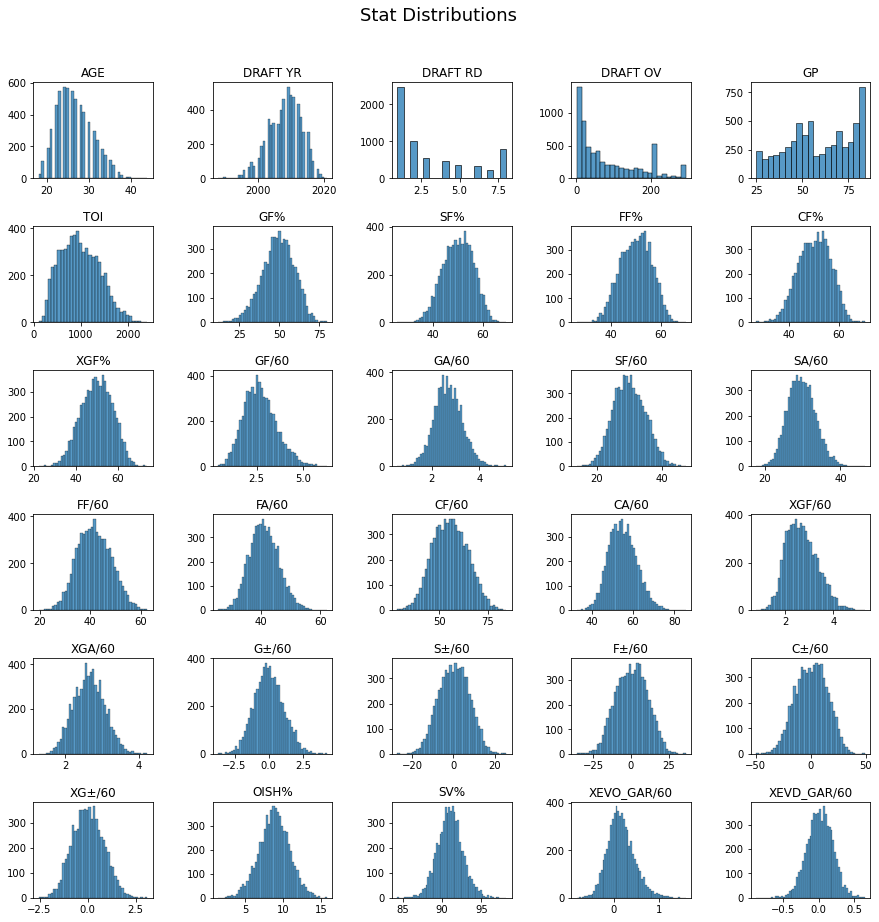

In [11]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Distributions", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[0:30]):
    ax = plt.subplot(6, 5, n + 1)

    sns.histplot(x = column, data = player_df)

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

Overall this is data is pretty regularly distributed.  `GP` is definitely right skewed, and `Draft Ov` is left skewed.

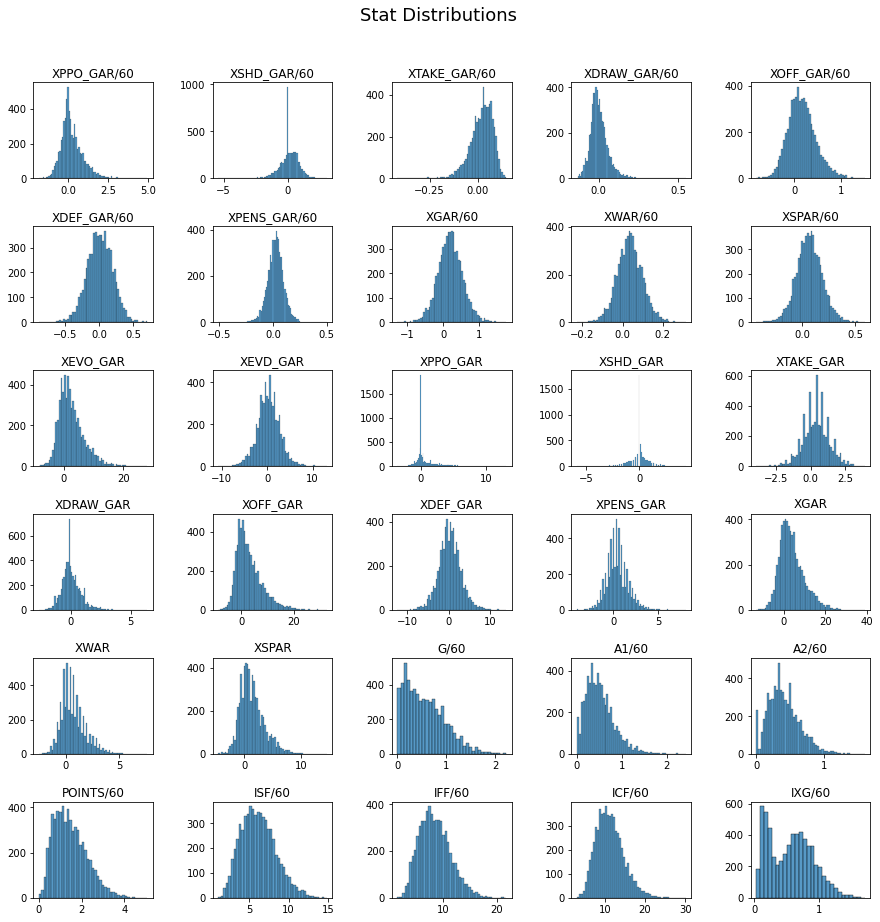

In [12]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Distributions", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[30:60]):
    ax = plt.subplot(6, 5, n + 1)

    sns.histplot(x = column, data = player_df)

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

Getting to some Total and counting stats, we start to see some right skewed data: `G/60`, `A1/60`, `A2/60`

`IXG/60` has a bimodal distribution.  Some have a lot of values at or near 0 (`XDRAW_GAR`, `XSHD_GAR`, etc).  Many features are still regularly distributed.

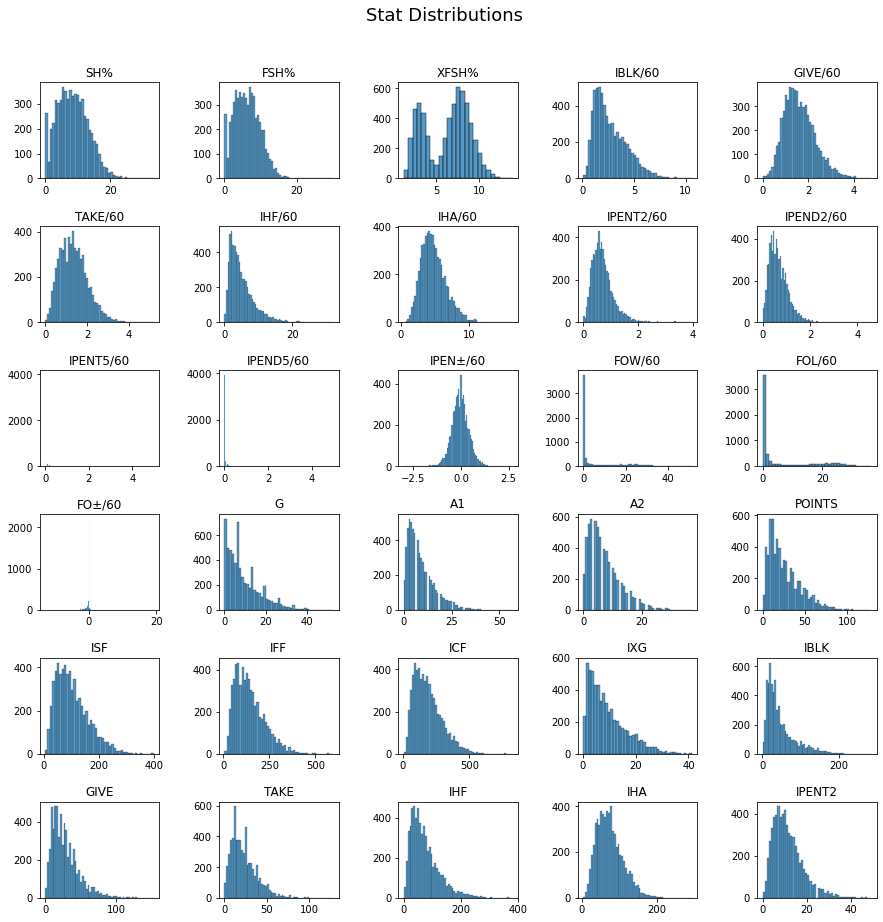

In [13]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Distributions", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[60:90]):
    ax = plt.subplot(6, 5, n + 1)

    sns.histplot(x = column, data = player_df)

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

As we come to more counting stats, we have a lot more right-skewed data.  A lot of values for zero for a few features as well (`FOW/60`, `FOL/60`, `IPEND5/60`, etc).  `XFSH%` has a bimodal distribution as well.

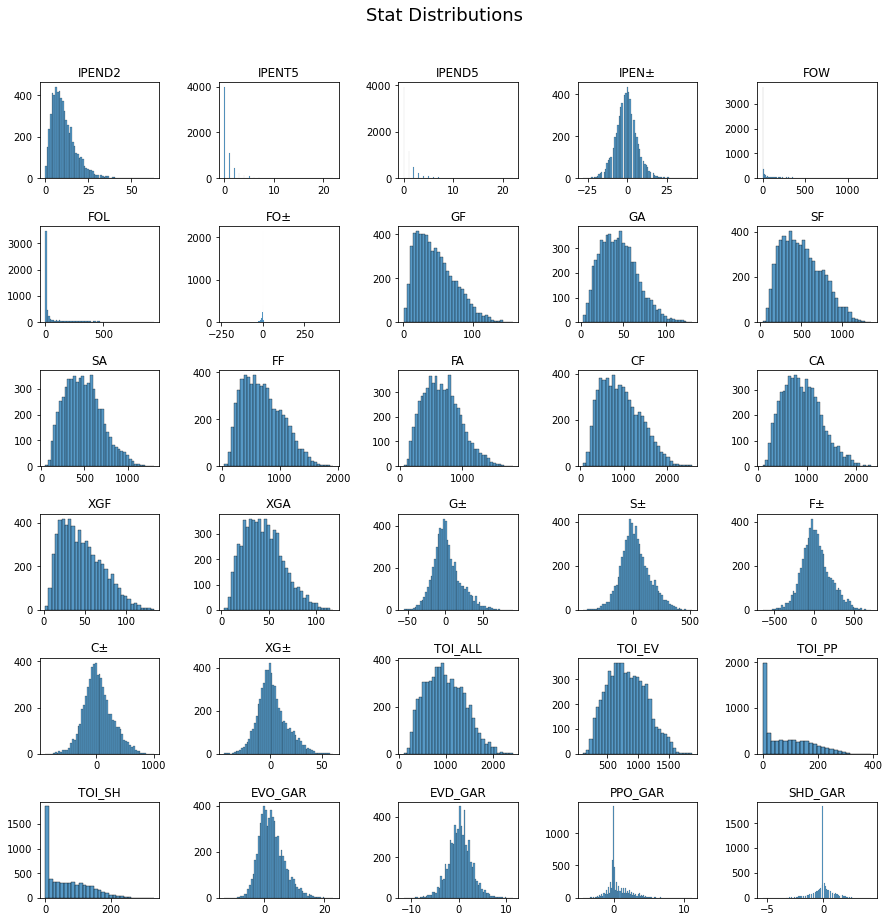

In [14]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Distributions", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[90:120]):
    ax = plt.subplot(6, 5, n + 1)

    sns.histplot(x = column, data = player_df)

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

Here we have some counting stats with a right-skew, though not as much as previous counting stats.  `GF` and `IPEND2` are definitely right skewed.  A lot of zero values for `PPO_GAR` and `SHD_GAR`.

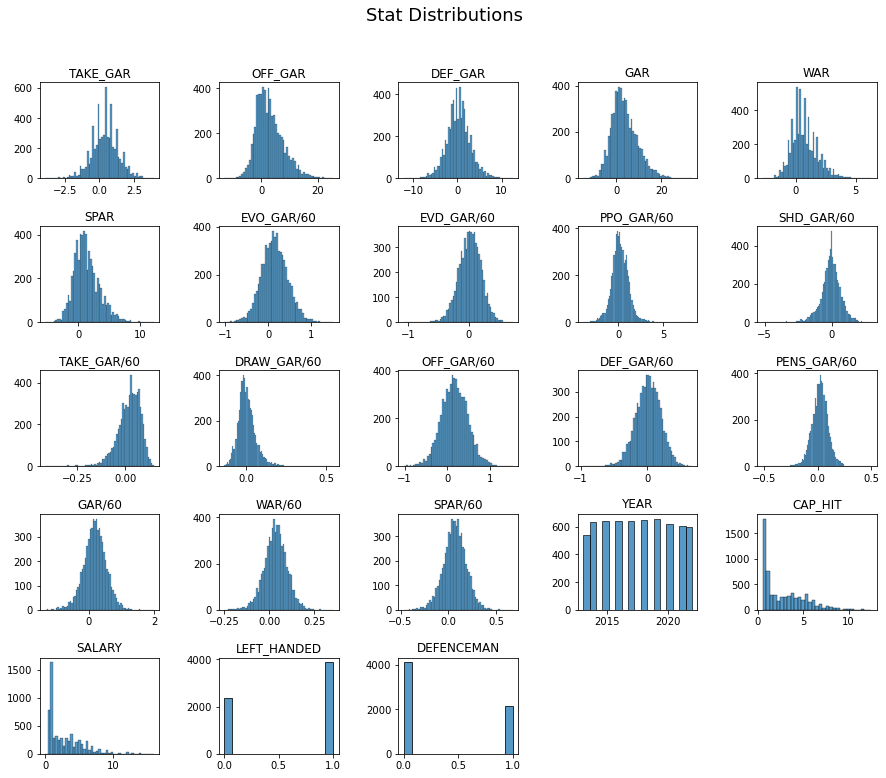

In [15]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Distributions", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[120:]):
    ax = plt.subplot(6, 5, n + 1)

    sns.histplot(x = column, data = player_df)

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

This data is again more regularly distributed.  We seem to have a relatively equal distribution between the Years that are in the data, more left-handed shooters and more forwards than defenceman. `Cap_Hit` and `Salary` themselves are left skewed.

From here, we'll visually inspect each category to see if there is a linear relationship with Cap Hit.

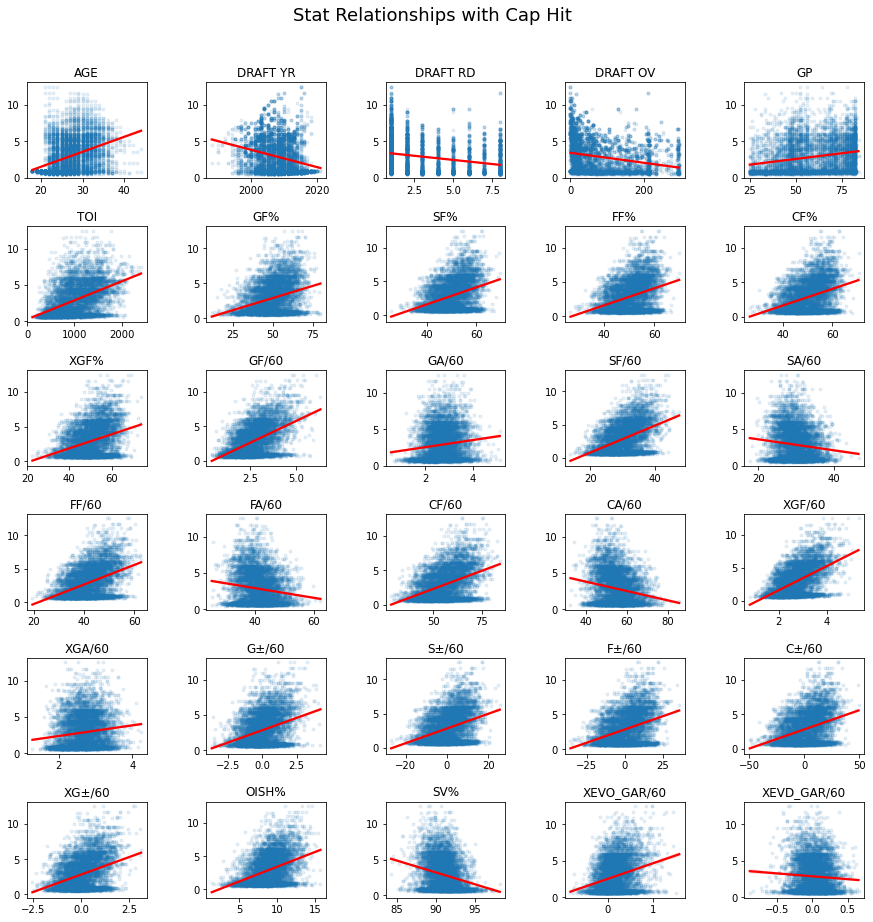

In [16]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Relationships with Cap Hit", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[0:30]):
    ax = plt.subplot(6, 5, n + 1)

    sns.regplot(y = 'Cap_Hit', 
                x = column, 
                data = player_df, 
                marker = '.', 
                scatter_kws = {'alpha':0.1},
               line_kws = {'color':'red'})

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

Here we see nearly all positive relationships except in defensive stats (`CF/60`, `FA/60`, `CA/60`, `SV%`, `XEVD_GAR/60`).  For the most part, these are judged by how many shots you give up, the higher number of goals or shots against you, the higher these stats are, the less you get paid which makes sense.

However, `XEVD_GAR/60` is supposed to be an advanced metric that measures how GOOD a player's defence it, and one would think this would have a more positive relationship with how a player is paid, especially for defencemen.

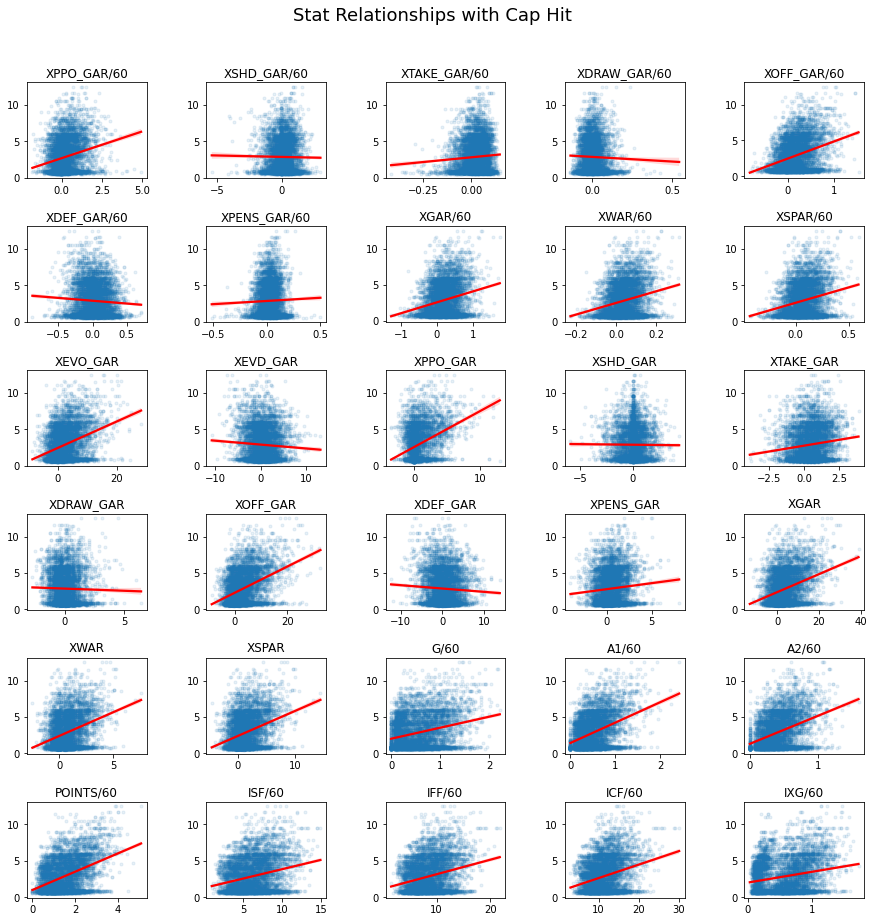

In [17]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Relationships with Cap Hit", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[30:60]):
    ax = plt.subplot(6, 5, n + 1)

    sns.regplot(y = 'Cap_Hit', 
                x = column, 
                data = player_df, 
                marker = '.', 
                scatter_kws = {'alpha':0.1},
               line_kws = {'color':'red'})

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

Here we see a few that have very small linear relationships with `Cap_Hit`.  `XSHD_GAR/60`, `XTAKE_GAR/60`, `XEVD_GAR/60`, `XSHD_GAR`, etc.  These are mostly advanced statistics, but very specialized (eg. Expected defensive performance while shorthanded).

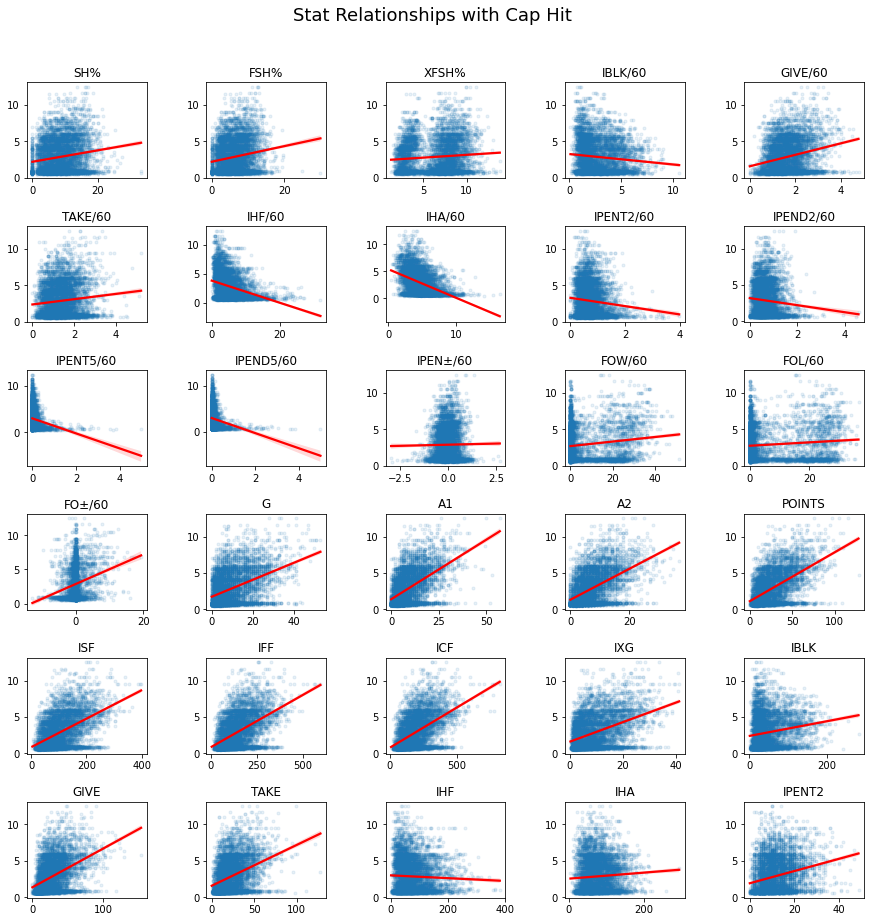

In [18]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Relationships with Cap Hit", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[60:90]):
    ax = plt.subplot(6, 5, n + 1)

    sns.regplot(y = 'Cap_Hit', 
                x = column, 
                data = player_df, 
                marker = '.', 
                scatter_kws = {'alpha':0.1},
               line_kws = {'color':'red'})

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

`iHF/60`, `iHA/60` and all of the statistics involving penalties taken are the most apparent negative linear relationships so far.  Our traditional counting stats (Goals, Assists, Points) are some of the most apparent positive linear relationships so far.

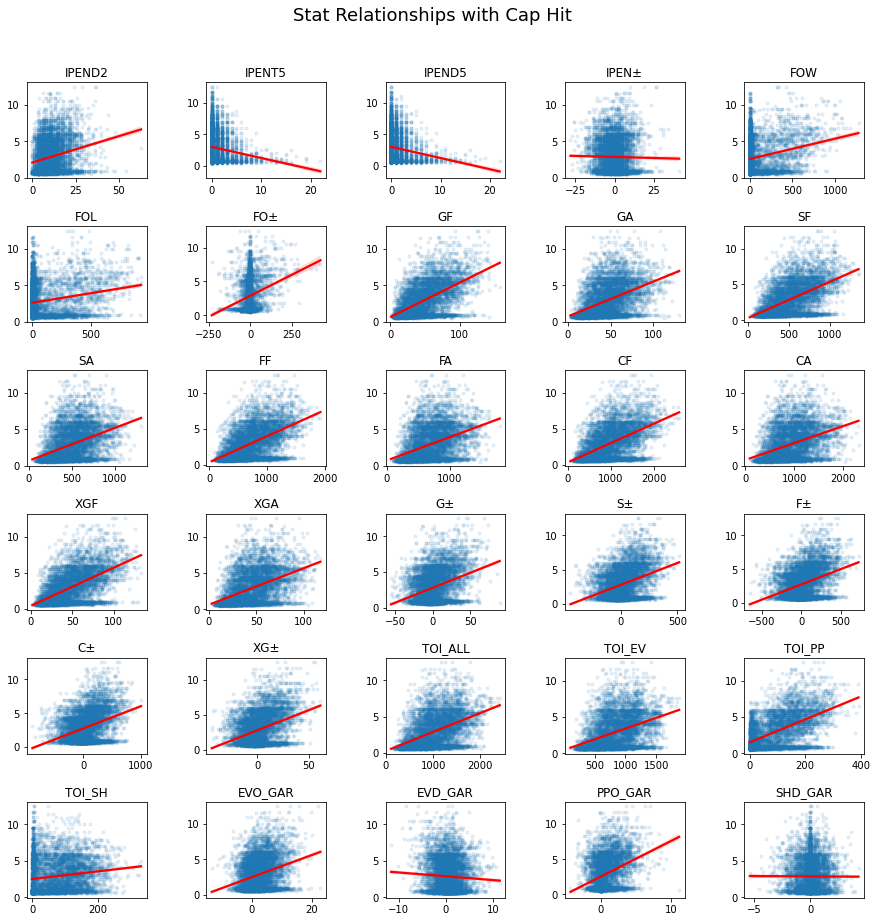

In [19]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Relationships with Cap Hit", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[90:120]):
    ax = plt.subplot(6, 5, n + 1)

    sns.regplot(y = 'Cap_Hit', 
                x = column, 
                data = player_df, 
                marker = '.', 
                scatter_kws = {'alpha':0.1},
               line_kws = {'color':'red'})

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

We see more offensive counting stats related to shots, goals for and against are all positively correlated.  Goals Against having a positive correlation is interesting, considering that would indicate the player gave up lots of goals on the ice.  Perhaps this is a sign that players that are on the ice more end up being on the ice for longer, as oppose to anything specific about their defensive skill.

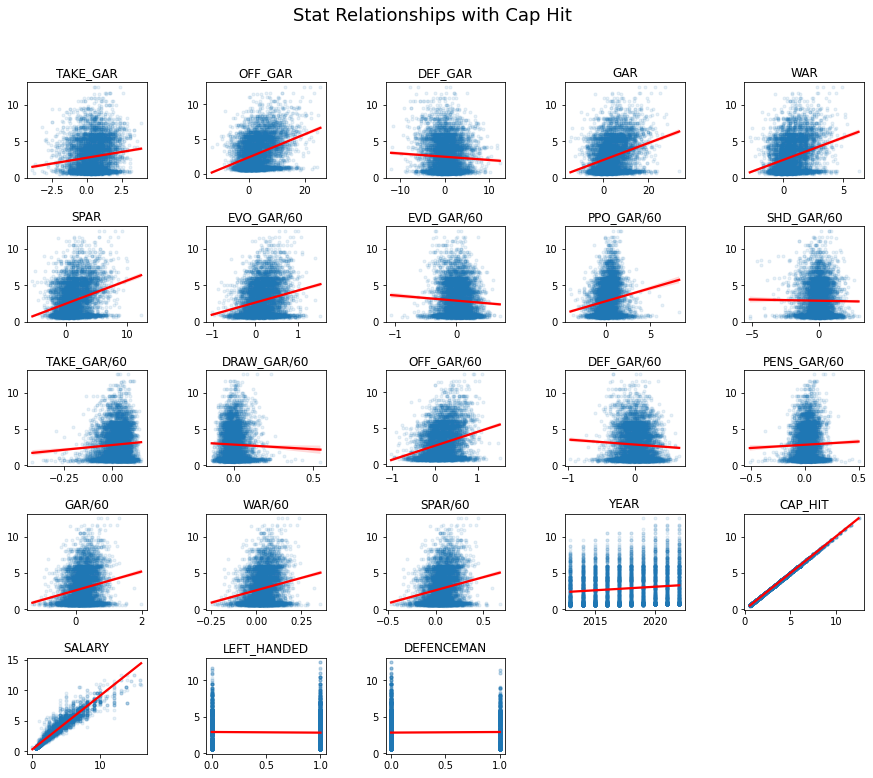

In [20]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Relationships with Cap Hit", fontsize=18, y=0.95)

for n, column in enumerate(numeric_col.columns[120:]):
    ax = plt.subplot(6, 5, n + 1)

    sns.regplot(y = 'Cap_Hit', 
                x = column, 
                data = player_df, 
                marker = '.', 
                scatter_kws = {'alpha':0.1},
               line_kws = {'color':'red'})

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

The most general advanced stats here (`GAR`, `WAR`) have good positive relationships, with `OFF_GAR` seemingly having the strongest.

#### EDA Summary

Overall, it is apparent that most of these statistics, but especially the ones that measure offensive production, have a postive correlation with `Cap_Hit`.

It is difficult to discern which features may have a MORE positive relationship with `Cap_Hit` than others.  On an initial inspection it does seem that some counting stats (Goals, Goals For, Points) have a greater positive correlation than more advanced statistics (GAR, WAR).

Defensive advanced statistics (`DEF_GAR`, `DEF_GAR/60`) actually have negative correlations with `Cap_Hit`.  It's clear that players are mostly paid for their offensive contribution, but this hints at the fact that players who are better defensively than they are offensively may be undervalued assets.

The number of hits a player takes and gives (`iHF`, `iHA`) have very significant negative correlations, as does taking major penalties (`iPENT5`).

When exploring the coefficients and feature importance of this model, identifying which factors are important will be key and likely more helpful than what can be seen on the initial EDA.

### Data Transformation
<a id = 'train'></a>

A few things will need to be adjusted as we get this ready for analysis.

1. Many of the counting statistics should be log-transformed in hopes of creating a more regular distribution in the data to ensure we can have as much of the data as normally distributed as possible to perform our linear regressions.

2. Some features are duplicative or not helpful for this part of the analysis.  `Salary` and `Cap_Hit` are too closely aligned, and here we will be focusing on `Cap_Hit` as the target, so we will drop `Salary`.

3. `Draft Yr` is determined by `Age`.  Having both columns is redundant so we will drop `Draft Yr`.

4. `Draft Rd` does not add anything additional to the data that Draft Ov does now.  `Draft Rd` can even be confusing considering that the number of rounds, and the number of teams, in the draft has varied over the last few years making it inconsistent.

We'll start with log-transforming the data that are significantly right-skewed.

In [21]:
#Empty dataframe ready to be filled with log_transformed data
log_df = pd.DataFrame()

In [22]:
#List of statistics that should be log-transformed
log_list = ['G/60', 'A1/60', 'A2/60', 'Points/60', 'FSh%', 'iBLK/60', 'iHF/60', 'iHA/60', 'G', 'A1', 'A2',
            'Points', 'iSF', 'iFF', 'iCF', 'ixG', 'iBLK', 'GIVE', 'TAKE', 'iHF', 'iHA', 'iPENT2', 'iPEND2']

In [23]:
log_list

['G/60',
 'A1/60',
 'A2/60',
 'Points/60',
 'FSh%',
 'iBLK/60',
 'iHF/60',
 'iHA/60',
 'G',
 'A1',
 'A2',
 'Points',
 'iSF',
 'iFF',
 'iCF',
 'ixG',
 'iBLK',
 'GIVE',
 'TAKE',
 'iHF',
 'iHA',
 'iPENT2',
 'iPEND2']

In [24]:
player_df[log_list]

G/60  A1/60  A2/60  Points/60   FSh%  iBLK/60  iHF/60  iHA/60   G  A1  \
0     0.41   0.34   0.58       1.32   5.04     2.72    3.70    4.62  12  10   
1     0.53   0.28   0.46       1.28   6.25     2.09    3.09    4.47  15   8   
2     0.41   0.16   0.29       0.86   3.38     2.55    3.62    3.45  10   4   
3     0.50   0.19   0.50       1.19   5.65     3.79    2.16    2.25  16   6   
4     0.40   0.25   0.50       1.15   5.65     2.72    3.53    3.56  13   8   
...    ...    ...    ...        ...    ...      ...     ...     ...  ..  ..   
6221  0.43   0.49   0.06       0.97   4.76     1.58    7.30    6.38   7   8   
6222  0.43   0.25   0.25       0.92   4.93     1.97    8.26    7.58   7   4   
6223  0.31   0.37   0.43       1.10   4.46     1.78    8.82    6.49   5   6   
6224  0.76   0.25   0.19       1.20  10.62     1.26    6.93    4.48  12   4   
6225  0.81   0.58   0.00       1.39   9.21     1.50    5.67    6.36   7   5   

      A2  Points  iSF  iFF  iCF    ixG  iBLK  GIVE  TAKE  iHF  iHA  iPENT2  \
0     17      39  170  238  351   8.97    80    41    26  109  136      16   
1     13      36  182  240  324  10.20    59    41    24   87  126      19   
2      7      21  225  296  408  12.03    62    58    25   88   84      29   
3     16      38  189  283  399  12.60   121    99    40   69   72      29   
4     16      37  180  230  315   9.31    88   122    47  114  115      21   
...   ..     ...  ...  ...  ...    ...   ...   ...   ...  ...  ...     ...   
6221   1      16  112  147  189   9.67    26    16    17  120  105       9   
6222   4      15  113  142  168   8.79    32    12    18  134  123      13   
6223   7      18   78  112  132   7.99    29    11    21  144  106       6   
6224   3      19   85  113  144  10.85    20    11    13  110   71       5   
6225   0      12   61   76   89   6.07    13     6    13   49   55       5   

      iPEND2  
0         15  
1          8  
2         17  
3          9  
4         15  
...      ...  
6221      19  
6222      17  
6223      12  
6224       6  
6225       5  

[6226 rows x 23 columns]

In [25]:
log_df = np.log(player_df[log_list] + 1)

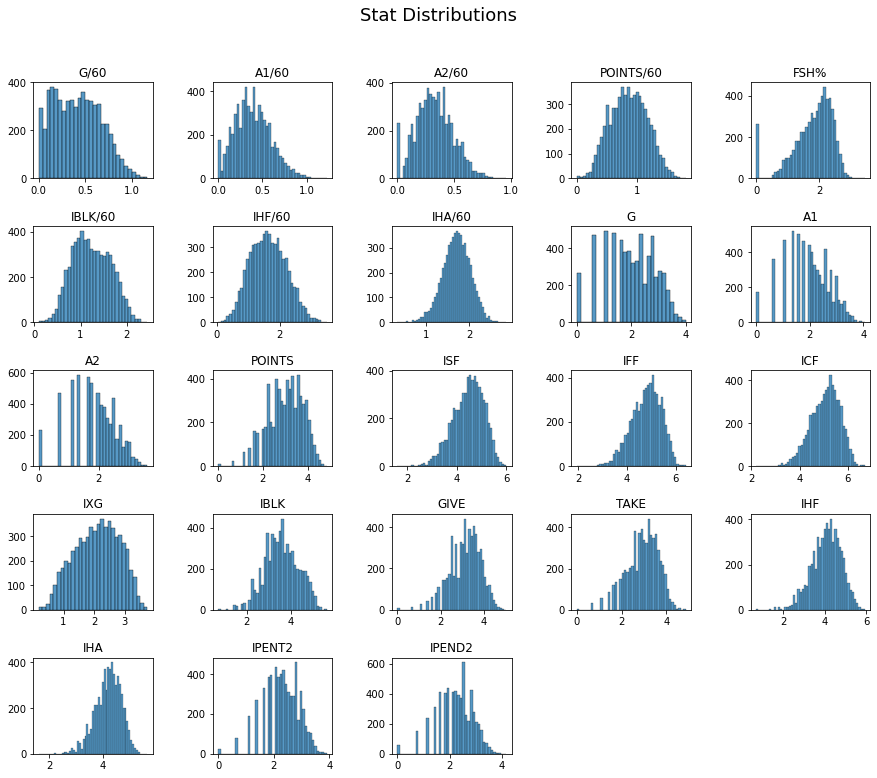

In [26]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.suptitle("Stat Distributions", fontsize=18, y=0.95)

for n, column in enumerate(log_df.columns):
    ax = plt.subplot(6, 5, n + 1)

    sns.histplot(x = column, data = log_df)

    ax.set_title(column.upper())
    ax.set_xlabel('')
    ax.set_ylabel('')

Most of these transformations successfully made the data more regularly distributed.  Goals, assists and points have some strange distributions (especially Goals), but their rating stats (`G/60`, `A1/60`, `A2/60` and `Points/60`) all look more regular.  There are a lot of players who have not scored goals even relative to the proportions of the league.

Next, we will try to make `xFSh%` from bimodal to more regular distribution.

In [27]:
log_df['xFSh%'] = abs(player_df['xFSh%'] - np.mean(player_df['xFSh%']))

Text(361.9142857142858, 0.5, '')

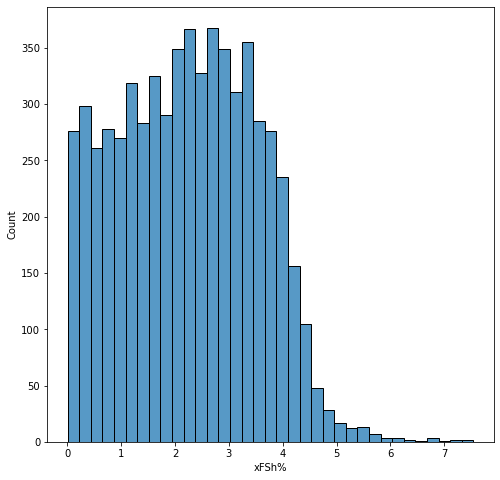

In [28]:
plt.figure(figsize=(8, 8))
sns.histplot(x = 'xFSh%', data = log_df)
ax.set_title('xFSh%')
ax.set_xlabel('')
ax.set_ylabel('')

This isn't quite a regular distribution but it has removed the bi-modality that was in the statistic previously.



In [29]:
#We'll change the names to the columns to remind ourselves that these are the columns that have been transformed
log_df.columns = ["log_" + i for i in log_df.columns]

In [30]:
log_df

log_G/60  log_A1/60  log_A2/60  log_Points/60  log_FSh%  log_iBLK/60  \
0     0.343590   0.292670   0.457425       0.841567  1.798404     1.313724   
1     0.425268   0.246860   0.378436       0.824175  1.981001     1.128171   
2     0.343590   0.148420   0.254642       0.620576  1.477049     1.266948   
3     0.405465   0.173953   0.405465       0.783902  1.894617     1.566530   
4     0.336472   0.223144   0.405465       0.765468  1.894617     1.313724   
...        ...        ...        ...            ...       ...          ...   
6221  0.357674   0.398776   0.058269       0.678034  1.750937     0.947789   
6222  0.357674   0.223144   0.223144       0.652325  1.780024     1.088562   
6223  0.270027   0.314811   0.357674       0.741937  1.697449     1.022451   
6224  0.565314   0.223144   0.173953       0.788457  2.452728     0.815365   
6225  0.593327   0.457425   0.000000       0.871293  2.323368     0.916291   

      log_iHF/60  log_iHA/60     log_G    log_A1    log_A2  log_Points  \
0       1.547563    1.726332  2.564949  2.397895  2.890372    3.688879   
1       1.408545    1.699279  2.772589  2.197225  2.639057    3.610918   
2       1.530395    1.492904  2.397895  1.609438  2.079442    3.091042   
3       1.150572    1.178655  2.833213  1.945910  2.833213    3.663562   
4       1.510722    1.517323  2.639057  2.197225  2.833213    3.637586   
...          ...         ...       ...       ...       ...         ...   
6221    2.116256    1.998774  2.079442  2.197225  0.693147    2.833213   
6222    2.225704    2.149434  2.079442  1.609438  1.609438    2.772589   
6223    2.284421    2.013569  1.791759  1.945910  2.079442    2.944439   
6224    2.070653    1.701105  2.564949  1.609438  1.386294    2.995732   
6225    1.897620    1.996060  2.079442  1.791759  0.000000    2.564949   

       log_iSF   log_iFF   log_iCF   log_ixG  log_iBLK  log_GIVE  log_TAKE  \
0     5.141664  5.476464  5.863631  2.299581  4.394449  3.737670  3.295837   
1     5.209486  5.484797  5.783825  2.415914  4.094345  3.737670  3.218876   
2     5.420535  5.693732  6.013715  2.567254  4.143135  4.077537  3.258097   
3     5.247024  5.648974  5.991465  2.610070  4.804021  4.605170  3.713572   
4     5.198497  5.442418  5.755742  2.333114  4.488636  4.812184  3.871201   
...        ...       ...       ...       ...       ...       ...       ...   
6221  4.727388  4.997212  5.247024  2.367436  3.295837  2.833213  2.890372   
6222  4.736198  4.962845  5.129899  2.281361  3.496508  2.564949  2.944439   
6223  4.369448  4.727388  4.890349  2.196113  3.401197  2.484907  3.091042   
6224  4.454347  4.736198  4.976734  2.472328  3.044522  2.484907  2.639057   
6225  4.127134  4.343805  4.499810  1.955860  2.639057  1.945910  2.639057   

       log_iHF   log_iHA  log_iPENT2  log_iPEND2  log_xFSh%  
0     4.700480  4.919981    2.833213    2.772589   2.506296  
1     4.477337  4.844187    2.995732    2.197225   2.026296  
2     4.488636  4.442651    3.401197    2.890372   2.216296  
3     4.248495  4.290459    3.401197    2.302585   1.826296  
4     4.744932  4.753590    3.091042    2.772589   2.226296  
...        ...       ...         ...         ...        ...  
6221  4.795791  4.663439    2.302585    2.995732   0.303704  
6222  4.905275  4.820282    2.639057    2.890372   0.086296  
6223  4.976734  4.672829    1.945910    2.564949   0.853704  
6224  4.709530  4.276666    1.791759    1.945910   3.323704  
6225  3.912023  4.025352    1.791759    1.791759   1.713704  

[6226 rows x 24 columns]

In order to recombine the data, we are going to create a new DF to fill with the features that we want to keep before recombining it with the log_transformed data.

In [31]:
#We'll remove the features that we identified that we did not need previously
#Adding xFSh% cause it needs to be dropped individually since it was not in the log list
keep_df = player_df.drop(columns = ['Salary', 'Draft Yr', 'Draft Rd', 'xFSh%'])

In [32]:
keep_df.shape

(6226, 143)

In [33]:
log_df.shape

(6226, 24)

In [34]:
#remove the features that we transformed
keep_df = keep_df.drop(columns = log_list)

In [35]:
keep_df.shape

(6226, 120)

In [36]:
#And now we will add the log_df to the keep_df to make it whole again
clean_df = pd.concat([keep_df, log_df], axis = 1)

In [37]:
clean_df.head()

Player Team   Birthday  Age  Draft Ov  GP      TOI    GF%    SF%  \
0  aaron ekblad  FLA 1996-02-07   18       1.0  81  1766.62  59.96  57.82   
1  aaron ekblad  FLA 1996-02-07   19       1.0  78  1690.82  60.69  56.43   
2  aaron ekblad  FLA 1996-02-07   20       1.0  68  1459.28  46.49  55.24   
3  aaron ekblad  FLA 1996-02-07   21       1.0  82  1917.90  53.04  48.15   
4  aaron ekblad  FLA 1996-02-07   22       1.0  82  1938.82  49.07  51.97   

     FF%    CF%   xGF%  GF/60  GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  \
0  56.61  57.07  58.74   2.93   1.96  34.78  25.38  45.59  34.94  59.18   
1  55.41  55.96  57.83   3.29   2.13  31.34  24.20  42.34  34.07  54.45   
2  55.40  56.71  53.00   2.21   2.54  35.47  28.75  48.02  38.66  63.21   
3  48.85  48.87  47.70   3.60   3.19  34.88  37.56  47.86  50.11  60.62   
4  49.96  49.34  47.24   3.51   3.65  33.43  30.90  43.90  43.97  55.82   

   CA/60  xGF/60  xGA/60  G±/60  S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  \
0  44.51    2.78    1.95   0.97   9.40  10.65  14.67    0.83   8.43  92.29   
1  42.84    2.94    2.14   1.16   7.14   8.27  11.61    0.80  10.51  91.18   
2  48.24    2.81    2.49  -0.33   6.72   9.36  14.96    0.32   6.22  91.17   
3  63.41    3.26    3.57   0.41  -2.68  -2.25  -2.79   -0.31  10.33  91.51   
4  57.31    2.90    3.24  -0.13   2.53  -0.07  -1.49   -0.34  10.51  88.20   

   xEVO_GAR/60  xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  \
0        0.183        0.105        1.267       -0.170         0.033   
1        0.415        0.132       -0.004        0.359         0.034   
2       -0.055       -0.007        0.449        0.754        -0.003   
3        0.273       -0.197        1.128       -0.540        -0.036   
4        0.310        0.138        1.574        0.766        -0.016   

   xDraw_GAR/60  xOff_GAR/60  xDef_GAR/60  xPens_GAR/60  xGAR/60  xWAR/60  \
0         0.023        0.324        0.100         0.056    0.454    0.086   
1        -0.022        0.358        0.140         0.011    0.468    0.090   
2         0.006        0.013        0.025         0.003    0.037    0.007   
3        -0.025        0.362       -0.234        -0.061    0.049    0.010   
4         0.021        0.412        0.206         0.005    0.552    0.103   

   xSPAR/60  xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  \
0     0.165       4.5       2.6       4.7      -0.1        1.0        0.7   
1     0.174       9.5       3.0       0.0       0.3        0.9       -0.6   
2     0.013      -1.1      -0.1       1.4       0.7       -0.1        0.1   
3     0.018       6.8      -4.9       3.3      -1.6       -1.2       -0.8   
4     0.194       8.1       3.6       3.6       2.4       -0.5        0.7   

   xOff_GAR  xDef_GAR  xPens_GAR  xGAR  xWAR  xSPAR  iSF/60  iFF/60  iCF/60  \
0       9.2       2.5        1.6  13.4   2.5    4.9    5.77    8.08   11.92   
1       9.5       3.4        0.3  13.2   2.5    4.9    6.46    8.52   11.50   
2       0.3       0.5        0.1   0.9   0.2    0.3    9.25   12.17   16.78   
3      10.1      -6.6       -2.0   1.6   0.3    0.6    5.91    8.85   12.48   
4      11.7       6.0        0.2  17.8   3.3    6.3    5.57    7.12    9.75   

   ixG/60   Sh%  GIVE/60  TAKE/60  iPENT2/60  iPEND2/60  iPENT5/60  iPEND5/60  \
0    0.30  7.06     1.39     0.88       0.54       0.51       0.00       0.00   
1    0.36  8.24     1.45     0.85       0.67       0.28       0.04       0.04   
2    0.49  4.44     2.38     1.03       1.19       0.70       0.00       0.00   
3    0.39  8.47     3.10     1.25       0.91       0.28       0.09       0.09   
4    0.29  7.22     3.78     1.45       0.65       0.46       0.03       0.03   

   iPEN±/60  FOW/60  FOL/60  FO±/60  iPENT5  iPEND5  iPEN±  FOW  FOL  FO±  \
0     -0.03     0.0     0.0     0.0       0       0     -1    0    0    0   
1     -0.39     0.0     0.0     0.0       1       1    -11    0    0    0   
2     -0.49     0.0     0.0     0.0       0       0    -12    0    0    0   
3  

In [38]:
player_df.shape

(6226, 147)

In [39]:
#This is good, we should have 3 fewer columns now that we have dropped Draft Rd, Draft Yr and Salary
clean_df.shape

(6226, 144)

In [40]:
clean_df.head(1)

Player Team   Birthday  Age  Draft Ov  GP      TOI    GF%    SF%  \
0  aaron ekblad  FLA 1996-02-07   18       1.0  81  1766.62  59.96  57.82   

     FF%    CF%   xGF%  GF/60  GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  \
0  56.61  57.07  58.74   2.93   1.96  34.78  25.38  45.59  34.94  59.18   

   CA/60  xGF/60  xGA/60  G±/60  S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  \
0  44.51    2.78    1.95   0.97    9.4  10.65  14.67    0.83   8.43  92.29   

   xEVO_GAR/60  xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  \
0        0.183        0.105        1.267        -0.17         0.033   

   xDraw_GAR/60  xOff_GAR/60  xDef_GAR/60  xPens_GAR/60  xGAR/60  xWAR/60  \
0         0.023        0.324          0.1         0.056    0.454    0.086   

   xSPAR/60  xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  \
0     0.165       4.5       2.6       4.7      -0.1        1.0        0.7   

   xOff_GAR  xDef_GAR  xPens_GAR  xGAR  xWAR  xSPAR  iSF/60  iFF/60  iCF/60  \
0       9.2       2.5        1.6  13.4   2.5    4.9    5.77    8.08   11.92   

   ixG/60   Sh%  GIVE/60  TAKE/60  iPENT2/60  iPEND2/60  iPENT5/60  iPEND5/60  \
0     0.3  7.06     1.39     0.88       0.54       0.51        0.0        0.0   

   iPEN±/60  FOW/60  FOL/60  FO±/60  iPENT5  iPEND5  iPEN±  FOW  FOL  FO±  \
0     -0.03     0.0     0.0     0.0       0       0     -1    0    0    0   

     GF     GA      SF      SA       FF       FA       CF       CA    xGF  \
0  86.3  57.63  1024.1  747.21  1342.33  1028.68  1742.44  1310.56  81.86   

     xGA     G±      S±      F±      C±    xG±  TOI_All  TOI_EV  TOI_PP  \
0  57.49  28.67  276.89  313.65  431.88  24.37   1766.6  1485.7   221.4   

   TOI_SH  EVO_GAR  EVD_GAR  PPO_GAR  SHD_GAR  Take_GAR  Off_GAR  Def_GAR  \
0    31.5      5.5      5.7      1.2     -0.3       1.0      6.7      5.4   

    GAR  WAR  SPAR  EVO_GAR/60  EVD_GAR/60  PPO_GAR/60  SHD_GAR/60  \
0  13.8  2.6   5.0       0.222        0.23       0.326      -0.547   

   Take_GAR/60  Draw_GAR/60  Off_GAR/60  Def_GAR/60  Pens_GAR/60  GAR/60  \
0        0.033        0.023       0.236       0.214        0.056   0.467   

   WAR/60  SPAR/60  Year  Cap_Hit  Left_Handed  Defenceman  \
0   0.089     0.17  2015    0.925            0           1   

                     ID  log_G/60  log_A1/60  log_A2/60  log_Points/60  \
0  aaron ekblad-18-2015   0.34359    0.29267   0.457425       0.841567   

   log_FSh%  log_iBLK/60  log_iHF/60  log_iHA/60     log_G    log_A1  \
0  1.798404     1.313724    1.547563    1.726332  2.564949  2.397895   

     log_A2  log_Points   log_iSF   log_iFF   log_iCF   log_ixG  log_iBLK  \
0  2.890372    3.688879  5.141664  5.476464  5.863631  2.299581  4.394449   

   log_GIVE  log_TAKE  log_iHF   log_iHA  log_iPENT2  log_iPEND2  log_xFSh%  
0   3.73767  3.295837  4.70048  4.919981    2.833213    2.772589   2.506296

In [41]:
#We're going to move the categorical columns to the end of the DF in order to re-use a previous piece of code
#First popping the columns and putting them into their own dataframes
df1 = clean_df.pop('Left_Handed')
df2 = clean_df.pop('Defenceman')

#Then adding them onto the clean dataset
clean_df['Left_Handed'] = df1
clean_df['Defenceman'] = df2

In [42]:
#Check to see if the re-ordering worked
clean_df.head()

Player Team   Birthday  Age  Draft Ov  GP      TOI    GF%    SF%  \
0  aaron ekblad  FLA 1996-02-07   18       1.0  81  1766.62  59.96  57.82   
1  aaron ekblad  FLA 1996-02-07   19       1.0  78  1690.82  60.69  56.43   
2  aaron ekblad  FLA 1996-02-07   20       1.0  68  1459.28  46.49  55.24   
3  aaron ekblad  FLA 1996-02-07   21       1.0  82  1917.90  53.04  48.15   
4  aaron ekblad  FLA 1996-02-07   22       1.0  82  1938.82  49.07  51.97   

     FF%    CF%   xGF%  GF/60  GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  \
0  56.61  57.07  58.74   2.93   1.96  34.78  25.38  45.59  34.94  59.18   
1  55.41  55.96  57.83   3.29   2.13  31.34  24.20  42.34  34.07  54.45   
2  55.40  56.71  53.00   2.21   2.54  35.47  28.75  48.02  38.66  63.21   
3  48.85  48.87  47.70   3.60   3.19  34.88  37.56  47.86  50.11  60.62   
4  49.96  49.34  47.24   3.51   3.65  33.43  30.90  43.90  43.97  55.82   

   CA/60  xGF/60  xGA/60  G±/60  S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  \
0  44.51    2.78    1.95   0.97   9.40  10.65  14.67    0.83   8.43  92.29   
1  42.84    2.94    2.14   1.16   7.14   8.27  11.61    0.80  10.51  91.18   
2  48.24    2.81    2.49  -0.33   6.72   9.36  14.96    0.32   6.22  91.17   
3  63.41    3.26    3.57   0.41  -2.68  -2.25  -2.79   -0.31  10.33  91.51   
4  57.31    2.90    3.24  -0.13   2.53  -0.07  -1.49   -0.34  10.51  88.20   

   xEVO_GAR/60  xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  \
0        0.183        0.105        1.267       -0.170         0.033   
1        0.415        0.132       -0.004        0.359         0.034   
2       -0.055       -0.007        0.449        0.754        -0.003   
3        0.273       -0.197        1.128       -0.540        -0.036   
4        0.310        0.138        1.574        0.766        -0.016   

   xDraw_GAR/60  xOff_GAR/60  xDef_GAR/60  xPens_GAR/60  xGAR/60  xWAR/60  \
0         0.023        0.324        0.100         0.056    0.454    0.086   
1        -0.022        0.358        0.140         0.011    0.468    0.090   
2         0.006        0.013        0.025         0.003    0.037    0.007   
3        -0.025        0.362       -0.234        -0.061    0.049    0.010   
4         0.021        0.412        0.206         0.005    0.552    0.103   

   xSPAR/60  xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  \
0     0.165       4.5       2.6       4.7      -0.1        1.0        0.7   
1     0.174       9.5       3.0       0.0       0.3        0.9       -0.6   
2     0.013      -1.1      -0.1       1.4       0.7       -0.1        0.1   
3     0.018       6.8      -4.9       3.3      -1.6       -1.2       -0.8   
4     0.194       8.1       3.6       3.6       2.4       -0.5        0.7   

   xOff_GAR  xDef_GAR  xPens_GAR  xGAR  xWAR  xSPAR  iSF/60  iFF/60  iCF/60  \
0       9.2       2.5        1.6  13.4   2.5    4.9    5.77    8.08   11.92   
1       9.5       3.4        0.3  13.2   2.5    4.9    6.46    8.52   11.50   
2       0.3       0.5        0.1   0.9   0.2    0.3    9.25   12.17   16.78   
3      10.1      -6.6       -2.0   1.6   0.3    0.6    5.91    8.85   12.48   
4      11.7       6.0        0.2  17.8   3.3    6.3    5.57    7.12    9.75   

   ixG/60   Sh%  GIVE/60  TAKE/60  iPENT2/60  iPEND2/60  iPENT5/60  iPEND5/60  \
0    0.30  7.06     1.39     0.88       0.54       0.51       0.00       0.00   
1    0.36  8.24     1.45     0.85       0.67       0.28       0.04       0.04   
2    0.49  4.44     2.38     1.03       1.19       0.70       0.00       0.00   
3    0.39  8.47     3.10     1.25       0.91       0.28       0.09       0.09   
4    0.29  7.22     3.78     1.45       0.65       0.46       0.03       0.03   

   iPEN±/60  FOW/60  FOL/60  FO±/60  iPENT5  iPEND5  iPEN±  FOW  FOL  FO±  \
0     -0.03     0.0     0.0     0.0       0       0     -1    0    0    0   
1     -0.39     0.0     0.0     0.0       1       1    -11    0    0    0   
2     -0.49     0.0     0.0     0.0       0       0    -12    0    0    0   
3  

With that, we will now separate the data into our features and target before doing our train test split prior to our modeling.

In [43]:
#By changing our index previous, we can drop Player here and still identify the player
X = clean_df.drop(columns = ['Cap_Hit', 'Team', 'Birthday', 'ID', 'Player'])
y = clean_df['Cap_Hit']

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
#Initiate a random state so that the data is split the same way every time this notebook is run
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

In [46]:
X_train

Age  Draft Ov  GP      TOI    GF%    SF%    FF%    CF%   xGF%  GF/60  \
4311   21       1.0  82  1635.40  46.38  51.25  51.30  51.56  49.40   3.05   
30     22     149.0  59   730.63  55.20  48.03  50.90  50.91  52.98   3.74   
3910   32      28.0  68  1489.53  54.47  52.92  51.50  51.18  50.65   3.29   
5691   25      16.0  68  1241.18  46.80  50.50  50.45  50.65  49.65   3.66   
3142   25      37.0  76  1692.35  48.76  57.88  57.93  59.48  56.73   2.97   
...   ...       ...  ..      ...    ...    ...    ...    ...    ...    ...   
6026   33       1.0  69  1048.17  49.26  51.79  52.42  52.77  54.74   2.83   
79     21      29.0  81  1079.82  59.81  49.20  49.56  50.80  49.09   2.90   
3927   33      57.0  68   743.57  36.65  46.32  46.82  45.85  44.47   1.53   
5955   18      10.0  79  1182.52  63.88  54.29  54.22  53.76  54.91   3.02   
5640   23       9.0  54   866.33  52.59  54.00  53.60  53.95  56.27   3.17   

      GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  CA/60  xGF/60  xGA/60  G±/60  \
4311   3.52  33.35  31.73  46.00  43.67  60.39  56.74    3.07    3.14  -0.48   
30     3.03  30.59  33.10  44.21  42.66  59.15  57.03    2.76    2.45   0.70   
3910   2.75  30.93  27.52  40.31  37.96  52.67  50.25    2.88    2.80   0.54   
5691   4.16  32.89  32.24  44.41  43.62  59.10  57.57    3.16    3.21  -0.50   
3142   3.12  37.32  27.16  51.94  37.72  71.62  48.80    3.60    2.74  -0.15   
...     ...    ...    ...    ...    ...    ...    ...     ...     ...    ...   
6026   2.92  32.72  30.46  45.45  41.25  60.60  54.25    3.13    2.59  -0.09   
79     1.95  30.84  31.84  44.22  45.01  59.35  57.49    2.62    2.72   0.95   
3927   2.65  27.39  31.75  40.02  45.46  53.09  62.69    2.30    2.87  -1.12   
5955   1.71  33.21  27.96  46.30  39.09  61.62  53.01    2.96    2.43   1.31   
5640   2.86  32.51  27.69  44.93  38.89  60.88  51.96    3.17    2.46   0.31   

      S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  xEVO_GAR/60  xEVD_GAR/60  \
4311   1.62   2.34   3.65   -0.07   9.13  88.90        0.307       -0.086   
30    -2.51   1.56   2.12    0.31  12.21  90.84        0.039       -0.164   
3910   3.41   2.35   2.42    0.07  10.63  90.02        0.046        0.239   
5691   0.65   0.79   1.53   -0.04  11.13  87.10        0.200        0.029   
3142  10.16  14.22  22.83    0.85   7.95  88.52        0.149        0.043   
...     ...    ...    ...     ...    ...    ...          ...          ...   
6026   2.26   4.20   6.36    0.54   8.66  90.42        0.324       -0.358   
79    -1.00  -0.79   1.86   -0.10   9.42  93.87        0.340       -0.353   
3927  -4.36  -5.44  -9.60   -0.57   5.59  91.66        0.201        0.456   
5955   5.25   7.21   8.61    0.53   9.08  93.90        0.267        0.004   
5640   4.82   6.04   8.92    0.71   9.76  89.67        0.024       -0.108   

      xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  xOff_GAR/60  \
4311       -0.104       -0.698         0.077         0.013        0.244   
30          1.522       -0.026        -0.030        -0.006        0.223   
3910        0.654        0.197         0.026         0.012        0.112   
5691        1.359       -0.973        -0.044         0.030        0.334   
3142        0.544        0.593        -0.001         0.014        0.203   
...           ...          ...           ...           ...          ...   
6026        1.306       -0.222         0.088        -0.078        0.486   
79         -0.526        0.294        -0.074        -0.065        0.267   
3927       -0.138       -0.759        -0.034        -0.017        0.199   
5955       -0.260       -0.026         0.112         0.087        0.220   
5640       -0.591        0.441        -0.007         0.095       -0.044   

      xDef_GAR/60  xPens_GAR/60  xGAR/60  xWAR/60  xSPAR/60  xEVO_GAR  \
4311       -0.149         0.090    0.180    0.034     0.066       6.2   
30         -0.164        -0.036    0.043    0.008     0.015       0.4   
3910        0.233         0.038    0.340    0.060     0.116    

In [47]:
y_train

4311    6.300
30      0.917
3910    5.750
5691    5.167
3142    4.833
        ...  
6026    4.500
79      0.894
3927    3.125
5955    0.925
5640    6.000
Name: Cap_Hit, Length: 4669, dtype: float64

In [48]:
X_test

Age  Draft Ov  GP      TOI    GF%    SF%    FF%    CF%   xGF%  GF/60  \
3297   28     111.0  32   432.42  44.37  39.92  40.94  39.93  43.45   2.10   
3686   26       7.0  71  1548.12  58.05  53.22  53.25  54.24  54.12   4.61   
5432   26      26.0  49  1138.85  56.22  57.78  56.60  56.76  53.82   3.37   
1254   28      85.0  49   714.25  38.34  44.84  45.38  45.29  42.91   1.90   
2149   32     156.0  44   850.53  29.45  39.48  39.68  38.55  36.25   1.40   
...   ...       ...  ..      ...    ...    ...    ...    ...    ...    ...   
3088   22      13.0  81  1656.53  48.88  47.86  47.01  46.52  47.71   2.79   
4885   27     212.0  40   567.67  36.84  46.68  48.10  45.88  48.60   1.94   
5019   32      78.0  45   630.08  33.43  44.80  43.64  42.87  39.88   1.42   
5819   32      17.0  56   666.20  41.10  50.46  50.68  50.12  48.72   2.00   
5895   26      99.0  46   573.15  53.46  56.83  54.60  54.05  51.86   2.52   

      GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  CA/60  xGF/60  xGA/60  G±/60  \
3297   2.63  21.38  32.18  30.24  43.63  39.67  59.68    1.78    2.31  -0.53   
3686   3.33  36.71  32.26  50.66  44.48  65.42  55.20    3.89    3.30   1.28   
5432   2.62  37.61  27.49  49.84  38.21  67.59  51.49    3.71    3.19   0.74   
1254   3.05  28.40  34.93  39.58  47.65  51.48  62.19    2.45    3.27  -1.15   
2149   3.35  23.24  35.63  32.87  49.96  44.45  70.85    1.84    3.24  -1.95   
...     ...    ...    ...    ...    ...    ...    ...     ...     ...    ...   
3088   2.92  30.33  33.04  40.90  46.11  54.61  62.77    2.52    2.76  -0.13   
4885   3.32  25.97  29.66  39.15  42.24  49.53  58.43    2.35    2.48  -1.38   
5019   2.82  25.27  31.14  33.72  43.55  44.04  58.69    2.13    3.20  -1.40   
5819   2.86  29.87  29.32  43.09  41.94  55.26  54.99    2.45    2.58  -0.86   
5895   2.20  32.23  24.48  43.65  36.30  58.91  50.09    2.38    2.21   0.33   

      S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  xEVO_GAR/60  xEVD_GAR/60  \
3297 -10.80 -13.38 -20.01   -0.54   9.80  91.84        0.043        0.123   
3686   4.45   6.18  10.22    0.59  12.55  89.68        0.481       -0.372   
5432  10.12  11.62  16.10    0.53   8.95  90.46        0.194       -0.173   
1254  -6.53  -8.06 -10.71   -0.81   6.68  91.27       -0.005       -0.148   
2149 -12.39 -17.09 -26.40   -1.40   6.01  90.61       -0.322       -0.204   
...     ...    ...    ...     ...    ...    ...          ...          ...   
3088  -2.71  -5.21  -8.16   -0.24   9.20  91.17        0.294        0.216   
4885  -3.70  -3.09  -8.90   -0.14   7.46  88.80        0.357        0.167   
5019  -5.87  -9.83 -14.64   -1.08   5.61  90.94       -0.186        0.040   
5819   0.55   1.15   0.27   -0.13   6.68  90.24        0.023        0.035   
5895   7.75   7.36   8.83    0.17   7.83  91.02        0.161        0.056   

      xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  xOff_GAR/60  \
3297       -0.028        1.523        -0.072        -0.035        0.043   
3686        1.034       -1.146         0.077         0.004        0.567   
5432        0.263        0.411         0.038        -0.013        0.202   
1254       -0.407       -0.118         0.041         0.059       -0.019   
2149       -0.098       -0.238        -0.067        -0.037       -0.320   
...           ...          ...           ...           ...          ...   
3088       -1.533        0.082        -0.016         0.000        0.261   
4885       -0.001        1.474         0.070         0.017        0.355   
5019        0.391        0.923        -0.056         0.028       -0.185   
5819       -0.598        0.508         0.000         0.049        0.017   
5895        0.121        0.297         0.015         0.074        0.157   

      xDef_GAR/60  xPens_GAR/60  xGAR/60  xWAR/60  xSPAR/60  xEVO_GAR  \
3297        0.213        -0.107    0.144    0.027     0.052       0.3   
3686       -0.385         0.081    0.306    0.054     0.105       9.9   
5432       -0.166         0.025    0.075    0.013     0.026    

In [49]:
y_test

3297    0.700
3686    6.125
5432    5.200
1254    3.850
2149    2.250
        ...  
3088    0.863
4885    2.250
5019    1.375
5819    2.000
5895    2.000
Name: Cap_Hit, Length: 1557, dtype: float64

### Linear Regression Modeling
<a id = 'lin'></a>

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In preparation for measuring our linear regression models, we will make quick function to allow us to evaluate each one.  Doing this will allow us to acomplish a few things simultaneously:

1. We will primarily use R-Squared as the value to ultimately judge the models on.

2. Separating and evaluating the Training and Testing scores and clearly labeling the results.

3. Using the Mean Absolute Error (MAE) as a measure to see how our model is fitting specifically to our data better.

4. Using the Root Mean Squared Error (RMSE) as a way to better understand the range of model in the units of our target (in our case, Cap_Hit which is measured in $ Millions).

In [52]:
#We'll pass the model, along with the train and test data, to evaluate the model
#Passing the data will help us ensure that we are passing the appropriate scaled (or unscaled) data as we pass
#it through
def model_evaluation(model, X_train, X_test): 
    #Print the r-squared training score to check for overfitting
    print(f'Train R^2 Score: {round(model.score(X_train, y_train), 4)}\n')  
    
    #Print the r-squared test score as the primary evaluation of our testing scores.
    r_squared = round(model.score(X_test, y_test), 4)
    print(f'Test R^2 Score: {r_squared}')
    
    #Printing MAE and RMSE as secondary measures to judge our model
    #MAE will help measure the models against each other as to which one fits the data better
    #RMSE will give us the mean of how far our predictions are from the actual values in the units of y
    #In our case, this is measured in millions of dollars (1.5 = $1,500,000)
    y_pred = model.predict(X_test)
    mae = round(mean_absolute_error(y_test, y_pred),4)
    rmse = round(mean_squared_error(y_test, y_pred, squared = False),4)
    print(f'Test MAE: {mae}')
    print(f'Test RMSE: {rmse}')

To start things off, I will use a Linear Regression model as our starting point.

In [53]:
lin_mod = LinearRegression()
lin_mod.fit(X_train, y_train)

LinearRegression()

In [54]:
model_evaluation(lin_mod, X_train, X_test)

Train R^2 Score: 0.6551

Test R^2 Score: 0.6102
Test MAE: 1.0649
Test RMSE: 1.4219


Here are the scores of the first model by which to measure the rest of our models on.

There are a few issues that we will try to address.  In turn, we will try to do the following:

1. Scale the data and re-run the Linear Regression

2. Use regularization on the data, and then use regularization on the scaled data, to see if we can improve the model's predictions.

First we will try to scale our data.

### Scaling Data for Linear Regression
<a id = 'linscaled'></a>

We just want to scale the numerical data, and maintain our distinct classes for our categorical data, so we will parse out the features with the following lists.

In [55]:
len(X_train.columns)

139

In [56]:
#This range represents the index number of all of the player performance statistics.
num_col = list(range(0, 137))
cat_col = list(range(137, 139))

In [57]:
num_col

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136]

In [58]:
cat_col

[137, 138]

In [59]:
X_train_num = X_train.iloc[:,num_col]
X_test_num = X_test.iloc[:,num_col]

In [60]:
X_train_num.head(5)

Age  Draft Ov  GP      TOI    GF%    SF%    FF%    CF%   xGF%  GF/60  \
4311   21       1.0  82  1635.40  46.38  51.25  51.30  51.56  49.40   3.05   
30     22     149.0  59   730.63  55.20  48.03  50.90  50.91  52.98   3.74   
3910   32      28.0  68  1489.53  54.47  52.92  51.50  51.18  50.65   3.29   
5691   25      16.0  68  1241.18  46.80  50.50  50.45  50.65  49.65   3.66   
3142   25      37.0  76  1692.35  48.76  57.88  57.93  59.48  56.73   2.97   

      GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  CA/60  xGF/60  xGA/60  G±/60  \
4311   3.52  33.35  31.73  46.00  43.67  60.39  56.74    3.07    3.14  -0.48   
30     3.03  30.59  33.10  44.21  42.66  59.15  57.03    2.76    2.45   0.70   
3910   2.75  30.93  27.52  40.31  37.96  52.67  50.25    2.88    2.80   0.54   
5691   4.16  32.89  32.24  44.41  43.62  59.10  57.57    3.16    3.21  -0.50   
3142   3.12  37.32  27.16  51.94  37.72  71.62  48.80    3.60    2.74  -0.15   

      S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  xEVO_GAR/60  xEVD_GAR/60  \
4311   1.62   2.34   3.65   -0.07   9.13  88.90        0.307       -0.086   
30    -2.51   1.56   2.12    0.31  12.21  90.84        0.039       -0.164   
3910   3.41   2.35   2.42    0.07  10.63  90.02        0.046        0.239   
5691   0.65   0.79   1.53   -0.04  11.13  87.10        0.200        0.029   
3142  10.16  14.22  22.83    0.85   7.95  88.52        0.149        0.043   

      xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  xOff_GAR/60  \
4311       -0.104       -0.698         0.077         0.013        0.244   
30          1.522       -0.026        -0.030        -0.006        0.223   
3910        0.654        0.197         0.026         0.012        0.112   
5691        1.359       -0.973        -0.044         0.030        0.334   
3142        0.544        0.593        -0.001         0.014        0.203   

      xDef_GAR/60  xPens_GAR/60  xGAR/60  xWAR/60  xSPAR/60  xEVO_GAR  \
4311       -0.149         0.090    0.180    0.034     0.066       6.2   
30         -0.164        -0.036    0.043    0.008     0.015       0.4   
3910        0.233         0.038    0.340    0.060     0.116       0.9   
5691       -0.099        -0.014    0.184    0.033     0.063       3.1   
3142        0.058         0.013    0.255    0.050     0.095       3.4   

      xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  xDef_GAR  \
4311      -1.7      -0.4      -1.6        2.1        0.3       5.8      -3.3   
30        -1.7       2.3       0.0       -0.4       -0.1       2.7      -1.7   
3910       4.5       1.5       0.6        0.6        0.3       2.4       5.1   
5691       0.5       2.8      -2.2       -0.9        0.6       5.9      -1.8   
3142       1.0       2.0       0.4        0.0        0.4       5.4       1.4   

      xPens_GAR  xGAR  xWAR  xSPAR  iSF/60  iFF/60  iCF/60  ixG/60    Sh%  \
4311        2.5   4.9   0.9    1.8    9.21   12.18   15.96    0.86   6.37   
30         -0.4   0.5   0.1    0.2    6.16    9.61   12.40    0.73  16.00   
3910        0.9   8.4   1.5    2.9    5.08    6.61    9.35    0.25   6.35   
5691       -0.3   3.8   0.7    1.3    7.44    9.86   12.33    1.00  13.64   
3142        0.4   7.2   1.4    2.7    7.48   10.42   15.81    0.43   3.79   

      GIVE/60  TAKE/60  iPENT2/60  iPEND2/60  iPENT5/60  iPEND5/60  iPEN±/60  \
4311     1.65     1.72       0.29       0.84       0.00       0.00      0.55   
30       1.23     1.89       0.99       0.74       0.08       0.08     -0.25   
3910     2.26     0.56       0.48       0.36       0.04       0.04     -0.12   
5691     1.93     1.21       1.40       1.16       0.24       0.24     -0.24   
3142     2.34     2.23       0.85       0.57       0.00       0.00     -0.28   

      FOW/60  FOL/60  FO±/60  iPENT5  iPEND5  iPEN±  FOW  FOL  FO±     GF  \
4311   28.21   27.59    0.62       0       0     15  769  752   17  83.00   
30     15.36   21.93   -6.57       1       1     -3  187  267  -80  45.50   
3910    0.00    0.00    0.00       1       1   

In [61]:
X_test_num.head(5)

Age  Draft Ov  GP      TOI    GF%    SF%    FF%    CF%   xGF%  GF/60  \
3297   28     111.0  32   432.42  44.37  39.92  40.94  39.93  43.45   2.10   
3686   26       7.0  71  1548.12  58.05  53.22  53.25  54.24  54.12   4.61   
5432   26      26.0  49  1138.85  56.22  57.78  56.60  56.76  53.82   3.37   
1254   28      85.0  49   714.25  38.34  44.84  45.38  45.29  42.91   1.90   
2149   32     156.0  44   850.53  29.45  39.48  39.68  38.55  36.25   1.40   

      GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  CA/60  xGF/60  xGA/60  G±/60  \
3297   2.63  21.38  32.18  30.24  43.63  39.67  59.68    1.78    2.31  -0.53   
3686   3.33  36.71  32.26  50.66  44.48  65.42  55.20    3.89    3.30   1.28   
5432   2.62  37.61  27.49  49.84  38.21  67.59  51.49    3.71    3.19   0.74   
1254   3.05  28.40  34.93  39.58  47.65  51.48  62.19    2.45    3.27  -1.15   
2149   3.35  23.24  35.63  32.87  49.96  44.45  70.85    1.84    3.24  -1.95   

      S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  xEVO_GAR/60  xEVD_GAR/60  \
3297 -10.80 -13.38 -20.01   -0.54   9.80  91.84        0.043        0.123   
3686   4.45   6.18  10.22    0.59  12.55  89.68        0.481       -0.372   
5432  10.12  11.62  16.10    0.53   8.95  90.46        0.194       -0.173   
1254  -6.53  -8.06 -10.71   -0.81   6.68  91.27       -0.005       -0.148   
2149 -12.39 -17.09 -26.40   -1.40   6.01  90.61       -0.322       -0.204   

      xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  xOff_GAR/60  \
3297       -0.028        1.523        -0.072        -0.035        0.043   
3686        1.034       -1.146         0.077         0.004        0.567   
5432        0.263        0.411         0.038        -0.013        0.202   
1254       -0.407       -0.118         0.041         0.059       -0.019   
2149       -0.098       -0.238        -0.067        -0.037       -0.320   

      xDef_GAR/60  xPens_GAR/60  xGAR/60  xWAR/60  xSPAR/60  xEVO_GAR  \
3297        0.213        -0.107    0.144    0.027     0.052       0.3   
3686       -0.385         0.081    0.306    0.054     0.105       9.9   
5432       -0.166         0.025    0.075    0.013     0.026       3.1   
1254       -0.144         0.101   -0.053   -0.009    -0.018      -0.1   
2149       -0.209        -0.104   -0.584   -0.108    -0.201      -3.9   

      xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  xDef_GAR  \
3297       0.8       0.0       0.7       -0.5       -0.3       0.3       1.5   
3686      -7.7       4.0      -0.4        2.0        0.1      13.9      -8.1   
5432      -2.8       0.5       0.1        0.7       -0.2       3.7      -2.7   
1254      -1.5      -0.1      -0.2        0.5        0.7      -0.2      -1.6   
2149      -2.5       0.0      -0.5       -0.9       -0.5      -3.9      -2.9   

      xPens_GAR  xGAR  xWAR  xSPAR  iSF/60  iFF/60  iCF/60  ixG/60    Sh%  \
3297       -0.8   1.0   0.2    0.4    1.94    3.19    5.00    0.11  14.29   
3686        2.1   7.9   1.4    2.7    6.59    9.15   11.16    1.02  17.06   
5432        0.5   1.4   0.3    0.5    6.64    8.90   13.75    0.38   6.35   
1254        1.2  -0.6  -0.1   -0.2    5.12    7.06    8.23    0.70   8.20   
2149       -1.5  -8.3  -1.5   -2.8    2.82    4.23    6.07    0.07   0.00   

      GIVE/60  TAKE/60  iPENT2/60  iPEND2/60  iPENT5/60  iPEND5/60  iPEN±/60  \
3297     1.53     0.42       1.25       0.28       0.14       0.14     -0.97   
3686     1.78     2.21       0.58       0.85       0.04       0.04      0.27   
5432     1.79     2.21       0.47       0.26       0.00       0.00     -0.21   
1254     1.76     1.93       0.67       1.18       0.00       0.00      0.50   
2149     1.13     0.99       0.99       0.21       0.00       0.00     -0.78   

      FOW/60  FOL/60  FO±/60  iPENT5  iPEND5  iPEN±  FOW  FOL  FO±      GF  \
3297    0.00    0.00    0.00       1       1     -7    0    0    0   15.10   
3686   23.45   26.51   -3.06       1       1      7  605  684  -79  118.91   
5432    0.00    0.00    0.00       0       0

In [62]:
X_train_cat = X_train.iloc[:,cat_col]
X_test_cat = X_test.iloc[:,cat_col]

In [63]:
X_train_cat

Left_Handed  Defenceman
4311            0           0
30              0           0
3910            0           1
5691            0           0
3142            0           1
...           ...         ...
6026            1           0
79              1           0
3927            1           0
5955            1           0
5640            1           0

[4669 rows x 2 columns]

In [64]:
X_test_cat

Left_Handed  Defenceman
3297            0           1
3686            0           0
5432            1           1
1254            1           0
2149            1           1
...           ...         ...
3088            1           1
4885            1           1
5019            0           1
5819            0           0
5895            0           0

[1557 rows x 2 columns]

With this set-up, we can now scale the numerical data and then concatenate the categorical data with it to make our next predictions.

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
ss = StandardScaler()
ss.fit(X_train_num)

StandardScaler()

In [67]:
X_train_num_ss = ss.transform(X_train_num)
X_test_num_ss = ss.transform(X_test_num)

In [68]:
X_train_num_ss_df = pd.DataFrame(data = X_train_num_ss, columns = X_train_num.columns, index = X_train_cat.index)
X_test_num_ss_df = pd.DataFrame(data = X_test_num_ss, columns = X_test_num.columns, index = X_test_cat.index)

In [69]:
X_train_num_ss_df.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
4311 -1.314559 -0.994917  1.370978  1.576994 -0.299794  0.177224  0.180270   
30   -1.079821  0.807193  0.012398 -0.627090  0.568356 -0.348101  0.116145   
3910  1.267551 -0.666154  0.544016  1.221644  0.496502  0.449675  0.212333   
5691 -0.375610 -0.812271  0.544016  0.616646 -0.258454  0.054866  0.044004   
3142 -0.375610 -0.556566  1.016566  1.715728 -0.065531  1.258872  1.243146   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
4311  0.213112 -0.073938  0.395895  1.408850  0.672406  0.553538  0.656020   
30    0.112644  0.403616  1.174772  0.583887  0.103602  0.930712  0.387834   
3910  0.154377  0.092806  0.666809  0.112479  0.173672 -0.605514 -0.196482   
5691  0.072457 -0.040589  1.084468  2.486354  0.577605  0.693946  0.417799   
3142  1.437271  0.903846  0.305590  0.735411  1.490578 -0.704626  1.545979   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
4311  0.520863  0.534978  0.266473  0.575120  1.148162 -0.453876  0.170396   
30    0.316836  0.396181  0.308843  0.099063 -0.491086  0.625655 -0.391635   
3910 -0.632596 -0.329148 -0.681719  0.283343  0.340417  0.479278  0.413988   
5691  0.510763  0.390584  0.387737  0.713330  1.314463 -0.472173  0.038394   
3142 -0.681078  1.791991 -0.893565  1.389022  0.197873 -0.151973  1.332563   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
4311  0.174986  0.206005 -0.133517  0.147254 -1.258874     0.495461   
30    0.099588  0.099361  0.333969  1.674003 -0.082479    -0.401546   
3910  0.175953  0.120271  0.038714  0.890800 -0.579718    -0.378117   
5691  0.025156  0.058237 -0.096611  1.138649 -2.350374     0.137328   
3142  1.323357  1.542884  0.998291 -0.437670 -1.489302    -0.033371   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
4311    -0.551188    -0.465643    -1.055089      0.932152      0.191658   
30      -0.973797     1.886080    -0.156846     -0.862764     -0.154640   
3910     1.209682     0.630671     0.141231      0.076631      0.173432   
5691     0.071889     1.650329    -1.422674     -1.097613      0.501503   
3142     0.147742     0.471575     0.670553     -0.376291      0.209884   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
4311     0.247852    -0.859341      0.861480 -0.046470 -0.039386 -0.026728   
30       0.177791    -0.939339     -0.780829 -0.443831 -0.444917 -0.446430   
3910    -0.192530     1.177958      0.183702  0.417600  0.366145  0.384745   
5691     0.548113    -0.592679     -0.494077 -0.034869 -0.054983 -0.051416   
3142     0.111067     0.244640     -0.142153  0.171063  0.210172  0.211927   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
4311  0.874052 -0.789545 -0.648985 -1.720496   1.809098   0.309269  0.536083   
30   -0.489281 -0.789545  1.056411  0.011126  -0.867493  -0.165685 -0.081403   
3910 -0.371752  1.716853  0.551109  0.660485   0.203143   0.309269 -0.141160   
5691  0.145374  0.099822  1.372225 -2.369854  -1.402811   0.665485  0.556002   
3142  0.215891  0.301951  0.866923  0.444032  -0.439238   0.428008  0.456407   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
4311 -1.297302   1.736715  0.183842  0.168800  0.211701  1.368187  1.257284   
30   -0.711693  -0.718908 -0.553321 -0.546461 -0.541032 -0.013902  0.370709   
3910  1.777147   0.381888  0.770223  0.705246  0.729205 -0.503298 -0.664204   
5691 -0.748293  -0.634232 -0.000449 -0.010015 -0.023528  0.566122  0.456952   
3142  0.422925  -0.041495  0.569178  0.615839  0.635113  0.584248  0.650135   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
4311  1.348857  0.862430 -0.442758  0.016569  0.518827  -1.041729   0.402829   
30    0.322453  0.472883  1.587315 -0.587366  0.773966   0.689868   0.156711   
3910 -0.556909 -0.965443 -0.446974  0.893714 -1.222126  -0.57

In [70]:
X_test_num_ss_df.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
3297  0.328602  0.344489 -1.582456 -1.353551 -0.497638 -1.671203 -1.480574   
3686 -0.140872 -0.921859  0.721222  1.364374  0.848881  0.498619  0.492881   
5432 -0.140872 -0.690507 -0.578289  0.367363  0.668754  1.242557  1.029930   
1254  0.328602  0.027902 -0.578289 -0.666993 -1.091169 -0.868532 -0.768784   
2149  1.267551  0.892428 -0.873632 -0.335005 -1.966209 -1.742986 -1.682569   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
3297 -1.584485 -0.867637 -0.676472 -0.089553 -1.794474  0.677427 -1.705216   
3686  0.627348  0.555686  2.156835  1.088967  1.364864  0.699452  1.354203   
5432  1.016853  0.515667  0.757114 -0.106389  1.550344 -0.613774  1.231347   
1254 -0.756014 -0.939670 -0.902234  0.617559 -0.347732  1.434528 -0.305854   
2149 -1.797785 -1.828080 -1.466638  1.122639 -1.411149  1.627245 -1.311177   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
3297  0.512783 -1.784284  0.696009 -1.405889 -0.823687 -0.499619 -1.519781   
3686  0.684489  1.098004  0.041479  1.834365  1.528278  1.156272  0.555517   
5432 -0.582094  1.340899 -0.500554  1.557945  1.266949  0.662249  1.327119   
1254  1.324850 -0.462349  1.062721 -0.376993  1.457006 -1.066830 -0.938698   
2149  1.791486 -1.249242  2.327952 -1.313749  1.385735 -1.798716 -1.736156   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
3297 -1.344576 -1.443139 -0.711724  0.479371  0.523910    -0.388158   
3686  0.546177  0.663945  0.678432  1.842540 -0.785890     1.077846   
5432  1.072030  1.073791  0.604619  0.058028 -0.312907     0.117245   
1254 -0.830322 -0.794912 -1.043885 -1.067206  0.178269    -0.548816   
2149 -1.703201 -1.888533 -1.769719 -1.399323 -0.221948    -1.609827   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
3297     0.581187    -0.355722     1.913657     -1.567311     -0.683199   
3686    -2.100755     1.180274    -1.653918      0.932152      0.027622   
5432    -1.022560     0.065158     0.427279      0.277930     -0.282223   
1254    -0.887108    -0.903879    -0.279820      0.328255      1.030063   
2149    -1.190520    -0.456965    -0.440221     -1.483436     -0.719651   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
3297    -0.422730     1.071293     -1.706258 -0.150886 -0.148567 -0.141940   
3686     1.325455    -2.117986      0.744172  0.318985  0.272561  0.294221   
5432     0.107730    -0.950006      0.014257 -0.351017 -0.366930 -0.355906   
1254    -0.629577    -0.832675      1.004856 -0.722273 -0.710072 -0.718002   
2149    -1.633782    -1.179335     -1.667155 -2.262407 -2.254211 -2.223994   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
3297 -0.512787  0.221099 -0.396333  0.768711  -0.974557  -0.403162 -0.559458   
3686  1.743765 -3.215091  2.130179 -0.421779   1.702034   0.071792  2.149515   
5432  0.145374 -1.234228 -0.080519  0.119353   0.310207  -0.284423  0.117786   
1254 -0.606810 -0.708693 -0.459496 -0.205326   0.096080   0.784223 -0.659052   
2149 -1.500028 -1.112951 -0.396333 -0.530006  -1.402811  -0.640639 -1.396052   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
3297  0.459526  -1.057615 -0.469553 -0.457053 -0.446940 -1.926170 -1.844004   
3686 -3.054130   1.398009  0.686454  0.615839  0.635113  0.180950  0.212022   
5432 -1.077699   0.043182 -0.402538 -0.367646 -0.399894  0.203607  0.125780   
1254 -0.675092   0.635918 -0.737612 -0.725277 -0.729215 -0.485172 -0.508967   
2149 -1.150900  -1.650352 -2.027649 -1.976984 -1.952406 -1.527403 -1.485235   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
3297 -1.811082 -1.384955  1.226835 -0.155984 -1.432242   1.333033  -0.975432   
3686 -0.035058  1.341872  1.810771  0.203502  1.254229  -0.324353   0.427441   
5432  0.711679 -0.575896 -0.446974  0.217881  1.254229  -0.59

In [71]:
X_train_ss = pd.concat([X_train_num_ss_df, X_train_cat], axis = 1)
X_test_ss = pd.concat([X_test_num_ss_df, X_test_cat], axis = 1)

In [72]:
X_train_ss.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
4311 -1.314559 -0.994917  1.370978  1.576994 -0.299794  0.177224  0.180270   
30   -1.079821  0.807193  0.012398 -0.627090  0.568356 -0.348101  0.116145   
3910  1.267551 -0.666154  0.544016  1.221644  0.496502  0.449675  0.212333   
5691 -0.375610 -0.812271  0.544016  0.616646 -0.258454  0.054866  0.044004   
3142 -0.375610 -0.556566  1.016566  1.715728 -0.065531  1.258872  1.243146   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
4311  0.213112 -0.073938  0.395895  1.408850  0.672406  0.553538  0.656020   
30    0.112644  0.403616  1.174772  0.583887  0.103602  0.930712  0.387834   
3910  0.154377  0.092806  0.666809  0.112479  0.173672 -0.605514 -0.196482   
5691  0.072457 -0.040589  1.084468  2.486354  0.577605  0.693946  0.417799   
3142  1.437271  0.903846  0.305590  0.735411  1.490578 -0.704626  1.545979   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
4311  0.520863  0.534978  0.266473  0.575120  1.148162 -0.453876  0.170396   
30    0.316836  0.396181  0.308843  0.099063 -0.491086  0.625655 -0.391635   
3910 -0.632596 -0.329148 -0.681719  0.283343  0.340417  0.479278  0.413988   
5691  0.510763  0.390584  0.387737  0.713330  1.314463 -0.472173  0.038394   
3142 -0.681078  1.791991 -0.893565  1.389022  0.197873 -0.151973  1.332563   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
4311  0.174986  0.206005 -0.133517  0.147254 -1.258874     0.495461   
30    0.099588  0.099361  0.333969  1.674003 -0.082479    -0.401546   
3910  0.175953  0.120271  0.038714  0.890800 -0.579718    -0.378117   
5691  0.025156  0.058237 -0.096611  1.138649 -2.350374     0.137328   
3142  1.323357  1.542884  0.998291 -0.437670 -1.489302    -0.033371   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
4311    -0.551188    -0.465643    -1.055089      0.932152      0.191658   
30      -0.973797     1.886080    -0.156846     -0.862764     -0.154640   
3910     1.209682     0.630671     0.141231      0.076631      0.173432   
5691     0.071889     1.650329    -1.422674     -1.097613      0.501503   
3142     0.147742     0.471575     0.670553     -0.376291      0.209884   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
4311     0.247852    -0.859341      0.861480 -0.046470 -0.039386 -0.026728   
30       0.177791    -0.939339     -0.780829 -0.443831 -0.444917 -0.446430   
3910    -0.192530     1.177958      0.183702  0.417600  0.366145  0.384745   
5691     0.548113    -0.592679     -0.494077 -0.034869 -0.054983 -0.051416   
3142     0.111067     0.244640     -0.142153  0.171063  0.210172  0.211927   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
4311  0.874052 -0.789545 -0.648985 -1.720496   1.809098   0.309269  0.536083   
30   -0.489281 -0.789545  1.056411  0.011126  -0.867493  -0.165685 -0.081403   
3910 -0.371752  1.716853  0.551109  0.660485   0.203143   0.309269 -0.141160   
5691  0.145374  0.099822  1.372225 -2.369854  -1.402811   0.665485  0.556002   
3142  0.215891  0.301951  0.866923  0.444032  -0.439238   0.428008  0.456407   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
4311 -1.297302   1.736715  0.183842  0.168800  0.211701  1.368187  1.257284   
30   -0.711693  -0.718908 -0.553321 -0.546461 -0.541032 -0.013902  0.370709   
3910  1.777147   0.381888  0.770223  0.705246  0.729205 -0.503298 -0.664204   
5691 -0.748293  -0.634232 -0.000449 -0.010015 -0.023528  0.566122  0.456952   
3142  0.422925  -0.041495  0.569178  0.615839  0.635113  0.584248  0.650135   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
4311  1.348857  0.862430 -0.442758  0.016569  0.518827  -1.041729   0.402829   
30    0.322453  0.472883  1.587315 -0.587366  0.773966   0.689868   0.156711   
3910 -0.556909 -0.965443 -0.446974  0.893714 -1.222126  -0.57

In [73]:
X_test_ss.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
3297  0.328602  0.344489 -1.582456 -1.353551 -0.497638 -1.671203 -1.480574   
3686 -0.140872 -0.921859  0.721222  1.364374  0.848881  0.498619  0.492881   
5432 -0.140872 -0.690507 -0.578289  0.367363  0.668754  1.242557  1.029930   
1254  0.328602  0.027902 -0.578289 -0.666993 -1.091169 -0.868532 -0.768784   
2149  1.267551  0.892428 -0.873632 -0.335005 -1.966209 -1.742986 -1.682569   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
3297 -1.584485 -0.867637 -0.676472 -0.089553 -1.794474  0.677427 -1.705216   
3686  0.627348  0.555686  2.156835  1.088967  1.364864  0.699452  1.354203   
5432  1.016853  0.515667  0.757114 -0.106389  1.550344 -0.613774  1.231347   
1254 -0.756014 -0.939670 -0.902234  0.617559 -0.347732  1.434528 -0.305854   
2149 -1.797785 -1.828080 -1.466638  1.122639 -1.411149  1.627245 -1.311177   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
3297  0.512783 -1.784284  0.696009 -1.405889 -0.823687 -0.499619 -1.519781   
3686  0.684489  1.098004  0.041479  1.834365  1.528278  1.156272  0.555517   
5432 -0.582094  1.340899 -0.500554  1.557945  1.266949  0.662249  1.327119   
1254  1.324850 -0.462349  1.062721 -0.376993  1.457006 -1.066830 -0.938698   
2149  1.791486 -1.249242  2.327952 -1.313749  1.385735 -1.798716 -1.736156   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
3297 -1.344576 -1.443139 -0.711724  0.479371  0.523910    -0.388158   
3686  0.546177  0.663945  0.678432  1.842540 -0.785890     1.077846   
5432  1.072030  1.073791  0.604619  0.058028 -0.312907     0.117245   
1254 -0.830322 -0.794912 -1.043885 -1.067206  0.178269    -0.548816   
2149 -1.703201 -1.888533 -1.769719 -1.399323 -0.221948    -1.609827   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
3297     0.581187    -0.355722     1.913657     -1.567311     -0.683199   
3686    -2.100755     1.180274    -1.653918      0.932152      0.027622   
5432    -1.022560     0.065158     0.427279      0.277930     -0.282223   
1254    -0.887108    -0.903879    -0.279820      0.328255      1.030063   
2149    -1.190520    -0.456965    -0.440221     -1.483436     -0.719651   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
3297    -0.422730     1.071293     -1.706258 -0.150886 -0.148567 -0.141940   
3686     1.325455    -2.117986      0.744172  0.318985  0.272561  0.294221   
5432     0.107730    -0.950006      0.014257 -0.351017 -0.366930 -0.355906   
1254    -0.629577    -0.832675      1.004856 -0.722273 -0.710072 -0.718002   
2149    -1.633782    -1.179335     -1.667155 -2.262407 -2.254211 -2.223994   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
3297 -0.512787  0.221099 -0.396333  0.768711  -0.974557  -0.403162 -0.559458   
3686  1.743765 -3.215091  2.130179 -0.421779   1.702034   0.071792  2.149515   
5432  0.145374 -1.234228 -0.080519  0.119353   0.310207  -0.284423  0.117786   
1254 -0.606810 -0.708693 -0.459496 -0.205326   0.096080   0.784223 -0.659052   
2149 -1.500028 -1.112951 -0.396333 -0.530006  -1.402811  -0.640639 -1.396052   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
3297  0.459526  -1.057615 -0.469553 -0.457053 -0.446940 -1.926170 -1.844004   
3686 -3.054130   1.398009  0.686454  0.615839  0.635113  0.180950  0.212022   
5432 -1.077699   0.043182 -0.402538 -0.367646 -0.399894  0.203607  0.125780   
1254 -0.675092   0.635918 -0.737612 -0.725277 -0.729215 -0.485172 -0.508967   
2149 -1.150900  -1.650352 -2.027649 -1.976984 -1.952406 -1.527403 -1.485235   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
3297 -1.811082 -1.384955  1.226835 -0.155984 -1.432242   1.333033  -0.975432   
3686 -0.035058  1.341872  1.810771  0.203502  1.254229  -0.324353   0.427441   
5432  0.711679 -0.575896 -0.446974  0.217881  1.254229  -0.59

With our Standard Scaled data created, I will now re-run the base Linear Regression model and see if there are any changes in performance.

In [74]:
lin_mod_ss = LinearRegression()
lin_mod_ss.fit (X_train_ss, y_train)

LinearRegression()

In [75]:
model_evaluation(lin_mod_ss, X_train_ss, X_test_ss)

Train R^2 Score: 0.6551

Test R^2 Score: 0.6102
Test MAE: 1.0649
Test RMSE: 1.4219


There was no change in the values here compared to the linear regression with unscaled data.  We will do the same for MinMax Scaling.

In [76]:
from sklearn.preprocessing import MinMaxScaler

In [77]:
mm = MinMaxScaler()
mm.fit(X_train_num)

MinMaxScaler()

In [78]:
X_train_num_mm = mm.transform(X_train_num)
X_test_num_mm = mm.transform(X_test_num)

In [79]:
X_train_num_mm_df = pd.DataFrame(data = X_train_num_mm, columns = X_train_num.columns, index = X_train_cat.index)
X_test_num_mm_df = pd.DataFrame(data = X_test_num_mm, columns = X_test_num.columns, index = X_test_cat.index)

In [80]:
X_train_num_mm_df.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
4311  0.115385  0.000000  0.966102  0.662924  0.509166  0.583751  0.570541   
30    0.153846  0.505119  0.576271  0.270191  0.638510  0.510469  0.561335   
3910  0.538462  0.092150  0.728814  0.599606  0.627805  0.621757  0.575144   
5691  0.269231  0.051195  0.728814  0.491805  0.515325  0.566682  0.550978   
3142  0.269231  0.122867  0.864407  0.687644  0.544068  0.734638  0.723130   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
4311  0.560167  0.523071  0.466431  0.649123  0.581012  0.487644  0.612985   
30    0.545096  0.592478  0.588339  0.541667  0.498353  0.535329  0.571627   
3910  0.551356  0.547305  0.508834  0.480263  0.508535  0.341107  0.481516   
5691  0.539068  0.527918  0.574205  0.789474  0.567236  0.505395  0.576248   
3142  0.743798  0.665180  0.452297  0.561404  0.699910  0.328576  0.750231   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
4311  0.494938  0.565847  0.455785  0.504425  0.628378  0.405542  0.545109   
30    0.467305  0.543415  0.461276  0.435841  0.395270  0.554156  0.466667   
3910  0.338714  0.426194  0.332891  0.462389  0.513514  0.534005  0.579107   
5691  0.493570  0.542511  0.471502  0.524336  0.652027  0.403023  0.526686   
3142  0.332148  0.768994  0.305435  0.621681  0.493243  0.447103  0.707312   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
4311  0.531232  0.536729  0.436170  0.528154  0.332613     0.469634   
30    0.520308  0.521141  0.503546  0.747684  0.472282     0.358153   
3910  0.531373  0.524198  0.460993  0.635068  0.413247     0.361065   
5691  0.509524  0.515130  0.441489  0.670706  0.203024     0.425125   
3142  0.697619  0.732145  0.599291  0.444048  0.305256     0.403910   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
4311     0.518905     0.255588     0.560540      0.872792      0.267730   
30       0.468057     0.494706     0.640076      0.683746      0.234043   
3910     0.730769     0.367059     0.666469      0.782686      0.265957   
5691     0.593872     0.470735     0.527991      0.659011      0.297872   
3142     0.602999     0.350882     0.713339      0.734982      0.269504   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
4311     0.453886     0.459357      0.594862  0.480699  0.483395  0.485881   
30       0.444919     0.449905      0.470356  0.435500  0.435424  0.436222   
3910     0.397523     0.700063      0.543478  0.533487  0.531365  0.534567   
5691     0.492314     0.490863      0.492095  0.482019  0.481550  0.482960   
3142     0.436379     0.589792      0.518775  0.505444  0.512915  0.514119   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
4311  0.400545  0.380753  0.200000  0.354839   0.769231   0.383562  0.352657   
30    0.242507  0.380753  0.374194  0.526882   0.448718   0.328767  0.277778   
3910  0.256131  0.640167  0.322581  0.591398   0.576923   0.383562  0.270531   
5691  0.316076  0.472803  0.406452  0.290323   0.384615   0.424658  0.355072   
3142  0.324251  0.493724  0.354839  0.569892   0.500000   0.397260  0.342995   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
4311  0.344828       0.65  0.355599  0.357895  0.359551  0.590909  0.526212   
30    0.406130       0.36  0.269155  0.273684  0.269663  0.370851  0.399110   
3910  0.666667       0.49  0.424361  0.421053  0.421348  0.292929  0.250742   
5691  0.402299       0.37  0.333988  0.336842  0.331461  0.463203  0.411474   
3142  0.524904       0.44  0.400786  0.410526  0.410112  0.466089  0.439169   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
4311  0.470146  0.491124  0.191119  0.345188  0.330769   0.073048   0.183406   
30    0.336463  0.414201  0.480048  0.257322  0.363462   0.249370   0.161572   
3910  0.221930  0.130178  0.190519  0.472803  0.107692   0.12

In [81]:
X_test_num_mm_df.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
3297  0.384615  0.375427  0.118644  0.140747  0.479689  0.325899  0.332106   
3686  0.307692  0.020478  0.779661  0.625038  0.680305  0.628584  0.615420   
5432  0.307692  0.085324  0.406780  0.447386  0.653468  0.732362  0.692520   
1254  0.384615  0.286689  0.406780  0.263081  0.391260  0.437870  0.434292   
2149  0.538462  0.529010  0.322034  0.322236  0.260889  0.315885  0.303107   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
3297  0.290517  0.407716  0.298587  0.453947  0.222522  0.503307  0.248845   
3686  0.622305  0.614579  0.742049  0.607456  0.681641  0.506091  0.720656   
5432  0.680733  0.608763  0.522968  0.451754  0.708595  0.340063  0.701710   
1254  0.414792  0.397247  0.263251  0.546053  0.432764  0.599025  0.464649   
2149  0.258521  0.268127  0.174912  0.611842  0.278227  0.623390  0.309612   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
3297  0.493844  0.191027  0.511456  0.219027  0.347973  0.399244  0.309212   
3686  0.517100  0.656838  0.426624  0.685841  0.682432  0.627204  0.598860   
5432  0.345554  0.696093  0.356372  0.646018  0.645270  0.559194  0.706553   
1254  0.603830  0.404667  0.558985  0.367257  0.672297  0.321159  0.390313   
2149  0.667031  0.277496  0.722969  0.232301  0.662162  0.220403  0.279012   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
3297  0.311064  0.295670  0.352837  0.575909  0.544276     0.359817   
3686  0.585014  0.603668  0.553191  0.771917  0.388769     0.542013   
5432  0.661204  0.663576  0.542553  0.515324  0.444924     0.422629   
1254  0.385574  0.390423  0.304965  0.353528  0.503240     0.339850   
2149  0.259104  0.230565  0.200355  0.305773  0.455724     0.207987   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
3297     0.655150     0.266765     0.823411      0.609541      0.182624   
3686     0.332464     0.422941     0.507516      0.872792      0.251773   
5432     0.462190     0.309559     0.691798      0.803887      0.221631   
1254     0.478488     0.211029     0.629187      0.809187      0.349291   
2149     0.441982     0.256471     0.614984      0.618375      0.179078   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
3297     0.368061     0.687461      0.400198  0.468822  0.470480  0.472249   
3686     0.591802     0.310649      0.585968  0.522270  0.520295  0.523856   
5432     0.435952     0.448645      0.530632  0.446057  0.444649  0.446933   
1254     0.341588     0.462508      0.605731  0.403827  0.404059  0.404090   
2149     0.213066     0.421550      0.403162  0.228637  0.221402  0.225901   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
3297  0.239782  0.485356  0.225806  0.602151   0.435897   0.301370  0.219807   
3686  0.501362  0.129707  0.483871  0.483871   0.756410   0.356164  0.548309   
5432  0.316076  0.334728  0.258065  0.537634   0.589744   0.315068  0.301932   
1254  0.228883  0.389121  0.219355  0.505376   0.564103   0.438356  0.207729   
2149  0.125341  0.347280  0.225806  0.473118   0.384615   0.273973  0.118357   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
3297  0.528736       0.32  0.278978  0.284211  0.280899  0.066378  0.081602   
3686  0.160920       0.61  0.414538  0.410526  0.410112  0.401876  0.376360   
5432  0.367816       0.45  0.286837  0.294737  0.286517  0.405483  0.363996   
1254  0.409962       0.52  0.247544  0.252632  0.247191  0.295815  0.272997   
2149  0.360153       0.25  0.096267  0.105263  0.101124  0.129870  0.133037   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
3297  0.058581  0.047337  0.428743  0.320084  0.080769   0.314861   0.061135   
3686  0.289899  0.585799  0.511851  0.372385  0.425000   0.146096   0.185590   
5432  0.387157  0.207101  0.190519  0.374477  0.425000   0.11

In [82]:
X_train_mm = pd.concat([X_train_num_mm_df, X_train_cat], axis = 1)
X_test_mm = pd.concat([X_test_num_mm_df, X_test_cat], axis = 1)

In [83]:
X_train_mm.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
4311  0.115385  0.000000  0.966102  0.662924  0.509166  0.583751  0.570541   
30    0.153846  0.505119  0.576271  0.270191  0.638510  0.510469  0.561335   
3910  0.538462  0.092150  0.728814  0.599606  0.627805  0.621757  0.575144   
5691  0.269231  0.051195  0.728814  0.491805  0.515325  0.566682  0.550978   
3142  0.269231  0.122867  0.864407  0.687644  0.544068  0.734638  0.723130   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
4311  0.560167  0.523071  0.466431  0.649123  0.581012  0.487644  0.612985   
30    0.545096  0.592478  0.588339  0.541667  0.498353  0.535329  0.571627   
3910  0.551356  0.547305  0.508834  0.480263  0.508535  0.341107  0.481516   
5691  0.539068  0.527918  0.574205  0.789474  0.567236  0.505395  0.576248   
3142  0.743798  0.665180  0.452297  0.561404  0.699910  0.328576  0.750231   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
4311  0.494938  0.565847  0.455785  0.504425  0.628378  0.405542  0.545109   
30    0.467305  0.543415  0.461276  0.435841  0.395270  0.554156  0.466667   
3910  0.338714  0.426194  0.332891  0.462389  0.513514  0.534005  0.579107   
5691  0.493570  0.542511  0.471502  0.524336  0.652027  0.403023  0.526686   
3142  0.332148  0.768994  0.305435  0.621681  0.493243  0.447103  0.707312   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
4311  0.531232  0.536729  0.436170  0.528154  0.332613     0.469634   
30    0.520308  0.521141  0.503546  0.747684  0.472282     0.358153   
3910  0.531373  0.524198  0.460993  0.635068  0.413247     0.361065   
5691  0.509524  0.515130  0.441489  0.670706  0.203024     0.425125   
3142  0.697619  0.732145  0.599291  0.444048  0.305256     0.403910   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
4311     0.518905     0.255588     0.560540      0.872792      0.267730   
30       0.468057     0.494706     0.640076      0.683746      0.234043   
3910     0.730769     0.367059     0.666469      0.782686      0.265957   
5691     0.593872     0.470735     0.527991      0.659011      0.297872   
3142     0.602999     0.350882     0.713339      0.734982      0.269504   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
4311     0.453886     0.459357      0.594862  0.480699  0.483395  0.485881   
30       0.444919     0.449905      0.470356  0.435500  0.435424  0.436222   
3910     0.397523     0.700063      0.543478  0.533487  0.531365  0.534567   
5691     0.492314     0.490863      0.492095  0.482019  0.481550  0.482960   
3142     0.436379     0.589792      0.518775  0.505444  0.512915  0.514119   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
4311  0.400545  0.380753  0.200000  0.354839   0.769231   0.383562  0.352657   
30    0.242507  0.380753  0.374194  0.526882   0.448718   0.328767  0.277778   
3910  0.256131  0.640167  0.322581  0.591398   0.576923   0.383562  0.270531   
5691  0.316076  0.472803  0.406452  0.290323   0.384615   0.424658  0.355072   
3142  0.324251  0.493724  0.354839  0.569892   0.500000   0.397260  0.342995   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
4311  0.344828       0.65  0.355599  0.357895  0.359551  0.590909  0.526212   
30    0.406130       0.36  0.269155  0.273684  0.269663  0.370851  0.399110   
3910  0.666667       0.49  0.424361  0.421053  0.421348  0.292929  0.250742   
5691  0.402299       0.37  0.333988  0.336842  0.331461  0.463203  0.411474   
3142  0.524904       0.44  0.400786  0.410526  0.410112  0.466089  0.439169   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
4311  0.470146  0.491124  0.191119  0.345188  0.330769   0.073048   0.183406   
30    0.336463  0.414201  0.480048  0.257322  0.363462   0.249370   0.161572   
3910  0.221930  0.130178  0.190519  0.472803  0.107692   0.12

In [84]:
X_test_mm.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
3297  0.384615  0.375427  0.118644  0.140747  0.479689  0.325899  0.332106   
3686  0.307692  0.020478  0.779661  0.625038  0.680305  0.628584  0.615420   
5432  0.307692  0.085324  0.406780  0.447386  0.653468  0.732362  0.692520   
1254  0.384615  0.286689  0.406780  0.263081  0.391260  0.437870  0.434292   
2149  0.538462  0.529010  0.322034  0.322236  0.260889  0.315885  0.303107   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
3297  0.290517  0.407716  0.298587  0.453947  0.222522  0.503307  0.248845   
3686  0.622305  0.614579  0.742049  0.607456  0.681641  0.506091  0.720656   
5432  0.680733  0.608763  0.522968  0.451754  0.708595  0.340063  0.701710   
1254  0.414792  0.397247  0.263251  0.546053  0.432764  0.599025  0.464649   
2149  0.258521  0.268127  0.174912  0.611842  0.278227  0.623390  0.309612   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
3297  0.493844  0.191027  0.511456  0.219027  0.347973  0.399244  0.309212   
3686  0.517100  0.656838  0.426624  0.685841  0.682432  0.627204  0.598860   
5432  0.345554  0.696093  0.356372  0.646018  0.645270  0.559194  0.706553   
1254  0.603830  0.404667  0.558985  0.367257  0.672297  0.321159  0.390313   
2149  0.667031  0.277496  0.722969  0.232301  0.662162  0.220403  0.279012   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
3297  0.311064  0.295670  0.352837  0.575909  0.544276     0.359817   
3686  0.585014  0.603668  0.553191  0.771917  0.388769     0.542013   
5432  0.661204  0.663576  0.542553  0.515324  0.444924     0.422629   
1254  0.385574  0.390423  0.304965  0.353528  0.503240     0.339850   
2149  0.259104  0.230565  0.200355  0.305773  0.455724     0.207987   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
3297     0.655150     0.266765     0.823411      0.609541      0.182624   
3686     0.332464     0.422941     0.507516      0.872792      0.251773   
5432     0.462190     0.309559     0.691798      0.803887      0.221631   
1254     0.478488     0.211029     0.629187      0.809187      0.349291   
2149     0.441982     0.256471     0.614984      0.618375      0.179078   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
3297     0.368061     0.687461      0.400198  0.468822  0.470480  0.472249   
3686     0.591802     0.310649      0.585968  0.522270  0.520295  0.523856   
5432     0.435952     0.448645      0.530632  0.446057  0.444649  0.446933   
1254     0.341588     0.462508      0.605731  0.403827  0.404059  0.404090   
2149     0.213066     0.421550      0.403162  0.228637  0.221402  0.225901   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
3297  0.239782  0.485356  0.225806  0.602151   0.435897   0.301370  0.219807   
3686  0.501362  0.129707  0.483871  0.483871   0.756410   0.356164  0.548309   
5432  0.316076  0.334728  0.258065  0.537634   0.589744   0.315068  0.301932   
1254  0.228883  0.389121  0.219355  0.505376   0.564103   0.438356  0.207729   
2149  0.125341  0.347280  0.225806  0.473118   0.384615   0.273973  0.118357   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
3297  0.528736       0.32  0.278978  0.284211  0.280899  0.066378  0.081602   
3686  0.160920       0.61  0.414538  0.410526  0.410112  0.401876  0.376360   
5432  0.367816       0.45  0.286837  0.294737  0.286517  0.405483  0.363996   
1254  0.409962       0.52  0.247544  0.252632  0.247191  0.295815  0.272997   
2149  0.360153       0.25  0.096267  0.105263  0.101124  0.129870  0.133037   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
3297  0.058581  0.047337  0.428743  0.320084  0.080769   0.314861   0.061135   
3686  0.289899  0.585799  0.511851  0.372385  0.425000   0.146096   0.185590   
5432  0.387157  0.207101  0.190519  0.374477  0.425000   0.11

In [85]:
lin_mod_mm = LinearRegression()
lin_mod_mm.fit (X_train_mm, y_train)

LinearRegression()

In [86]:
model_evaluation(lin_mod_mm, X_train_mm, X_test_mm)

Train R^2 Score: 0.6551

Test R^2 Score: 0.6102
Test MAE: 1.0649
Test RMSE: 1.4219


The results between the regular data, MinMax scaled data and the Standard scaled data were all the same and did not change the result of the Linear Regression.  The next step will be to try and use regularization on the data and see if the model improves with either scaled or unscaled data.

### Lasso and Ridge Regularization for Linear Regression
<a id = 'linreg'></a>

First, we will attempt to use Lasso regularization on the data to see how it performs comparatively to our normal linear regression.

In [87]:
from sklearn.linear_model import Lasso

In [88]:
lasso_mod = Lasso()
lasso_mod.fit(X_train, y_train)

Lasso()

In [89]:
model_evaluation(lasso_mod, X_train, X_test)

Train R^2 Score: 0.5771

Test R^2 Score: 0.5544
Test MAE: 1.1523
Test RMSE: 1.5204


This is a lower score and increased error for this data set.  We'll try to optimize the alpha value to see if changing the effect of the regularization in our Lasso model will produce a better result.

In [90]:
alpha_list = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [91]:
for n in alpha_list:
    lasso_model = Lasso(alpha = n)
    lasso_model.fit(X_train, y_train)
    #using cross-validation here to ensure there is no data leakage and the test data doesn't corrupt the process
    scores = cross_val_score(lasso_model, X_train, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1e-07: Validation R^2 Score: 0.630523

Alpha = 1e-06: Validation R^2 Score: 0.630532

Alpha = 1e-05: Validation R^2 Score: 0.630603

Alpha = 0.0001: Validation R^2 Score: 0.630663

Alpha = 0.001: Validation R^2 Score: 0.630448

Alpha = 0.01: Validation R^2 Score: 0.626895

Alpha = 0.1: Validation R^2 Score: 0.614946

Alpha = 1: Validation R^2 Score: 0.574419

Alpha = 10: Validation R^2 Score: 0.373367

Alpha = 100: Validation R^2 Score: 0.275352



Considering an alpha value of 0 would make this a Linear Regression with no regularization, it seems that a very 'light' lasso regularization would appear to help improve the score of the model.  An alpha value of 0.0001 yields the best validation score for this model, so we will re-run the Lasso Regression with this value.

In [92]:
lasso_mod2 = Lasso(alpha = 0.0001)
lasso_mod2.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [93]:
model_evaluation(lasso_mod2, X_train, X_test)

Train R^2 Score: 0.6507

Test R^2 Score: 0.6129
Test MAE: 1.0635
Test RMSE: 1.4171


By optimizing the alpha value for the Lasso Regression, we have improved the Lasso model significantly, increasing the Test R-squared score by nearly 6%, and it now outperforms our regular Linear Regression.  We'll try to optimize the alpha value with our scaled data and see if we get any difference.  First we'll try the standard scaled data.

<a id = 'linregscaled'></a>

In [94]:
lasso_mod_ss = Lasso()
lasso_mod_ss.fit(X_train_ss, y_train)

Lasso()

In [95]:
model_evaluation(lasso_mod_ss, X_train_ss, X_test_ss)

Train R^2 Score: 0.1555

Test R^2 Score: 0.1494
Test MAE: 1.771
Test RMSE: 2.1006


The base performance for the Lasso regression using standard scaling is very poor.  We'll optimize the alpha and see if we get a better performance from this scaled data.

In [96]:
for n in alpha_list:
    lasso_model = Lasso(alpha = n)
    lasso_model.fit(X_train_ss, y_train)
    scores = cross_val_score(lasso_model, X_train_ss, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1e-07: Validation R^2 Score: 0.630522

Alpha = 1e-06: Validation R^2 Score: 0.630526

Alpha = 1e-05: Validation R^2 Score: 0.630564

Alpha = 0.0001: Validation R^2 Score: 0.630926

Alpha = 0.001: Validation R^2 Score: 0.631255

Alpha = 0.01: Validation R^2 Score: 0.623731

Alpha = 0.1: Validation R^2 Score: 0.579411

Alpha = 1: Validation R^2 Score: 0.154065

Alpha = 10: Validation R^2 Score: -0.000467

Alpha = 100: Validation R^2 Score: -0.000467



The optimal alpha value for the standard scaled data on our Lasso regularization is a little higher than it was with the unscaled data.  We'll re-run our Lasso regression with standard scaled data with a 0.001 alpha value.

In [97]:
lasso_mod_ss2 = Lasso(0.001)
lasso_mod_ss2.fit(X_train_ss, y_train)

Lasso(alpha=0.001)

In [98]:
model_evaluation(lasso_mod_ss2, X_train_ss, X_test_ss)

Train R^2 Score: 0.6475

Test R^2 Score: 0.6152
Test MAE: 1.0615
Test RMSE: 1.4129


This is our best performing linear regression model so far.  We are going to try now with our MinMax scaled data and see which scaled data performs the best.

In [99]:
lasso_mod_mm = Lasso()
lasso_mod_mm.fit(X_train_mm, y_train)

Lasso()

In [100]:
model_evaluation(lasso_mod_mm, X_train_mm, X_test_mm)

Train R^2 Score: 0.0

Test R^2 Score: -0.0002
Test MAE: 1.9369
Test RMSE: 2.2778


This is abysmal performance, so we'll see where modifying the level of our regularization will help with this data set for MinMax scaled data.

In [101]:
for n in alpha_list:
    lasso_model = Lasso(alpha = n)
    lasso_model.fit(X_train_mm, y_train)
    scores = cross_val_score(lasso_model, X_train_mm, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1e-07: Validation R^2 Score: 0.630525

Alpha = 1e-06: Validation R^2 Score: 0.630558

Alpha = 1e-05: Validation R^2 Score: 0.630893

Alpha = 0.0001: Validation R^2 Score: 0.631671

Alpha = 0.001: Validation R^2 Score: 0.627282

Alpha = 0.01: Validation R^2 Score: 0.602551

Alpha = 0.1: Validation R^2 Score: 0.385198

Alpha = 1: Validation R^2 Score: -0.000467

Alpha = 10: Validation R^2 Score: -0.000467

Alpha = 100: Validation R^2 Score: -0.000467



A lighter regularization (0.0001) seems to be best for our MinMax scaled data.  We will re-run our lasso regression using this value to see if we get improvement in the data.

In [102]:
lasso_mod_mm2 = Lasso(alpha = 0.0001)
lasso_mod_mm2.fit(X_train_mm, y_train)

Lasso(alpha=0.0001)

In [103]:
model_evaluation(lasso_mod_mm2, X_train_mm, X_test_mm)

Train R^2 Score: 0.6493

Test R^2 Score: 0.615
Test MAE: 1.0608
Test RMSE: 1.4133


This model performed marginally worse, with the R-square score lowering .0002.  It bears noting that the MinMax model had a slightly lower MAE (1.0608 vs 1.0615) than the standard scaled model.

We will now do the same process with Ridge regularization.

In [104]:
from sklearn.linear_model import Ridge

In [105]:
ridge_mod = Ridge()
ridge_mod.fit(X_train, y_train)

Ridge()

In [106]:
model_evaluation(ridge_mod, X_train, X_test)

Train R^2 Score: 0.6524

Test R^2 Score: 0.6122
Test MAE: 1.063
Test RMSE: 1.4183


A normal Ridge regression outperforms the initial Linear Regression model, and has a better starting point than the Lasso Regression did.  We will try to optimize the alpha value here again, to see if optimizing the rate of regularization will yield a better result.

In [107]:
for n in alpha_list:
    ridge_model = Ridge(alpha = n)
    ridge_model.fit(X_train, y_train)
    scores = cross_val_score(ridge_model, X_train, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1e-07: Validation R^2 Score: 0.630268

Alpha = 1e-06: Validation R^2 Score: 0.630275

Alpha = 1e-05: Validation R^2 Score: 0.63029

Alpha = 0.0001: Validation R^2 Score: 0.630378

Alpha = 0.001: Validation R^2 Score: 0.63072

Alpha = 0.01: Validation R^2 Score: 0.631325

Alpha = 0.1: Validation R^2 Score: 0.632003

Alpha = 1: Validation R^2 Score: 0.632244

Alpha = 10: Validation R^2 Score: 0.632083

Alpha = 100: Validation R^2 Score: 0.630365



Unlike the Lasso regression, it looks like an Alpha value of around 0.1 - 1 is optimal for a Ridge Regression, but the improvements are very small.  I would like to be more specific on the Alpha value for this Ridge Regression to see if the values between 0.1 and 1 results in a better validation score.

In [108]:
for n in np.arange(1.0, 5.0, 0.5):
    ridge_model = Ridge(alpha = n)
    ridge_model.fit(X_train, y_train)
    scores = cross_val_score(ridge_model, X_train, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1.0: Validation R^2 Score: 0.632244

Alpha = 1.5: Validation R^2 Score: 0.632312

Alpha = 2.0: Validation R^2 Score: 0.63235

Alpha = 2.5: Validation R^2 Score: 0.632367

Alpha = 3.0: Validation R^2 Score: 0.63237

Alpha = 3.5: Validation R^2 Score: 0.632364

Alpha = 4.0: Validation R^2 Score: 0.632352

Alpha = 4.5: Validation R^2 Score: 0.632335



The base 1.0 alpha value performs well, but it seems like there is a very marignal improve (less than 0.0001) in the validation score with an alpha value of 3.  We'll re-run the Ridge Regression using 3 as the alpha value and see if the model improves.

In [109]:
ridge_mod2 = Ridge(alpha = 3)
ridge_mod2.fit(X_train, y_train)

Ridge(alpha=3)

In [110]:
model_evaluation(ridge_mod2, X_train, X_test)

Train R^2 Score: 0.651

Test R^2 Score: 0.6122
Test MAE: 1.0634
Test RMSE: 1.4183


There was no improvement on this model compared to having an Alpha = 1.  In fact, the test MAE score very margianlly higher (+0.0004) so not much improvement could be found optimizing the Ridge Regression model.  Perhaps the scaled data will produce a greater amount of improvement in the data, starting first with Standard Scaled data.

In [111]:
ridge_mod_ss = Ridge()
ridge_mod_ss.fit(X_train_ss, y_train)

Ridge()

In [112]:
model_evaluation(ridge_mod_ss, X_train_ss, X_test_ss)

Train R^2 Score: 0.653

Test R^2 Score: 0.6137
Test MAE: 1.0604
Test RMSE: 1.4155


The standard scaled data did improve the Ridge regression somewhat.  We will see if optimizing the alpha value will improve the model more substantially on the scaled data than it did on the unscaled data.

In [113]:
for n in alpha_list:
    ridge_model = Ridge(alpha = n)
    ridge_model.fit(X_train_ss, y_train)
    scores = cross_val_score(ridge_model, X_train_ss, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1e-07: Validation R^2 Score: 0.630268

Alpha = 1e-06: Validation R^2 Score: 0.630276

Alpha = 1e-05: Validation R^2 Score: 0.630326

Alpha = 0.0001: Validation R^2 Score: 0.630551

Alpha = 0.001: Validation R^2 Score: 0.631045

Alpha = 0.01: Validation R^2 Score: 0.631404

Alpha = 0.1: Validation R^2 Score: 0.632186

Alpha = 1: Validation R^2 Score: 0.632239

Alpha = 10: Validation R^2 Score: 0.631278

Alpha = 100: Validation R^2 Score: 0.627097



Similar to the unscaled data for the ridge regression, it would appear that changing the affect of the regularization has less of an affect even with standard scaled data.  The optimal value again seems to be around 1 so we'll try and find the best alpha value around 1 that will lead to the best performance in our validation scores.

In [114]:
for n in np.arange(0.1, 1.9, 0.1):
    ridge_model = Ridge(alpha = n)
    ridge_model.fit(X_train_ss, y_train)
    scores = cross_val_score(ridge_model, X_train_ss, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 0.1: Validation R^2 Score: 0.632186

Alpha = 0.2: Validation R^2 Score: 0.63239

Alpha = 0.30000000000000004: Validation R^2 Score: 0.632442

Alpha = 0.4: Validation R^2 Score: 0.632441

Alpha = 0.5: Validation R^2 Score: 0.632418

Alpha = 0.6: Validation R^2 Score: 0.632385

Alpha = 0.7000000000000001: Validation R^2 Score: 0.632349

Alpha = 0.8: Validation R^2 Score: 0.632312

Alpha = 0.9: Validation R^2 Score: 0.632275

Alpha = 1.0: Validation R^2 Score: 0.632239

Alpha = 1.1: Validation R^2 Score: 0.632204

Alpha = 1.2000000000000002: Validation R^2 Score: 0.632171

Alpha = 1.3000000000000003: Validation R^2 Score: 0.63214

Alpha = 1.4000000000000001: Validation R^2 Score: 0.63211

Alpha = 1.5000000000000002: Validation R^2 Score: 0.632081

Alpha = 1.6: Validation R^2 Score: 0.632054

Alpha = 1.7000000000000002: Validation R^2 Score: 0.632028

Alpha = 1.8000000000000003: Validation R^2 Score: 0.632004



Here it looks as though an value 0.3 has the highest validation score, but similar to the adjustments in the alpha value for the unscaled ridge regression, the amount of improvement is pretty small.  We'll run this ridge regression with an alpha of 0.3

In [115]:
ridge_mod_ss2 = Ridge(alpha = 0.3)
ridge_mod_ss2.fit(X_train_ss, y_train)

Ridge(alpha=0.3)

In [116]:
model_evaluation(ridge_mod_ss2, X_train_ss, X_test_ss)

Train R^2 Score: 0.6542

Test R^2 Score: 0.6129
Test MAE: 1.0611
Test RMSE: 1.4171


Despite the marginal improvement in the validation score for adjusting the alpha, the test score actually decreased compared to the 'base' alpha value of 1.0.  Not too much of a surprise considering that the improvement in the validation score across the alpha scores was very marginal, any improvements made could have been negated by the variability in the scaled test data.

We'll try one more time with MinMax scaled data on a ridge regression.

In [117]:
ridge_mod_mm = Ridge()
ridge_mod_mm.fit(X_train_mm, y_train)

Ridge()

In [118]:
model_evaluation(ridge_mod_mm, X_train_mm, X_test_mm)

Train R^2 Score: 0.6443

Test R^2 Score: 0.6149
Test MAE: 1.0648
Test RMSE: 1.4134


This nearly matches the performance of the standard scaled data.  We'll try to find the optimal alpha value for this ridge regression using MinMax scaled data.

In [119]:
for n in alpha_list:
    ridge_model = Ridge(alpha = n)
    ridge_model.fit(X_train_mm, y_train)
    scores = cross_val_score(ridge_model, X_train_mm, y_train, cv = 5)
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1e-07: Validation R^2 Score: 0.630294

Alpha = 1e-06: Validation R^2 Score: 0.630411

Alpha = 1e-05: Validation R^2 Score: 0.630845

Alpha = 0.0001: Validation R^2 Score: 0.631309

Alpha = 0.001: Validation R^2 Score: 0.632098

Alpha = 0.01: Validation R^2 Score: 0.632751

Alpha = 0.1: Validation R^2 Score: 0.632104

Alpha = 1: Validation R^2 Score: 0.630493

Alpha = 10: Validation R^2 Score: 0.622354

Alpha = 100: Validation R^2 Score: 0.554837



Here it looks as though 0.01 is the optimal value for ridge regression with MinMax scaled data.  The improvement is relatively small, but a little bigger than it was when optimizing the alpha value with the standard scaled data, so perhaps we will see an actual improvement in the model with this adjustment.

In [120]:
ridge_mod_mm2 = Ridge(alpha = 0.01)
ridge_mod_mm2.fit(X_train_mm, y_train)

Ridge(alpha=0.01)

In [121]:
model_evaluation(ridge_mod_mm2, X_train_mm, X_test_mm)

Train R^2 Score: 0.6539

Test R^2 Score: 0.6132
Test MAE: 1.0608
Test RMSE: 1.4166


Unfortunately, tuning the alpha for this ridge regression did not yield improved results on the test score for r-squared and RMSE.  However, we did get some improvement for MAE (-0.004).

To recap, our best performing Linear Regression model was done with lasso regularization at an alpha value of 0.001 with Standard scaled data.  The test score results of that regression were:

Test R^2 Score: 0.6152
Test MAE: 1.0615
Test RMSE: 1.4129

Comparatively, here was the best scoring Linear Regression with ridge regularization was with an alpha value at the base of 1, with MinMax scaled data.

Test R^2 Score: 0.6149
Test MAE: 1.0648
Test RMSE: 1.4134

This is in comparision to our very first Linear Regression with no regularization or scaled data.

Test R^2 Score: 0.6102
Test MAE: 1.0649
Test RMSE: 1.4219

We did manage to improve all of our measures overall, managing to improve the r-squared score by 0.5%.  While the improvements were small, considering that Standard Scaling did have the overall best score on all three metrics, I will take this as a positive evaluation to use standard scaled data on our future models, in particular when we are doing our clustering analysis of the data.

Before moving to other models to predict the cap hit of the hockey players, I want to see the coefficients of our best performing Linear Regression (with Lasso regularization and Standard Scaled data) to see what features had the biggest impact on making the predictions.

In [122]:
best_linear_df = pd.DataFrame(columns = ['Coefficients'], index = X_train.columns, data = lasso_mod_ss2.coef_)

In [123]:
best_linear_df.sort_values('Coefficients').head(10)

Coefficients
GP                -1.402693
log_Points/60     -1.202938
xGF%              -0.950270
xGA/60            -0.620699
CA                -0.595444
Defenceman        -0.482069
xWAR              -0.456484
log_iHA/60        -0.434048
WAR               -0.426627
FF/60             -0.318467

In [124]:
best_linear_df.sort_values('Coefficients', ascending = False).head(10)

Coefficients
TOI             1.136783
xGA             0.925869
Age             0.881015
log_A1/60       0.476521
GF              0.471952
xGF/60          0.440376
log_iHA         0.412242
GF/60           0.389087
log_Points      0.386137
log_A2/60       0.345033

We have a very interesting collection of statistics here, some seemingly contradictory.  It would seem that Time on Ice, expected Goals Against and Age have the biggest factors towards increasing a cap hit for a player.  After that, the stats are mostly offensive production statistics (Goals For, Expected Goals For, Goals For/60, and the log of Points and second Assists/60).

The negative coefficients have an interesting trend where many of the stats are complementary to the highest positive coefficients.  Expected Goals Against had a high positive correlation, but Expected Goals Against per 60 Minutes had a high negative correlation.  It would seem that the differences in how these stats are measured (absolute value versus rating) results in some differentiation in the predictions for cap hits.

While we managed to optimize our linear regression model to more accurate predict the cap hits of our hockey players, considering that there are so many statistics to consider for each player, I believe that more advanced models can provide us with a better model for making predictions.

One of my primary concerns in this dataset at this time is multicollinearity.  As witnessed in evaluating the coefficients of the Lasso Regression model, the nature of these features overlap so significantly that it makes the 'simplest' model less easy to interpret.  It's hard to explain why `log_Points` contributes to `Cap_Hit` positively, but `log_Points/60` has one of the most negative impacts on `Cap_Hit`.

For the XGBoost model, my hope is that the model will identify a smaller handful of features to 'boost' and be able to more easily decipher which of these correlated statistics are actually the most important.

By re-running the models up to this point through PCA, streamlining numerous related features into a handful of Principal Components may be a way to collapse the data, potentially grouping values of our related features together and limit multi-collinearity this way. 

For the Random Forest model, my hope is that by identifying key features early in the tree, fewer features will be required to make large gains in the information given within the data.  Identifying those features may better explain what features have the biggest impact on our model.

### XGBoost Modeling
<a id = 'xgb'></a>

We expect XGBoost to significantly improve the model.  With so many factors, it is hard to draw a straight line through them as we did with the linear regressions.  XGBoost will hopefully find and apply approrpiate 'weights' and decisions to the features of the model in order to determine what is most important and give us a better prediction.  We'll start with a base XGBoost Regressor, and adjust our hyperparameters from there.

In [125]:
from xgboost import XGBRegressor

In [126]:
xgb1 = XGBRegressor()
xgb1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [127]:
model_evaluation(xgb1, X_train, X_test)

Train R^2 Score: 0.9888

Test R^2 Score: 0.6622
Test MAE: 0.9587
Test RMSE: 1.3237


This definitely improved the score of our regular linear regression models.

However, XGBoost model has clearly overfit to the training data and we will need to optimize the hyperparameters to ensure that we are maximizing the output of this model.

Here we will also identify the features that have the best correlations for predicting `Cap_Hit`, and features that we may drop for not being predictive.

To start, we will tune our hyperparameters to lead towards a more predictive model using GridSearchCV.  This may take a few iterations in order to find the best hyperparameters for our model.

**The entirety of my Grid Searches can be found in the 'Brian Johns Appendix NB#2 Copy Grid Searches' notebook.  My final XGBoost model fit is shown here, but my thought process and full code for the Grid Searches are in the Appendix**

In [128]:
from sklearn.model_selection import GridSearchCV

In [162]:
xgb6 = XGBRegressor(max_depth = 4,
                   min_child_weight = 205,
                   n_estimators = 50,
                   reg_lambda = 0.3,
                   booster = 'gbtree')
xgb6.fit(X_train, y_train)
model_evaluation(xgb6, X_train, X_test)

Train R^2 Score: 0.768

Test R^2 Score: 0.679
Test MAE: 0.9398
Test RMSE: 1.2905


Here it looks like we have found the optimal values.  With the increase in mind_child_weight, we got the second highest r-squared test score (behind the top performing model by 0.0015) while decreasing the training score by 4%.  The MAE decreased by 0.007 as well.  This would appear to be the best balance between optimizing the test score of our model while mitigating the possibility of overfitting.

By optimizing our hyperparameters, we saw the following improvements:

**R-Squared** improved from .6622 to .6790

**MAE** lowered from .9587 to .9398

**RMSE** lowered from 1.3237 to 1.2905

**Training R-Squared score** also decreased from .9888 to .7680 suggesting that we lowered the potential for overfitting the model so these results should be more robust.

We'll graph the actual cap hits to the predicted ones for the full dataset to get a sense of what our predictions look like.

In [163]:
#Cap Hit Predictions across the full dataset
xgb_y_pred = xgb6.predict(X)

In [164]:
#Use to re-calculate the RMSE based off of the test set, as to not under-estimate the error on the full data
xgb_y_pred_test = xgb6.predict(X_test)

In [165]:
#Equal to the test RMSE
xgb_rmse = mean_squared_error(y_test, xgb_y_pred_test, squared = False)

In [166]:
xgb_rmse

1.2904939618104398

In [167]:
xgb_predict_df = pd.DataFrame({'Actual Cap Hit':y,
                               'Predicted Cap Hit': xgb_y_pred,
                               'Upper Limit': (xgb_y_pred)+xgb_rmse,
                               'Lower Limit': (xgb_y_pred)-xgb_rmse,
                               'Amount Missed': xgb_y_pred-y})

In [168]:
xgb_predict_df.head()

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  Amount Missed
0           0.925           1.425904     2.716398     0.135410       0.500904
1           0.925           1.306689     2.597183     0.016195       0.381689
2           0.925           2.347113     3.637607     1.056619       1.422113
3           7.500           3.627931     4.918425     2.337437      -3.872069
4           7.500           5.064314     6.354808     3.773820      -2.435686

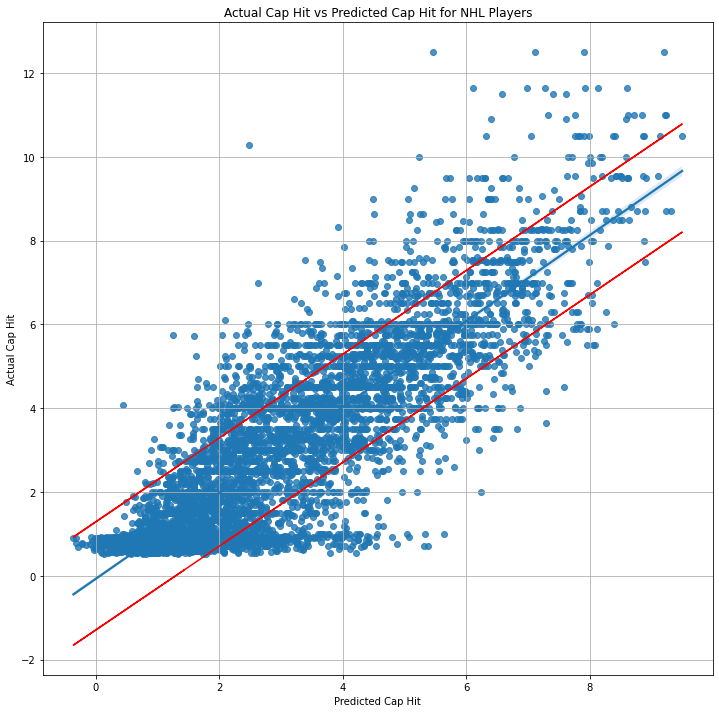

In [395]:
plt.figure(figsize = (12,12))

sns.regplot(x='Predicted Cap Hit',
            y='Actual Cap Hit',
            data = xgb_predict_df,
            marker = 'o')

plt.plot(xgb_predict_df['Predicted Cap Hit'],xgb_predict_df['Upper Limit'], color = 'red')
plt.plot(xgb_predict_df['Predicted Cap Hit'],xgb_predict_df['Lower Limit'], color = 'red')

plt.title('Actual Cap Hit vs Predicted Cap Hit for NHL Players')
plt.xlabel('Predicted Cap Hit')
plt.ylabel('Actual Cap Hit')
plt.grid()

plt.show()

Here we see some interesting trends on how our model is 'missing' it's predictions.

The area below the red lines are players that the model predicted would have a higher salary than they actually do ('underpaid').  There is a very significant number who would have been expected to make between 2-4 million, but are actually making less than 1 million.  This could point to young players who have significantly outperformed their rookie or 'minimum' contracts.

The area above the red lines are players that the model predicted would have a lower salary than they actually do ('overpaid').  These incorrect predictions seem to be spread a bit more evenly that the 'underpaid' predictions, but there does seem to be a concentration of players being paid 4-6 million that the model predicted would be paid 2-4 million.

Let's look at the players that missed our predictions by the most.

In [170]:
xgb_predict_df[['Player', 'Age', 'Year']] = clean_df[['Player', 'Age', 'Year']]

First, these are the Top 10 Underpaid Players according to this model.

In [171]:
xgb_predict_df.sort_values('Amount Missed', ascending = False).head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
4709           0.700           5.382421     6.672915     4.091928   
631            1.000           5.643685     6.934179     4.353191   
2219           0.700           5.314263     6.604757     4.023769   
1691           1.000           5.332494     6.622988     4.042000   
2750           2.000           6.232582     7.523076     4.942088   
2872           0.925           5.076278     6.366772     3.785784   
2935           0.750           4.876474     6.166968     3.585980   
4689           1.000           5.030213     6.320707     3.739719   
510            0.925           4.787693     6.078187     3.497199   
2574           0.700           4.534217     5.824711     3.243723   

      Amount Missed                 Player  Age  Year  
4709       4.682421        patrick marleau   40  2020  
631        4.643685             brad boyes   30  2013  
2219       4.614263         ilya kovalchuk   36  2020  
1691       4.332494        derick brassard   32  2021  
2750       4.232582           joe thornton   40  2020  
2872       4.151278        johnny gaudreau   22  2016  
2935       4.126474  jonathan marchessault   26  2018  
4689       4.030213          patrick eaves   32  2017  
510        3.862693        auston matthews   19  2018  
2574       3.834217           jason spezza   37  2021

This list are the players whose cap hits the model overestimated, intimating that these players were underpaid.  There are a mix of players and reasons why they may have been missed by the model.

Johnny Gaudreau, Auston Matthews and Jonathan Marchessault are young players over performing on their rookie contracts (which are limited to a maximum of $1 million in the first 3 years of their contract)

The rest are veteran players, 30 years and older, that look like did not earn a high paying contract, but then significantly out performed the near-minimum contract that they did get.

Derick Brassard is an interesting inclusion here.  During the Data Cleaning phase, we identified Derick Brassard as having the WORST `GAR` recorded in our dataset for his 2017 season, intimating that he had the worst single season of any player in the last 10 years!  It looks like he was able to get back on track, after getting a lower paying contract, and significantly outperform his contract in 2021.

In general, this could be a sign that it is worth making low-risk gambles on veterans who have shown production at some point in their careers, particularly if the cost is less than $2 million.

Now let's look at the most 'overpaid'.

In [172]:
xgb_predict_df.sort_values('Amount Missed').head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
6102          10.278           2.480870     3.771364     1.190376   
1361          12.500           5.465597     6.756091     4.175103   
512           11.634           6.113905     7.404399     4.823411   
1362          12.500           7.112248     8.402742     5.821754   
1997          11.500           6.580772     7.871266     5.290278   
2270          10.000           5.237596     6.528090     3.947102   
488           11.643           6.977637     8.268131     5.687143   
1363          12.500           7.907711     9.198204     6.617217   
2656           9.000           4.482428     5.772922     3.191934   
4245          10.893           6.391885     7.682379     5.101391   

      Amount Missed            Player  Age  Year  
6102      -7.797130  william nylander   22  2019  
1361      -7.034403    connor mcdavid   21  2019  
512       -5.520095   auston matthews   21  2020  
1362      -5.387752    connor mcdavid   22  2020  
1997      -4.919228     erik karlsson   31  2022  
2270      -4.762404       jack eichel   21  2019  
488       -4.665363    artemi panarin   28  2021  
1363      -4.592289    connor mcdavid   23  2021  
2656      -4.517572      jeff skinner   28  2021  
4245      -4.501115      mitch marner   22  2020

All of the most underestimated Cap Hits here are from players who had massive deals ($6 million or more) and did not perform to the level of the contract.  Many of these players had a predicted cap hit that was high for all of these players (mostly bover 3 million), just not to the level of their actual cap hit.

Another common theme is that many of these players are very young (23 and under).  It could have been that these are players who were great prospects and ended up signing huge long-term contracts before reaching their peak years, making teams pay early in hopes of better production later in their deal.  Auston Matthews would be an example of this showing up on BOTH lists.

Interestingly, Connor McDavid, widely regarded as the best player in the league currently and he shows up on this list a total of THREE times!  Considering that these are some of the most offensively productive seasons collected, I'm interested to see which seasons the model gave the highest Predicted Cap Hits to.

In [397]:
xgb_predict_df.sort_values('Predicted Cap Hit', ascending = False).head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
4699          10.500           9.493566    10.784060     8.203072   
5448           8.700           9.307359    10.597853     8.016865   
2857          11.000           9.237207    10.527701     7.946713   
5452           8.700           9.229172    10.519666     7.938678   
2856          11.000           9.212456    10.502950     7.921962   
1364          12.500           9.201039    10.491533     7.910545   
4700          10.500           9.141337    10.431831     7.850843   
197            9.538           9.106882    10.397376     7.816388   
2027           9.500           8.904400    10.194894     7.613906   
5450           8.700           8.898499    10.188993     7.608006   

      Amount Missed          Player  Age  Year  
4699      -1.006434    patrick kane   30  2020  
5448       0.607359   sidney crosby   29  2017  
2857      -1.762793    john tavares   30  2022  
5452       0.529172   sidney crosby   33  2021  
2856      -1.787544    john tavares   29  2021  
1364      -3.298961  connor mcdavid   24  2022  
4700      -1.358663    patrick kane   31  2021  
197       -0.431118   alex ovechkin   34  2021  
2027      -0.595600   evgeni malkin   30  2017  
5450       0.198499   sidney crosby   31  2019

This XGBoost model did not predict ANY Cap Hit to be over 9.5 million.  This would suggest, based on the spread of statistics across all players in the league, that perhaps no matter how historically good a player is, or how good of a season they're having, NO ONE in the league is worth more than 10 million.

This is fairly profound insight in regards to an NHL team trying to build their roster for success.  In fact, for these predicted Cap Hits, Sidney Crosby (who is on this list three times) is the only one that 'outperform' his actual cap hit and is the only one paid less than $9 million.  Perhaps a better team building strategy is not to pay out these 'super' contracts and instead invest that money into multiple players to have more depth on the team.

That being said, it is important to keep in mind that while this was the best performing model, the statistics only accounts for 67% of the variance in the data, still leaving 33% unexplained.  Perhaps overpaying for these players based on their stats brings other qualities that are not measured in this data (ie. leadership, marketing opportunities for the team, good will with the fans, etc.). However, if the ONLY thing that matters to a team is the level of performance on the ice, then the team-building strategy to build depth rather than stars may be worth considering.

### Feature Selection Through PCA

<a id = 'feature'></a>

Prior to running our data through PCA, I want to be selective in the features that are chosen in order to disregard stats that have not been predictive to the player's `Cap_Hit` up to this point.

In order to do so, we will be able to identify our most important features by:
1. Looking at the coefficients of our Lasso Regression model
2. Looking at the Gain of our features from our XGBoost model
3. Looking at the SHAP values from our XGBoost model
4. Looking at the F-Score of our features (and confirming they are statistically significant)

First, we will have a look at the coefficients of our Ridge Regression

In [404]:
lasso_mod2.coef_

array([ 2.06217728e-01, -3.66967176e-03, -8.41598442e-02,  7.11754894e-03,
        1.09592831e-02,  4.70798095e-02, -1.85741867e-02, -2.54690245e-02,
       -1.37057624e-01,  6.88813174e-01, -3.83910070e-02, -2.57736532e-02,
       -3.10639946e-02, -2.82478684e-02,  2.50219176e-03,  3.97567904e-02,
        4.63450934e-02,  3.70541577e-01, -1.72259169e+00, -5.65740358e-02,
       -5.99860226e-02, -1.46468558e-02,  1.15061700e-02,  7.84007660e-01,
       -1.87372434e-01, -5.02797993e-02,  1.27710241e+00,  8.66934331e-01,
       -1.97939617e-02, -2.47212544e-02, -0.00000000e+00,  5.36377966e-01,
       -1.45508128e+00, -1.19207364e+00,  0.00000000e+00,  1.28478846e+00,
       -0.00000000e+00, -6.65668019e-01,  7.60081884e-02,  3.77562471e-02,
        1.82668643e-01,  2.26770874e-01, -3.07328584e-01, -8.35344475e-02,
        8.12838997e-02,  6.77636765e-02,  1.61380663e-01, -1.56898212e-03,
       -1.29428918e+00,  2.16970494e-01,  8.89068658e-02, -1.18121057e-03,
        2.23741698e-02,  

In [405]:
#Create dataframe using identifying these coefficients with the features
lasso_df = (pd.DataFrame({'coef':lasso_mod2.coef_, 'feature':X_train.columns})
            .set_index('feature'))

In [406]:
lasso_df

coef
feature                
Age            0.206218
Draft Ov      -0.003670
GP            -0.084160
TOI            0.007118
GF%            0.010959
SF%            0.047080
FF%           -0.018574
CF%           -0.025469
xGF%          -0.137058
GF/60          0.688813
GA/60         -0.038391
SF/60         -0.025774
SA/60         -0.031064
FF/60         -0.028248
FA/60          0.002502
CF/60          0.039757
CA/60          0.046345
xGF/60         0.370542
xGA/60        -1.722592
G±/60         -0.056574
S±/60         -0.059986
F±/60         -0.014647
C±/60          0.011506
xG±/60         0.784008
oiSh%         -0.187372
Sv%           -0.050280
xEVO_GAR/60    1.277102
xEVD_GAR/60    0.866934
xPPO_GAR/60   -0.019794
xSHD_GAR/60   -0.024721
xTake_GAR/60  -0.000000
xDraw_GAR/60   0.536378
xOff_GAR/60   -1.455081
xDef_GAR/60   -1.192074
xPens_GAR/60   0.000000
xGAR/60        1.284788
xWAR/60       -0.000000
xSPAR/60      -0.665668
xEVO_GAR       0.076008
xEVD_GAR       0.037756
xPPO_GAR       0.182669
xSHD_GAR       0.226771
xTake_GAR     -0.307329
xDraw_GAR     -0.083534
xOff_GAR       0.081284
xDef_GAR       0.067764
xPens_GAR      0.161381
xGAR          -0.001569
xWAR          -1.294289
xSPAR          0.216970
iSF/60         0.088907
iFF/60        -0.001181
iCF/60         0.022374
ixG/60         1.007109
Sh%           -0.005048
GIVE/60        0.056685
TAKE/60        0.141857
iPENT2/60      0.068024
iPEND2/60      0.058988
iPENT5/60      0.065206
iPEND5/60      0.000000
iPEN±/60      -0.463697
FOW/60        -0.014750
FOL/60         0.001351
FO±/60        -0.040871
iPENT5         0.064766
iPEND5        -0.032840
iPEN±          0.023943
FOW            0.001138
FOL           -0.000251
FO±            0.005507
GF             0.025722
GA            -0.006851
SF             0.002185
SA            -0.000044
FF            -0.001644
FA            -0.000847
CF            -0.002080
CA            -0.001904
xGF            0.057498
xGA            0.020284
G±            -0.006123
S±             0.000373
F±             0.000524
C±             0.001041
xG±           -0.062303
TOI_All       -0.000278
TOI_EV        -0.003520
TOI_PP        -0.002192
TOI_SH        -0.005046
EVO_GAR        0.005758
EVD_GAR        0.140720
PPO_GAR       -0.035087
SHD_GAR       -0.000000
Take_GAR       0.240755
Off_GAR        0.005264
Def_GAR        0.039113
GAR           -0.016496
WAR           -0.349569
SPAR          -0.006996
EVO_GAR/60    -0.523137
EVD_GAR/60    -0.670680
PPO_GAR/60     0.005888
SHD_GAR/60     0.002365
Take_GAR/60   -0.000000
Draw_GAR/60    0.000000
Off_GAR/60    -0.193167
Def_GAR/60    -1.378347
Pens_GAR/60    0.260583
GAR/60         0.853714
WAR/60         0.000000
SPAR/60        0.000000
Year           0.066072
log_G/60       1.259803
log_A1/60      3.284957
log_A2/60      2.980853
log_Points/60 -6.323596
log_FSh%      -0.006790
log_iBLK/60   -0.925016
log_iHF/60     0.431832
log_iHA/60    -1.493646
log_G          0.116141
log_A1        -0.145681
log_A2        -0.113649
log_Points     1.339836
log_iSF       -0.765958
log_iFF        0.453213
log_iCF       -0.125134
log_ixG       -0.088741
log_iBLK       0.561773
log_GIVE       0.037337
log_TAKE      -0.138891
log_iHF       -0.331828
log_iHA        0.943029
log_iPENT2    -0.073065
log_iPEND2     0.122032
log_xFSh%     -0.034161
Left_Handed    0.010606
Defenceman    -0.557698

In [407]:
pd.set_option('display.max_rows', None)

In [408]:
lasso_df.sort_values('coef')

coef
feature                
log_Points/60 -6.323596
xGA/60        -1.722592
log_iHA/60    -1.493646
xOff_GAR/60   -1.455081
Def_GAR/60    -1.378347
xWAR          -1.294289
xDef_GAR/60   -1.192074
log_iBLK/60   -0.925016
log_iSF       -0.765958
EVD_GAR/60    -0.670680
xSPAR/60      -0.665668
Defenceman    -0.557698
EVO_GAR/60    -0.523137
iPEN±/60      -0.463697
WAR           -0.349569
log_iHF       -0.331828
xTake_GAR     -0.307329
Off_GAR/60    -0.193167
oiSh%         -0.187372
log_A1        -0.145681
log_TAKE      -0.138891
xGF%          -0.137058
log_iCF       -0.125134
log_A2        -0.113649
log_ixG       -0.088741
GP            -0.084160
xDraw_GAR     -0.083534
log_iPENT2    -0.073065
xG±           -0.062303
S±/60         -0.059986
G±/60         -0.056574
Sv%           -0.050280
FO±/60        -0.040871
GA/60         -0.038391
PPO_GAR       -0.035087
log_xFSh%     -0.034161
iPEND5        -0.032840
SA/60         -0.031064
FF/60         -0.028248
SF/60         -0.025774
CF%           -0.025469
xSHD_GAR/60   -0.024721
xPPO_GAR/60   -0.019794
FF%           -0.018574
GAR           -0.016496
FOW/60        -0.014750
F±/60         -0.014647
SPAR          -0.006996
GA            -0.006851
log_FSh%      -0.006790
G±            -0.006123
Sh%           -0.005048
TOI_SH        -0.005046
Draft Ov      -0.003670
TOI_EV        -0.003520
TOI_PP        -0.002192
CF            -0.002080
CA            -0.001904
FF            -0.001644
xGAR          -0.001569
iFF/60        -0.001181
FA            -0.000847
TOI_All       -0.000278
FOL           -0.000251
SA            -0.000044
iPEND5/60      0.000000
SPAR/60        0.000000
WAR/60         0.000000
xPens_GAR/60   0.000000
Draw_GAR/60    0.000000
Take_GAR/60   -0.000000
xWAR/60       -0.000000
SHD_GAR       -0.000000
xTake_GAR/60  -0.000000
S±             0.000373
F±             0.000524
C±             0.001041
FOW            0.001138
FOL/60         0.001351
SF             0.002185
SHD_GAR/60     0.002365
FA/60          0.002502
Off_GAR        0.005264
FO±            0.005507
EVO_GAR        0.005758
PPO_GAR/60     0.005888
TOI            0.007118
Left_Handed    0.010606
GF%            0.010959
C±/60          0.011506
xGA            0.020284
iCF/60         0.022374
iPEN±          0.023943
GF             0.025722
log_GIVE       0.037337
xEVD_GAR       0.037756
Def_GAR        0.039113
CF/60          0.039757
CA/60          0.046345
SF%            0.047080
GIVE/60        0.056685
xGF            0.057498
iPEND2/60      0.058988
iPENT5         0.064766
iPENT5/60      0.065206
Year           0.066072
xDef_GAR       0.067764
iPENT2/60      0.068024
xEVO_GAR       0.076008
xOff_GAR       0.081284
iSF/60         0.088907
log_G          0.116141
log_iPEND2     0.122032
EVD_GAR        0.140720
TAKE/60        0.141857
xPens_GAR      0.161381
xPPO_GAR       0.182669
Age            0.206218
xSPAR          0.216970
xSHD_GAR       0.226771
Take_GAR       0.240755
Pens_GAR/60    0.260583
xGF/60         0.370542
log_iHF/60     0.431832
log_iFF        0.453213
xDraw_GAR/60   0.536378
log_iBLK       0.561773
GF/60          0.688813
xG±/60         0.784008
GAR/60         0.853714
xEVD_GAR/60    0.866934
log_iHA        0.943029
ixG/60         1.007109
log_G/60       1.259803
xEVO_GAR/60    1.277102
xGAR/60        1.284788
log_Points     1.339836
log_A2/60      2.980853
log_A1/60      3.284957

In [409]:
lasso_df[(lasso_df['coef'] > -0.05) & (lasso_df['coef'] < 0.05)].count()

coef    68
dtype: int64

log_Points/60 has a very large (relative to others) negative correlation, which is a bit of a surprise.  At the other end, log_A1 and log_A2 have the largest postitive coefficeints.  Considering that Points are, in part, calculated by counting assists (A1 and A2), these factors seem to balance opposite ends of the scale when it comes to determining the cap hit of the players.

We have a coefficient range between -6.32 and +3.28.  We have 68 features that fall between -0.05 and +0.05 and had small effects on the lasso regression model.  These may be be ideal features to drop as we pinpoint factors that are better predictors of Cap_Hit.

Next, I want to get a sense of the factors that have importance in developing the XGBoost model.

We will do this by using plot_importance to plot the Gain of each feature relative to Cap_Hit.

In [179]:
from xgboost import plot_importance

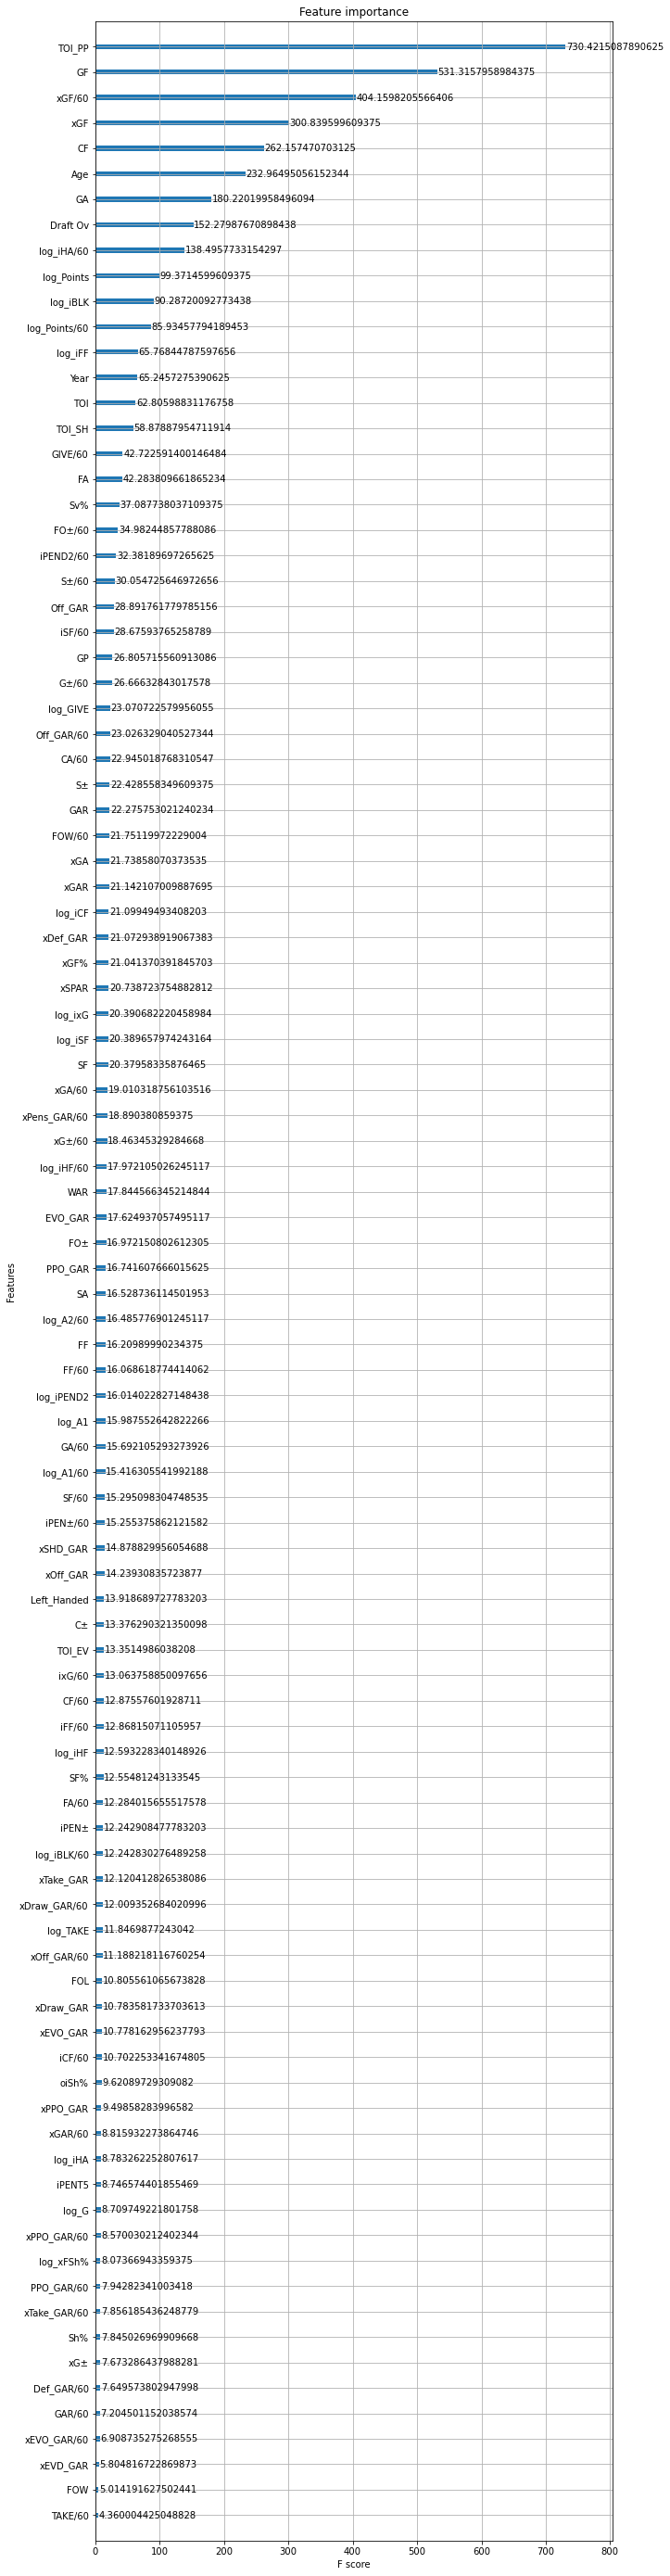

In [180]:
ax = plot_importance(xgb6, importance_type = 'gain' )
fig = ax.figure
fig.set_size_inches(10, 50)
plt.show()

Here it is very apparent the importance of offensive statistics, in particular for Goals For (both in total and as a rating with Expected Goals For) and Time on Ice for the Power Play.

Goals Against is the only major defensive metrics near the lop of this list (7th) but no other defensive metrics, especially the advanced ones, with a Gain value higher than 25.

Next we will see how the SHAP values to get further insight on what features had the biggest impact on the XGBoost model.

In [533]:
import shap
shap.initjs() #needs to be run in order to initiate the library

In [182]:
explainer = shap.TreeExplainer(xgb6)

In [183]:
shap_values = explainer(X)

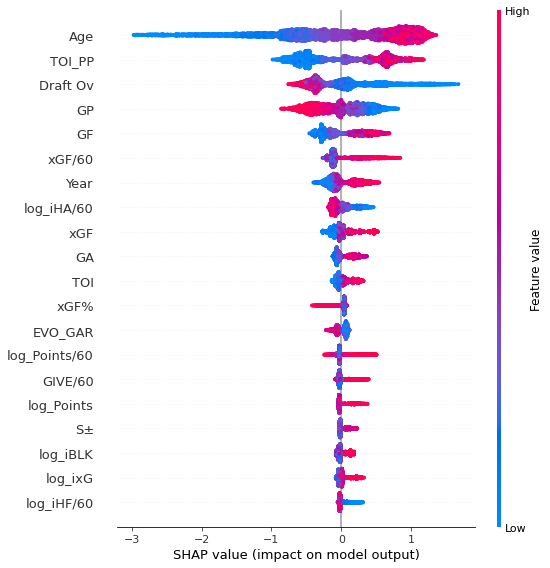

In [184]:
shap.summary_plot(shap_values, X)

With this visual we can see areas in red that had a high SHAP value in impacting the XGBoost model, and the thickness of the line is the value count of data points within this range.

This confirms that along with Age, Time on Ice for the Power Play and Goals For metrics are of the greatest value.  We see here that the lower number that someone was drafted has a big importance in the model as well.  Next we will look at the weights of the features in the xgb model.

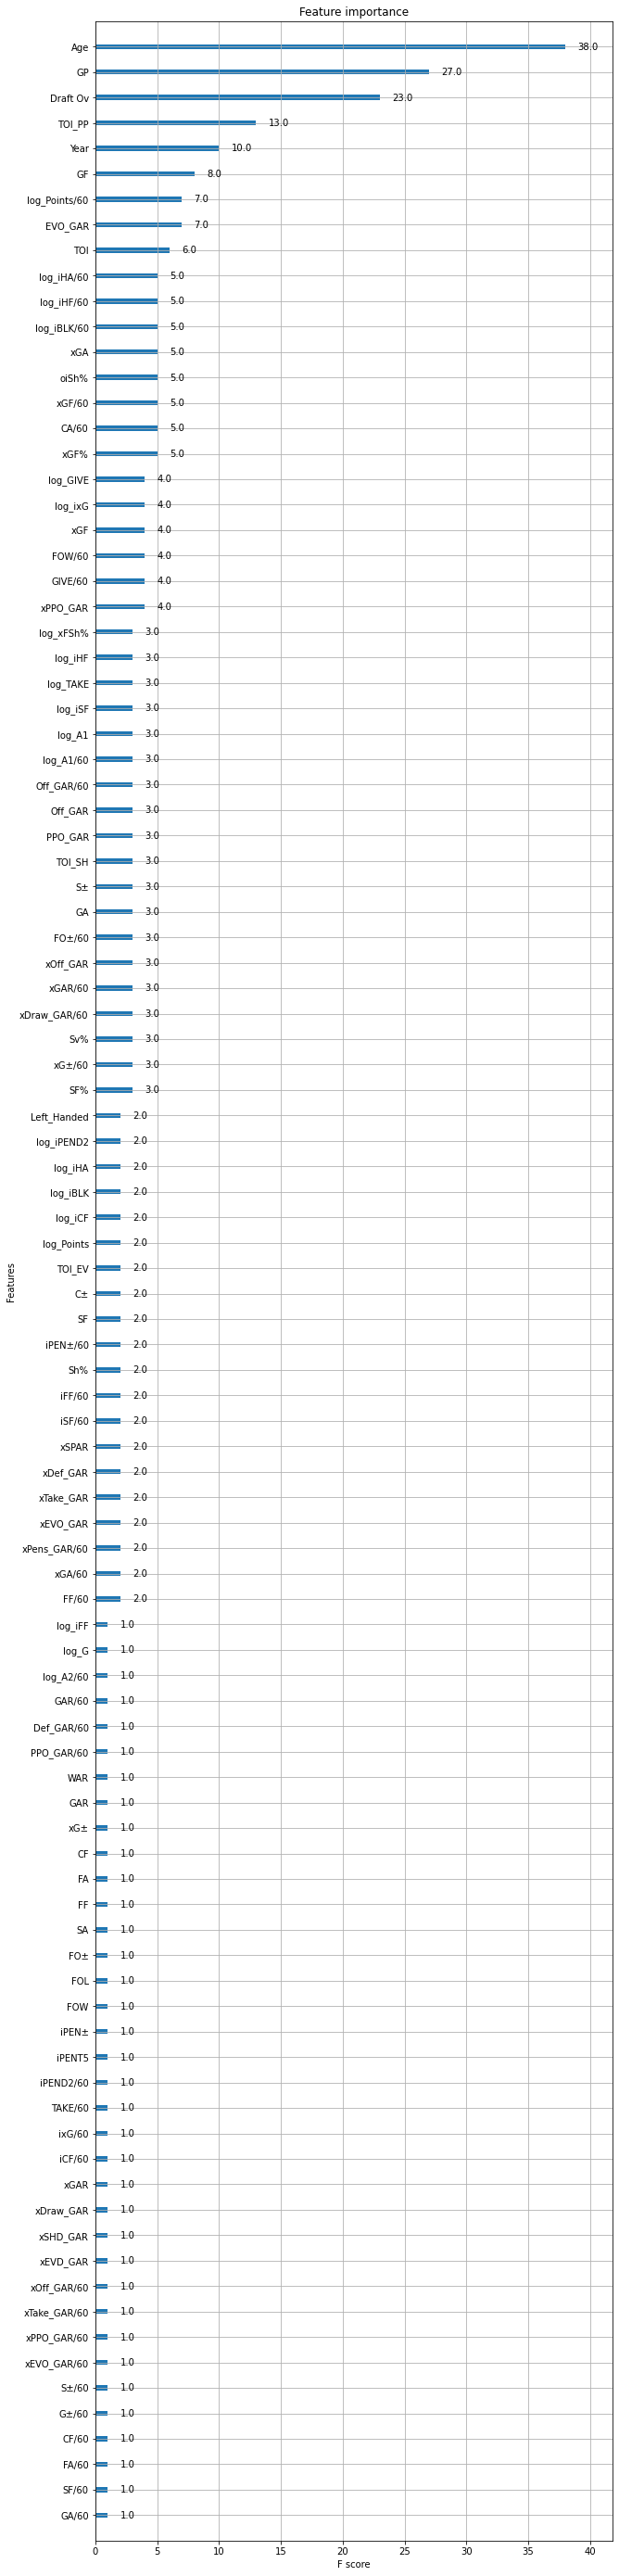

In [185]:
ax = plot_importance(xgb6, importance_type = 'weight')
fig = ax.figure
fig.set_size_inches(10, 50)
plt.show()

Age, Games Played, Time On Ice (Power Play) and Draft Pick Position all have heavy 'weights' on the model.

individual Hits Against/60 minutes and Hits For/60 Minutes both have some importance too, potentially as negative correlations based on the initial EDA.

Looking at this list, I think a decision needs to be made in regards to whether I keep stat *totals* (ie. Goals), stat *rates* (ie. Goals/60) or both.  Looking at this list it would appear that the *rating* stats are more predictive than the *total* stats.  For instance, log_Points/60 has an F Score of 10, but the log_Points is half of that.  Half of the features in the top 50 are rating stats.

**I want to ensure that all of these stats have coefficients that are statistically significant with Cap_Hit.**  We will do this by using f_regression to get the p-value of the f-tests across all of the features as they relate to Cap_Hit

In [186]:
from sklearn.feature_selection import f_regression

In [187]:
f_scores = f_regression(X_train, y_train)

In [188]:
f_scores

(array([8.10494232e+02, 3.38152920e+02, 2.61733937e+02, 1.31381076e+03,
        4.97909951e+02, 6.15295270e+02, 6.09562868e+02, 6.25397482e+02,
        5.77875319e+02, 1.53299494e+03, 6.94202074e+01, 1.10967864e+03,
        7.24523409e+01, 1.05802770e+03, 1.05744530e+02, 9.58459660e+02,
        1.88493422e+02, 1.81250817e+03, 8.64067114e+01, 5.99217882e+02,
        6.53757972e+02, 6.45539558e+02, 6.55900437e+02, 6.68176548e+02,
        8.41291267e+02, 2.77025525e+02, 4.36863575e+02, 2.16711379e+01,
        2.53537499e+02, 1.09629948e-01, 1.89823709e+01, 3.83691792e+00,
        5.70812637e+02, 2.16276334e+01, 3.90259216e+00, 2.78001748e+02,
        2.71177687e+02, 2.71661625e+02, 6.88206241e+02, 2.06475071e+01,
        6.84014890e+02, 4.40740176e-01, 8.13985133e+01, 1.30316162e+00,
        9.81026933e+02, 1.89020035e+01, 3.97497352e+01, 6.08762616e+02,
        5.91554649e+02, 5.93814984e+02, 3.34139633e+02, 3.45562051e+02,
        4.30874397e+02, 2.53783675e+02, 1.50343779e+02, 2.839137

In [189]:
#Create data frame to connect the F-Scores and P-Values to the proper feature
f_scores_df = pd.DataFrame(columns = X.columns,
                           index = (['F-Scores', 'P-Values']),
                           data = f_scores)

In [411]:
f_scores_df

Age      Draft Ov            GP            TOI  \
F-Scores   8.104942e+02  3.381529e+02  2.617339e+02   1.313811e+03   
P-Values  1.586928e-164  5.762300e-73  2.540412e-57  1.062400e-253   

                    GF%            SF%            FF%            CF%  \
F-Scores   4.979100e+02   6.152953e+02   6.095629e+02   6.253975e+02   
P-Values  6.954374e-105  1.063075e-127  1.345030e-126  1.222254e-129   

                   xGF%          GF/60         GA/60          SF/60  \
F-Scores   5.778753e+02   1.532995e+03  6.942021e+01   1.109679e+03   
P-Values  1.751027e-120  3.350180e-290  1.035011e-16  1.773605e-218   

                 SA/60          FF/60         FA/60          CF/60  \
F-Scores  7.245234e+01   1.058028e+03  1.057445e+02   9.584597e+02   
P-Values  2.277634e-17  2.287310e-209  1.530315e-24  1.436214e-191   

                 CA/60       xGF/60        xGA/60          G±/60  \
F-Scores  1.884934e+02  1812.508167  8.640671e+01   5.992179e+02   
P-Values  4.412985e-42     0.000000  2.194519e-20  1.320801e-124   

                  S±/60          F±/60          C±/60         xG±/60  \
F-Scores   6.537580e+02   6.455396e+02   6.559004e+02   6.681765e+02   
P-Values  4.597805e-135  1.704105e-133  1.794502e-135  8.238985e-138   

                  oiSh%           Sv%   xEVO_GAR/60  xEVD_GAR/60  \
F-Scores   8.412913e+02  2.770255e+02  4.368636e+02    21.671138   
P-Values  3.248617e-170  1.794776e-60  8.268841e-93     0.000003   

           xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
F-Scores  2.535375e+02     0.109630     18.982371      3.836918   
P-Values  1.253488e-55     0.740581      0.000013      0.050195   

            xOff_GAR/60  xDef_GAR/60  xPens_GAR/60       xGAR/60  \
F-Scores   5.708126e+02    21.627633      3.902592  2.780017e+02   
P-Values  4.085522e-119     0.000003      0.048270  1.130337e-60   

               xWAR/60      xSPAR/60       xEVO_GAR   xEVD_GAR       xPPO_GAR  \
F-Scores  2.711777e+02  2.716616e+02   6.882062e+02  20.647507   6.840149e+02   
P-Values  2.869142e-59  2.280756e-59  1.296406e-141   0.000006  8.079437e-141   

          xSHD_GAR     xTake_GAR  xDraw_GAR       xOff_GAR   xDef_GAR  \
F-Scores  0.440740  8.139851e+01   1.303162   9.810269e+02  18.902004   
P-Values  0.506798  2.642983e-19   0.253695  1.246481e-195   0.000014   

             xPens_GAR           xGAR           xWAR          xSPAR  \
F-Scores  3.974974e+01   6.087626e+02   5.915546e+02   5.938150e+02   
P-Values  3.153476e-10  1.917312e-126  3.972705e-123  1.454914e-123   

                iSF/60        iFF/60        iCF/60        ixG/60  \
F-Scores  3.341396e+02  3.455621e+02  4.308744e+02  2.537837e+02   
P-Values  3.766357e-72  1.807888e-74  1.288506e-91  1.114862e-55   

                   Sh%       GIVE/60       TAKE/60     iPENT2/60  \
F-Scores  1.503438e+02  2.839137e+02  5.391992e+01  4.402261e+01   
P-Values  4.847286e-34  6.887395e-62  2.451243e-13  3.615585e-11   

             iPEND2/60     iPENT5/60     iPEND5/60  iPEN±/60        FOW/60  \
F-Scores  3.273382e+01  1.356850e+02  1.368715e+02  0.673266  8.017551e+01   
P-Values  1.122829e-08  6.241561e-31  3.492546e-31  0.411957  4.856251e-19   

                FOL/60        FO±/60        iPENT5        iPEND5     iPEN±  \
F-Scores  3.889823e+01  1.891664e+02  9.231449e+01  9.268195e+01  0.603592   
P-Values  4.859555e-10  3.188137e-42  1.171647e-21  9.766229e-22  0.437250   

                   FOW           FOL           FO±           GF  \
F-Scores  2.529055e+02  1.926576e+02  1.863946e+02  2366.438212   
P-Values  1.693609e-55  5.908271e-43  1.216771e-41     0.000000   

                     GA           SF             SA           FF  \
F-Scores   1.193034e+03  1957.924518   9.656501e+02  1916.625263   
P-Values  5.217712e-233     0.000000  7.266735e-193     0.000000   

                     FA          CF             CA          xGF  \
F-Scores   9.256439e+02  1858.81162   8.478563e+02  2358.785154   
P-Values  1.237552e-185     0.0000

In [190]:
#For loop to identify which features do not have a statistically significant relationship with Cap Hit
insignificant_stats = []
for col in X.columns:
    if f_scores_df[col].loc['P-Values'] >= 0.05:
        insignificant_stats.append(col)
        print(col)

xSHD_GAR/60
xDraw_GAR/60
xSHD_GAR
xDraw_GAR
iPEN±/60
iPEN±
SHD_GAR
SHD_GAR/60
Draw_GAR/60
Left_Handed
Defenceman


Interestingly, it would appear that there is no significant variance for the position of the player as it relates to Cap_Hit.

Drawing penalties, number of penalties taken and Defensive stats while shorthanded are common themes in this list.

It is clear that there is significant multi-collinearity issues and features overlap in what they are measuring.  At the same time, there appears to be some features that are more important to the Lasso regression, while others were more important to the XGBoost model.  In order to select features that are going to be important for future modeling, we will try to get the best from both models:

1. We will drop features that have a coefficient of -0.1 to +0.1 in our Lasso Regression model...
2. If the Feature Importance in the XGBoost model = 0
3. And Features that do not have a statistically significant relationship with Cap Hit

In [191]:
xgb6.feature_importances_

array([0.0483584 , 0.03160996, 0.00556428, 0.01303714, 0.        ,
       0.0026061 , 0.        , 0.        , 0.00436773, 0.        ,
       0.00325734, 0.00317493, 0.        , 0.00333549, 0.00254989,
       0.00267269, 0.00476288, 0.08389469, 0.00394612, 0.00553534,
       0.0062387 , 0.        , 0.        , 0.00383261, 0.00199709,
       0.0076986 , 0.0014341 , 0.        , 0.00177895, 0.        ,
       0.00163077, 0.00249288, 0.00232243, 0.        , 0.00392123,
       0.00182999, 0.        , 0.        , 0.00223731, 0.00120495,
       0.0019717 , 0.00308852, 0.00251593, 0.00223843, 0.00295577,
       0.00437428, 0.        , 0.00438864, 0.        , 0.0043049 ,
       0.00595249, 0.00267115, 0.00222155, 0.00271175, 0.00162846,
       0.00886827, 0.00090504, 0.        , 0.00672177, 0.        ,
       0.        , 0.00316668, 0.00451507, 0.        , 0.00726159,
       0.0018156 , 0.        , 0.00254136, 0.00104084, 0.002243  ,
       0.00352305, 0.11028948, 0.03740975, 0.00423035, 0.00343

In [192]:
#Create dataframe using identifying the feature importance with the features themselves
important_df = (pd.DataFrame({'importance':xgb6.feature_importances_, 'feature':X_train.columns})).set_index('feature')

In [193]:
important_df

importance
feature                  
Age              0.048358
Draft Ov         0.031610
GP               0.005564
TOI              0.013037
GF%              0.000000
SF%              0.002606
FF%              0.000000
CF%              0.000000
xGF%             0.004368
GF/60            0.000000
GA/60            0.003257
SF/60            0.003175
SA/60            0.000000
FF/60            0.003335
FA/60            0.002550
CF/60            0.002673
CA/60            0.004763
xGF/60           0.083895
xGA/60           0.003946
G±/60            0.005535
S±/60            0.006239
F±/60            0.000000
C±/60            0.000000
xG±/60           0.003833
oiSh%            0.001997
Sv%              0.007699
xEVO_GAR/60      0.001434
xEVD_GAR/60      0.000000
xPPO_GAR/60      0.001779
xSHD_GAR/60      0.000000
xTake_GAR/60     0.001631
xDraw_GAR/60     0.002493
xOff_GAR/60      0.002322
xDef_GAR/60      0.000000
xPens_GAR/60     0.003921
xGAR/60          0.001830
xWAR/60          0.000000
xSPAR/60         0.000000
xEVO_GAR         0.002237
xEVD_GAR         0.001205
xPPO_GAR         0.001972
xSHD_GAR         0.003089
xTake_GAR        0.002516
xDraw_GAR        0.002238
xOff_GAR         0.002956
xDef_GAR         0.004374
xPens_GAR        0.000000
xGAR             0.004389
xWAR             0.000000
xSPAR            0.004305
iSF/60           0.005952
iFF/60           0.002671
iCF/60           0.002222
ixG/60           0.002712
Sh%              0.001628
GIVE/60          0.008868
TAKE/60          0.000905
iPENT2/60        0.000000
iPEND2/60        0.006722
iPENT5/60        0.000000
iPEND5/60        0.000000
iPEN±/60         0.003167
FOW/60           0.004515
FOL/60           0.000000
FO±/60           0.007262
iPENT5           0.001816
iPEND5           0.000000
iPEN±            0.002541
FOW              0.001041
FOL              0.002243
FO±              0.003523
GF               0.110289
GA               0.037410
SF               0.004230
SA               0.003431
FF               0.003365
FA               0.008777
CF               0.054418
CA               0.000000
xGF              0.062448
xGA              0.004512
G±               0.000000
S±               0.004656
F±               0.000000
C±               0.002777
xG±              0.001593
TOI_All          0.000000
TOI_EV           0.002771
TOI_PP           0.151619
TOI_SH           0.012222
EVO_GAR          0.003659
EVD_GAR          0.000000
PPO_GAR          0.003475
SHD_GAR          0.000000
Take_GAR         0.000000
Off_GAR          0.005997
Def_GAR          0.000000
GAR              0.004624
WAR              0.003704
SPAR             0.000000
EVO_GAR/60       0.000000
EVD_GAR/60       0.000000
PPO_GAR/60       0.001649
SHD_GAR/60       0.000000
Take_GAR/60      0.000000
Draw_GAR/60      0.000000
Off_GAR/60       0.004780
Def_GAR/60       0.001588
Pens_GAR/60      0.000000
GAR/60           0.001495
WAR/60           0.000000
SPAR/60          0.000000
Year             0.013544
log_G/60         0.000000
log_A1/60        0.003200
log_A2/60        0.003422
log_Points/60    0.017838
log_FSh%         0.000000
log_iBLK/60      0.002541
log_iHF/60       0.003731
log_iHA/60       0.028749
log_G            0.001808
log_A1           0.003319
log_A2           0.000000
log_Points       0.020627
log_iSF          0.004232
log_iFF          0.013652
log_iCF          0.004380
log_ixG          0.004233
log_iBLK         0.018742
log_GIVE         0.004789
log_TAKE         0.002459
log_iHF          0.002614
log_iHA          0.001823
log_iPENT2       0.000000
log_iPEND2       0.003324
log_xFSh%        0.001676
Left_Handed      0.002889
Defenceman       0.000000

In [194]:
lasso_df

coef
feature                
Age            0.206218
Draft Ov      -0.003670
GP            -0.084160
TOI            0.007118
GF%            0.010959
SF%            0.047080
FF%           -0.018574
CF%           -0.025469
xGF%          -0.137058
GF/60          0.688813
GA/60         -0.038391
SF/60         -0.025774
SA/60         -0.031064
FF/60         -0.028248
FA/60          0.002502
CF/60          0.039757
CA/60          0.046345
xGF/60         0.370542
xGA/60        -1.722592
G±/60         -0.056574
S±/60         -0.059986
F±/60         -0.014647
C±/60          0.011506
xG±/60         0.784008
oiSh%         -0.187372
Sv%           -0.050280
xEVO_GAR/60    1.277102
xEVD_GAR/60    0.866934
xPPO_GAR/60   -0.019794
xSHD_GAR/60   -0.024721
xTake_GAR/60  -0.000000
xDraw_GAR/60   0.536378
xOff_GAR/60   -1.455081
xDef_GAR/60   -1.192074
xPens_GAR/60   0.000000
xGAR/60        1.284788
xWAR/60       -0.000000
xSPAR/60      -0.665668
xEVO_GAR       0.076008
xEVD_GAR       0.037756
xPPO_GAR       0.182669
xSHD_GAR       0.226771
xTake_GAR     -0.307329
xDraw_GAR     -0.083534
xOff_GAR       0.081284
xDef_GAR       0.067764
xPens_GAR      0.161381
xGAR          -0.001569
xWAR          -1.294289
xSPAR          0.216970
iSF/60         0.088907
iFF/60        -0.001181
iCF/60         0.022374
ixG/60         1.007109
Sh%           -0.005048
GIVE/60        0.056685
TAKE/60        0.141857
iPENT2/60      0.068024
iPEND2/60      0.058988
iPENT5/60      0.065206
iPEND5/60      0.000000
iPEN±/60      -0.463697
FOW/60        -0.014750
FOL/60         0.001351
FO±/60        -0.040871
iPENT5         0.064766
iPEND5        -0.032840
iPEN±          0.023943
FOW            0.001138
FOL           -0.000251
FO±            0.005507
GF             0.025722
GA            -0.006851
SF             0.002185
SA            -0.000044
FF            -0.001644
FA            -0.000847
CF            -0.002080
CA            -0.001904
xGF            0.057498
xGA            0.020284
G±            -0.006123
S±             0.000373
F±             0.000524
C±             0.001041
xG±           -0.062303
TOI_All       -0.000278
TOI_EV        -0.003520
TOI_PP        -0.002192
TOI_SH        -0.005046
EVO_GAR        0.005758
EVD_GAR        0.140720
PPO_GAR       -0.035087
SHD_GAR       -0.000000
Take_GAR       0.240755
Off_GAR        0.005264
Def_GAR        0.039113
GAR           -0.016496
WAR           -0.349569
SPAR          -0.006996
EVO_GAR/60    -0.523137
EVD_GAR/60    -0.670680
PPO_GAR/60     0.005888
SHD_GAR/60     0.002365
Take_GAR/60   -0.000000
Draw_GAR/60    0.000000
Off_GAR/60    -0.193167
Def_GAR/60    -1.378347
Pens_GAR/60    0.260583
GAR/60         0.853714
WAR/60         0.000000
SPAR/60        0.000000
Year           0.066072
log_G/60       1.259803
log_A1/60      3.284957
log_A2/60      2.980853
log_Points/60 -6.323596
log_FSh%      -0.006790
log_iBLK/60   -0.925016
log_iHF/60     0.431832
log_iHA/60    -1.493646
log_G          0.116141
log_A1        -0.145681
log_A2        -0.113649
log_Points     1.339836
log_iSF       -0.765958
log_iFF        0.453213
log_iCF       -0.125134
log_ixG       -0.088741
log_iBLK       0.561773
log_GIVE       0.037337
log_TAKE      -0.138891
log_iHF       -0.331828
log_iHA        0.943029
log_iPENT2    -0.073065
log_iPEND2     0.122032
log_xFSh%     -0.034161
Left_Handed    0.010606
Defenceman    -0.557698

In [195]:
#Combining the two measures to weed out lower impact features
feature_eval_df = pd.concat([important_df, lasso_df], axis = 1)

In [196]:
feature_eval_df

importance      coef
feature                            
Age              0.048358  0.206218
Draft Ov         0.031610 -0.003670
GP               0.005564 -0.084160
TOI              0.013037  0.007118
GF%              0.000000  0.010959
SF%              0.002606  0.047080
FF%              0.000000 -0.018574
CF%              0.000000 -0.025469
xGF%             0.004368 -0.137058
GF/60            0.000000  0.688813
GA/60            0.003257 -0.038391
SF/60            0.003175 -0.025774
SA/60            0.000000 -0.031064
FF/60            0.003335 -0.028248
FA/60            0.002550  0.002502
CF/60            0.002673  0.039757
CA/60            0.004763  0.046345
xGF/60           0.083895  0.370542
xGA/60           0.003946 -1.722592
G±/60            0.005535 -0.056574
S±/60            0.006239 -0.059986
F±/60            0.000000 -0.014647
C±/60            0.000000  0.011506
xG±/60           0.003833  0.784008
oiSh%            0.001997 -0.187372
Sv%              0.007699 -0.050280
xEVO_GAR/60      0.001434  1.277102
xEVD_GAR/60      0.000000  0.866934
xPPO_GAR/60      0.001779 -0.019794
xSHD_GAR/60      0.000000 -0.024721
xTake_GAR/60     0.001631 -0.000000
xDraw_GAR/60     0.002493  0.536378
xOff_GAR/60      0.002322 -1.455081
xDef_GAR/60      0.000000 -1.192074
xPens_GAR/60     0.003921  0.000000
xGAR/60          0.001830  1.284788
xWAR/60          0.000000 -0.000000
xSPAR/60         0.000000 -0.665668
xEVO_GAR         0.002237  0.076008
xEVD_GAR         0.001205  0.037756
xPPO_GAR         0.001972  0.182669
xSHD_GAR         0.003089  0.226771
xTake_GAR        0.002516 -0.307329
xDraw_GAR        0.002238 -0.083534
xOff_GAR         0.002956  0.081284
xDef_GAR         0.004374  0.067764
xPens_GAR        0.000000  0.161381
xGAR             0.004389 -0.001569
xWAR             0.000000 -1.294289
xSPAR            0.004305  0.216970
iSF/60           0.005952  0.088907
iFF/60           0.002671 -0.001181
iCF/60           0.002222  0.022374
ixG/60           0.002712  1.007109
Sh%              0.001628 -0.005048
GIVE/60          0.008868  0.056685
TAKE/60          0.000905  0.141857
iPENT2/60        0.000000  0.068024
iPEND2/60        0.006722  0.058988
iPENT5/60        0.000000  0.065206
iPEND5/60        0.000000  0.000000
iPEN±/60         0.003167 -0.463697
FOW/60           0.004515 -0.014750
FOL/60           0.000000  0.001351
FO±/60           0.007262 -0.040871
iPENT5           0.001816  0.064766
iPEND5           0.000000 -0.032840
iPEN±            0.002541  0.023943
FOW              0.001041  0.001138
FOL              0.002243 -0.000251
FO±              0.003523  0.005507
GF               0.110289  0.025722
GA               0.037410 -0.006851
SF               0.004230  0.002185
SA               0.003431 -0.000044
FF               0.003365 -0.001644
FA               0.008777 -0.000847
CF               0.054418 -0.002080
CA               0.000000 -0.001904
xGF              0.062448  0.057498
xGA              0.004512  0.020284
G±               0.000000 -0.006123
S±               0.004656  0.000373
F±               0.000000  0.000524
C±               0.002777  0.001041
xG±              0.001593 -0.062303
TOI_All          0.000000 -0.000278
TOI_EV           0.002771 -0.003520
TOI_PP           0.151619 -0.002192
TOI_SH           0.012222 -0.005046
EVO_GAR          0.003659  0.005758
EVD_GAR          0.000000  0.140720
PPO_GAR          0.003475 -0.035087
SHD_GAR          0.000000 -0.000000
Take_GAR         0.000000  0.240755
Off_GAR          0.005997  0.005264
Def_GAR          0.000000  0.039113
GAR              0.004624 -0.016496
WAR              0.003704 -0.349569
SPAR             0.000000 -0.006996
EVO_GAR/60       0.000000 -0.523137
EVD_GAR/60       0.000000 -0.670680
PPO_GAR/60       0.001649  0.005888
SHD_GAR/60       0.000000  0.002365
Take_GAR/60      0.000000 -0.000000
Draw_GAR/60      0.000000  0.000000
Off_GAR/60       0.004780 -0.193167
Def_GAR/60       0.001588 -1.378347
Pens_GAR/60      0.000000  0.260583
GAR/60           0.

In [197]:
(feature_eval_df['importance'] == 0).value_counts()

False    98
True     41
Name: importance, dtype: int64

41 features had no value to the XGBoost model.  This still leaves 98 features.

In [198]:
((feature_eval_df['coef'] < 0.1) & (feature_eval_df['coef'] > -0.1)).value_counts()

True     87
False    52
Name: coef, dtype: int64

87 features had an absolute value for their coefficient below 0.1.  Many of these will be the same as the features that had 0 feature importance.  We will remove the features with low coefficients first, then re-assess the features with no feature importance.

In [199]:
small_coefs = feature_eval_df.loc[(feature_eval_df['coef'] < 0.1) &
                                  (feature_eval_df['coef'] > -0.1)]

In [200]:
small_coefs.sort_values('importance')

importance      coef
feature                           
iPEND5          0.000000 -0.032840
CA              0.000000 -0.001904
FOL/60          0.000000  0.001351
G±              0.000000 -0.006123
iPEND5/60       0.000000  0.000000
iPENT5/60       0.000000  0.065206
F±              0.000000  0.000524
iPENT2/60       0.000000  0.068024
TOI_All         0.000000 -0.000278
SHD_GAR         0.000000 -0.000000
Def_GAR         0.000000  0.039113
xSHD_GAR/60     0.000000 -0.024721
SPAR            0.000000 -0.006996
C±/60           0.000000  0.011506
F±/60           0.000000 -0.014647
xWAR/60         0.000000 -0.000000
SHD_GAR/60      0.000000  0.002365
CF%             0.000000 -0.025469
SPAR/60         0.000000  0.000000
log_FSh%        0.000000 -0.006790
WAR/60          0.000000  0.000000
log_iPENT2      0.000000 -0.073065
FF%             0.000000 -0.018574
SA/60           0.000000 -0.031064
Draw_GAR/60     0.000000  0.000000
Take_GAR/60     0.000000 -0.000000
GF%             0.000000  0.010959
FOW             0.001041  0.001138
xEVD_GAR        0.001205  0.037756
xG±             0.001593 -0.062303
Sh%             0.001628 -0.005048
xTake_GAR/60    0.001631 -0.000000
PPO_GAR/60      0.001649  0.005888
log_xFSh%       0.001676 -0.034161
xPPO_GAR/60     0.001779 -0.019794
iPENT5          0.001816  0.064766
iCF/60          0.002222  0.022374
xEVO_GAR        0.002237  0.076008
xDraw_GAR       0.002238 -0.083534
FOL             0.002243 -0.000251
iPEN±           0.002541  0.023943
FA/60           0.002550  0.002502
SF%             0.002606  0.047080
iFF/60          0.002671 -0.001181
CF/60           0.002673  0.039757
TOI_EV          0.002771 -0.003520
C±              0.002777  0.001041
Left_Handed     0.002889  0.010606
xOff_GAR        0.002956  0.081284
SF/60           0.003175 -0.025774
GA/60           0.003257 -0.038391
FF/60           0.003335 -0.028248
FF              0.003365 -0.001644
SA              0.003431 -0.000044
PPO_GAR         0.003475 -0.035087
FO±             0.003523  0.005507
EVO_GAR         0.003659  0.005758
xPens_GAR/60    0.003921  0.000000
SF              0.004230  0.002185
log_ixG         0.004233 -0.088741
xDef_GAR        0.004374  0.067764
xGAR            0.004389 -0.001569
xGA             0.004512  0.020284
FOW/60          0.004515 -0.014750
GAR             0.004624 -0.016496
S±              0.004656  0.000373
CA/60           0.004763  0.046345
log_GIVE        0.004789  0.037337
G±/60           0.005535 -0.056574
GP              0.005564 -0.084160
iSF/60          0.005952  0.088907
Off_GAR         0.005997  0.005264
S±/60           0.006239 -0.059986
iPEND2/60       0.006722  0.058988
FO±/60          0.007262 -0.040871
Sv%             0.007699 -0.050280
FA              0.008777 -0.000847
GIVE/60         0.008868  0.056685
TOI_SH          0.012222 -0.005046
TOI             0.013037  0.007118
Year            0.013544  0.066072
Draft Ov        0.031610 -0.003670
GA              0.037410 -0.006851
CF              0.054418 -0.002080
xGF             0.062448  0.057498
GF              0.110289  0.025722
TOI_PP          0.151619 -0.002192

Of this list, there still seems to be a few features that have a fairly significant impact on the XGBoost model despite the low coefficient for the Ridge Regression.  Rather than using those with an absolute 0 value, we'll select the ones with 0.005, that would be less than 0.5% of an affect on the XGBoost model.

In [201]:
low_importance = small_coefs.loc[(feature_eval_df['importance'] < 0.005)].sort_values('importance')

In [202]:
low_importance

importance      coef
feature                           
GF%             0.000000  0.010959
iPEND5/60       0.000000  0.000000
FOL/60          0.000000  0.001351
CA              0.000000 -0.001904
G±              0.000000 -0.006123
F±              0.000000  0.000524
TOI_All         0.000000 -0.000278
SHD_GAR         0.000000 -0.000000
iPENT5/60       0.000000  0.065206
Def_GAR         0.000000  0.039113
SHD_GAR/60      0.000000  0.002365
Take_GAR/60     0.000000 -0.000000
Draw_GAR/60     0.000000  0.000000
WAR/60          0.000000  0.000000
SPAR/60         0.000000  0.000000
log_FSh%        0.000000 -0.006790
log_iPENT2      0.000000 -0.073065
SPAR            0.000000 -0.006996
iPENT2/60       0.000000  0.068024
iPEND5          0.000000 -0.032840
xWAR/60         0.000000 -0.000000
C±/60           0.000000  0.011506
F±/60           0.000000 -0.014647
xSHD_GAR/60     0.000000 -0.024721
CF%             0.000000 -0.025469
FF%             0.000000 -0.018574
SA/60           0.000000 -0.031064
FOW             0.001041  0.001138
xEVD_GAR        0.001205  0.037756
xG±             0.001593 -0.062303
Sh%             0.001628 -0.005048
xTake_GAR/60    0.001631 -0.000000
PPO_GAR/60      0.001649  0.005888
log_xFSh%       0.001676 -0.034161
xPPO_GAR/60     0.001779 -0.019794
iPENT5          0.001816  0.064766
iCF/60          0.002222  0.022374
xEVO_GAR        0.002237  0.076008
xDraw_GAR       0.002238 -0.083534
FOL             0.002243 -0.000251
iPEN±           0.002541  0.023943
FA/60           0.002550  0.002502
SF%             0.002606  0.047080
iFF/60          0.002671 -0.001181
CF/60           0.002673  0.039757
TOI_EV          0.002771 -0.003520
C±              0.002777  0.001041
Left_Handed     0.002889  0.010606
xOff_GAR        0.002956  0.081284
SF/60           0.003175 -0.025774
GA/60           0.003257 -0.038391
FF/60           0.003335 -0.028248
FF              0.003365 -0.001644
SA              0.003431 -0.000044
PPO_GAR         0.003475 -0.035087
FO±             0.003523  0.005507
EVO_GAR         0.003659  0.005758
xPens_GAR/60    0.003921  0.000000
SF              0.004230  0.002185
log_ixG         0.004233 -0.088741
xDef_GAR        0.004374  0.067764
xGAR            0.004389 -0.001569
xGA             0.004512  0.020284
FOW/60          0.004515 -0.014750
GAR             0.004624 -0.016496
S±              0.004656  0.000373
CA/60           0.004763  0.046345
log_GIVE        0.004789  0.037337

This is a list of the least impactful features from both the Ridge Regression and XGBoost models.  There are some interesting themes that arise here:

1. Counting stats related to shots (C, FF, SA, CA, etc.)
2. Penalties taken
3. Many advanced statistics (any stats including GAR, whether it's /60 or 'expected').

We will make a list of these columns, along with the columns that were proven to be not statistically significant with Cap Hit, to drop from the original dataframe prior to performing dimensionality reduction.

In [203]:
drop_stats = list(low_importance.index)

In [204]:
drop_stats

['GF%',
 'iPEND5/60',
 'FOL/60',
 'CA',
 'G±',
 'F±',
 'TOI_All',
 'SHD_GAR',
 'iPENT5/60',
 'Def_GAR',
 'SHD_GAR/60',
 'Take_GAR/60',
 'Draw_GAR/60',
 'WAR/60',
 'SPAR/60',
 'log_FSh%',
 'log_iPENT2',
 'SPAR',
 'iPENT2/60',
 'iPEND5',
 'xWAR/60',
 'C±/60',
 'F±/60',
 'xSHD_GAR/60',
 'CF%',
 'FF%',
 'SA/60',
 'FOW',
 'xEVD_GAR',
 'xG±',
 'Sh%',
 'xTake_GAR/60',
 'PPO_GAR/60',
 'log_xFSh%',
 'xPPO_GAR/60',
 'iPENT5',
 'iCF/60',
 'xEVO_GAR',
 'xDraw_GAR',
 'FOL',
 'iPEN±',
 'FA/60',
 'SF%',
 'iFF/60',
 'CF/60',
 'TOI_EV',
 'C±',
 'Left_Handed',
 'xOff_GAR',
 'SF/60',
 'GA/60',
 'FF/60',
 'FF',
 'SA',
 'PPO_GAR',
 'FO±',
 'EVO_GAR',
 'xPens_GAR/60',
 'SF',
 'log_ixG',
 'xDef_GAR',
 'xGAR',
 'xGA',
 'FOW/60',
 'GAR',
 'S±',
 'CA/60',
 'log_GIVE']

In [205]:
insignificant_stats

['xSHD_GAR/60',
 'xDraw_GAR/60',
 'xSHD_GAR',
 'xDraw_GAR',
 'iPEN±/60',
 'iPEN±',
 'SHD_GAR',
 'SHD_GAR/60',
 'Draw_GAR/60',
 'Left_Handed',
 'Defenceman']

In [206]:
for col in insignificant_stats:
    if col not in drop_stats:
        drop_stats.append(col)

In [207]:
drop_stats

['GF%',
 'iPEND5/60',
 'FOL/60',
 'CA',
 'G±',
 'F±',
 'TOI_All',
 'SHD_GAR',
 'iPENT5/60',
 'Def_GAR',
 'SHD_GAR/60',
 'Take_GAR/60',
 'Draw_GAR/60',
 'WAR/60',
 'SPAR/60',
 'log_FSh%',
 'log_iPENT2',
 'SPAR',
 'iPENT2/60',
 'iPEND5',
 'xWAR/60',
 'C±/60',
 'F±/60',
 'xSHD_GAR/60',
 'CF%',
 'FF%',
 'SA/60',
 'FOW',
 'xEVD_GAR',
 'xG±',
 'Sh%',
 'xTake_GAR/60',
 'PPO_GAR/60',
 'log_xFSh%',
 'xPPO_GAR/60',
 'iPENT5',
 'iCF/60',
 'xEVO_GAR',
 'xDraw_GAR',
 'FOL',
 'iPEN±',
 'FA/60',
 'SF%',
 'iFF/60',
 'CF/60',
 'TOI_EV',
 'C±',
 'Left_Handed',
 'xOff_GAR',
 'SF/60',
 'GA/60',
 'FF/60',
 'FF',
 'SA',
 'PPO_GAR',
 'FO±',
 'EVO_GAR',
 'xPens_GAR/60',
 'SF',
 'log_ixG',
 'xDef_GAR',
 'xGAR',
 'xGA',
 'FOW/60',
 'GAR',
 'S±',
 'CA/60',
 'log_GIVE',
 'xDraw_GAR/60',
 'xSHD_GAR',
 'iPEN±/60',
 'Defenceman']

In [208]:
drop_stats.append('Year')

In [209]:
len(drop_stats)

73

In [210]:
pd.set_option('display.max_rows', 10)

In [211]:
X_train_ss.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
4311 -1.314559 -0.994917  1.370978  1.576994 -0.299794  0.177224  0.180270   
30   -1.079821  0.807193  0.012398 -0.627090  0.568356 -0.348101  0.116145   
3910  1.267551 -0.666154  0.544016  1.221644  0.496502  0.449675  0.212333   
5691 -0.375610 -0.812271  0.544016  0.616646 -0.258454  0.054866  0.044004   
3142 -0.375610 -0.556566  1.016566  1.715728 -0.065531  1.258872  1.243146   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
4311  0.213112 -0.073938  0.395895  1.408850  0.672406  0.553538  0.656020   
30    0.112644  0.403616  1.174772  0.583887  0.103602  0.930712  0.387834   
3910  0.154377  0.092806  0.666809  0.112479  0.173672 -0.605514 -0.196482   
5691  0.072457 -0.040589  1.084468  2.486354  0.577605  0.693946  0.417799   
3142  1.437271  0.903846  0.305590  0.735411  1.490578 -0.704626  1.545979   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
4311  0.520863  0.534978  0.266473  0.575120  1.148162 -0.453876  0.170396   
30    0.316836  0.396181  0.308843  0.099063 -0.491086  0.625655 -0.391635   
3910 -0.632596 -0.329148 -0.681719  0.283343  0.340417  0.479278  0.413988   
5691  0.510763  0.390584  0.387737  0.713330  1.314463 -0.472173  0.038394   
3142 -0.681078  1.791991 -0.893565  1.389022  0.197873 -0.151973  1.332563   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
4311  0.174986  0.206005 -0.133517  0.147254 -1.258874     0.495461   
30    0.099588  0.099361  0.333969  1.674003 -0.082479    -0.401546   
3910  0.175953  0.120271  0.038714  0.890800 -0.579718    -0.378117   
5691  0.025156  0.058237 -0.096611  1.138649 -2.350374     0.137328   
3142  1.323357  1.542884  0.998291 -0.437670 -1.489302    -0.033371   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
4311    -0.551188    -0.465643    -1.055089      0.932152      0.191658   
30      -0.973797     1.886080    -0.156846     -0.862764     -0.154640   
3910     1.209682     0.630671     0.141231      0.076631      0.173432   
5691     0.071889     1.650329    -1.422674     -1.097613      0.501503   
3142     0.147742     0.471575     0.670553     -0.376291      0.209884   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
4311     0.247852    -0.859341      0.861480 -0.046470 -0.039386 -0.026728   
30       0.177791    -0.939339     -0.780829 -0.443831 -0.444917 -0.446430   
3910    -0.192530     1.177958      0.183702  0.417600  0.366145  0.384745   
5691     0.548113    -0.592679     -0.494077 -0.034869 -0.054983 -0.051416   
3142     0.111067     0.244640     -0.142153  0.171063  0.210172  0.211927   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
4311  0.874052 -0.789545 -0.648985 -1.720496   1.809098   0.309269  0.536083   
30   -0.489281 -0.789545  1.056411  0.011126  -0.867493  -0.165685 -0.081403   
3910 -0.371752  1.716853  0.551109  0.660485   0.203143   0.309269 -0.141160   
5691  0.145374  0.099822  1.372225 -2.369854  -1.402811   0.665485  0.556002   
3142  0.215891  0.301951  0.866923  0.444032  -0.439238   0.428008  0.456407   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
4311 -1.297302   1.736715  0.183842  0.168800  0.211701  1.368187  1.257284   
30   -0.711693  -0.718908 -0.553321 -0.546461 -0.541032 -0.013902  0.370709   
3910  1.777147   0.381888  0.770223  0.705246  0.729205 -0.503298 -0.664204   
5691 -0.748293  -0.634232 -0.000449 -0.010015 -0.023528  0.566122  0.456952   
3142  0.422925  -0.041495  0.569178  0.615839  0.635113  0.584248  0.650135   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
4311  1.348857  0.862430 -0.442758  0.016569  0.518827  -1.041729   0.402829   
30    0.322453  0.472883  1.587315 -0.587366  0.773966   0.689868   0.156711   
3910 -0.556909 -0.965443 -0.446974  0.893714 -1.222126  -0.57

In [212]:
X_test_ss.head()

Age  Draft Ov        GP       TOI       GF%       SF%       FF%  \
3297  0.328602  0.344489 -1.582456 -1.353551 -0.497638 -1.671203 -1.480574   
3686 -0.140872 -0.921859  0.721222  1.364374  0.848881  0.498619  0.492881   
5432 -0.140872 -0.690507 -0.578289  0.367363  0.668754  1.242557  1.029930   
1254  0.328602  0.027902 -0.578289 -0.666993 -1.091169 -0.868532 -0.768784   
2149  1.267551  0.892428 -0.873632 -0.335005 -1.966209 -1.742986 -1.682569   

           CF%      xGF%     GF/60     GA/60     SF/60     SA/60     FF/60  \
3297 -1.584485 -0.867637 -0.676472 -0.089553 -1.794474  0.677427 -1.705216   
3686  0.627348  0.555686  2.156835  1.088967  1.364864  0.699452  1.354203   
5432  1.016853  0.515667  0.757114 -0.106389  1.550344 -0.613774  1.231347   
1254 -0.756014 -0.939670 -0.902234  0.617559 -0.347732  1.434528 -0.305854   
2149 -1.797785 -1.828080 -1.466638  1.122639 -1.411149  1.627245 -1.311177   

         FA/60     CF/60     CA/60    xGF/60    xGA/60     G±/60     S±/60  \
3297  0.512783 -1.784284  0.696009 -1.405889 -0.823687 -0.499619 -1.519781   
3686  0.684489  1.098004  0.041479  1.834365  1.528278  1.156272  0.555517   
5432 -0.582094  1.340899 -0.500554  1.557945  1.266949  0.662249  1.327119   
1254  1.324850 -0.462349  1.062721 -0.376993  1.457006 -1.066830 -0.938698   
2149  1.791486 -1.249242  2.327952 -1.313749  1.385735 -1.798716 -1.736156   

         F±/60     C±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
3297 -1.344576 -1.443139 -0.711724  0.479371  0.523910    -0.388158   
3686  0.546177  0.663945  0.678432  1.842540 -0.785890     1.077846   
5432  1.072030  1.073791  0.604619  0.058028 -0.312907     0.117245   
1254 -0.830322 -0.794912 -1.043885 -1.067206  0.178269    -0.548816   
2149 -1.703201 -1.888533 -1.769719 -1.399323 -0.221948    -1.609827   

      xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  \
3297     0.581187    -0.355722     1.913657     -1.567311     -0.683199   
3686    -2.100755     1.180274    -1.653918      0.932152      0.027622   
5432    -1.022560     0.065158     0.427279      0.277930     -0.282223   
1254    -0.887108    -0.903879    -0.279820      0.328255      1.030063   
2149    -1.190520    -0.456965    -0.440221     -1.483436     -0.719651   

      xOff_GAR/60  xDef_GAR/60  xPens_GAR/60   xGAR/60   xWAR/60  xSPAR/60  \
3297    -0.422730     1.071293     -1.706258 -0.150886 -0.148567 -0.141940   
3686     1.325455    -2.117986      0.744172  0.318985  0.272561  0.294221   
5432     0.107730    -0.950006      0.014257 -0.351017 -0.366930 -0.355906   
1254    -0.629577    -0.832675      1.004856 -0.722273 -0.710072 -0.718002   
2149    -1.633782    -1.179335     -1.667155 -2.262407 -2.254211 -2.223994   

      xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  \
3297 -0.512787  0.221099 -0.396333  0.768711  -0.974557  -0.403162 -0.559458   
3686  1.743765 -3.215091  2.130179 -0.421779   1.702034   0.071792  2.149515   
5432  0.145374 -1.234228 -0.080519  0.119353   0.310207  -0.284423  0.117786   
1254 -0.606810 -0.708693 -0.459496 -0.205326   0.096080   0.784223 -0.659052   
2149 -1.500028 -1.112951 -0.396333 -0.530006  -1.402811  -0.640639 -1.396052   

      xDef_GAR  xPens_GAR      xGAR      xWAR     xSPAR    iSF/60    iFF/60  \
3297  0.459526  -1.057615 -0.469553 -0.457053 -0.446940 -1.926170 -1.844004   
3686 -3.054130   1.398009  0.686454  0.615839  0.635113  0.180950  0.212022   
5432 -1.077699   0.043182 -0.402538 -0.367646 -0.399894  0.203607  0.125780   
1254 -0.675092   0.635918 -0.737612 -0.725277 -0.729215 -0.485172 -0.508967   
2149 -1.150900  -1.650352 -2.027649 -1.976984 -1.952406 -1.527403 -1.485235   

        iCF/60    ixG/60       Sh%   GIVE/60   TAKE/60  iPENT2/60  iPEND2/60  \
3297 -1.811082 -1.384955  1.226835 -0.155984 -1.432242   1.333033  -0.975432   
3686 -0.035058  1.341872  1.810771  0.203502  1.254229  -0.324353   0.427441   
5432  0.711679 -0.575896 -0.446974  0.217881  1.254229  -0.59

In preparation for PCA, we are going to need to use scaled data.  While there was not much performance difference with the previous linear models, Standard Scaler seems to be most appropriate considering that it produced the highest scoring models for both Lasso and Ridge Regression.

In [213]:
drop_stats

['GF%',
 'iPEND5/60',
 'FOL/60',
 'CA',
 'G±',
 'F±',
 'TOI_All',
 'SHD_GAR',
 'iPENT5/60',
 'Def_GAR',
 'SHD_GAR/60',
 'Take_GAR/60',
 'Draw_GAR/60',
 'WAR/60',
 'SPAR/60',
 'log_FSh%',
 'log_iPENT2',
 'SPAR',
 'iPENT2/60',
 'iPEND5',
 'xWAR/60',
 'C±/60',
 'F±/60',
 'xSHD_GAR/60',
 'CF%',
 'FF%',
 'SA/60',
 'FOW',
 'xEVD_GAR',
 'xG±',
 'Sh%',
 'xTake_GAR/60',
 'PPO_GAR/60',
 'log_xFSh%',
 'xPPO_GAR/60',
 'iPENT5',
 'iCF/60',
 'xEVO_GAR',
 'xDraw_GAR',
 'FOL',
 'iPEN±',
 'FA/60',
 'SF%',
 'iFF/60',
 'CF/60',
 'TOI_EV',
 'C±',
 'Left_Handed',
 'xOff_GAR',
 'SF/60',
 'GA/60',
 'FF/60',
 'FF',
 'SA',
 'PPO_GAR',
 'FO±',
 'EVO_GAR',
 'xPens_GAR/60',
 'SF',
 'log_ixG',
 'xDef_GAR',
 'xGAR',
 'xGA',
 'FOW/60',
 'GAR',
 'S±',
 'CA/60',
 'log_GIVE',
 'xDraw_GAR/60',
 'xSHD_GAR',
 'iPEN±/60',
 'Defenceman',
 'Year']

In [214]:
X_train_ss2 = X_train_ss.drop(columns = drop_stats, axis = 1)
X_test_ss2 = X_test_ss.drop(columns = drop_stats, axis = 1)

In [215]:
X_train_ss2.head()

Age  Draft Ov        GP       TOI      xGF%     GF/60    xGF/60  \
4311 -1.314559 -0.994917  1.370978  1.576994 -0.073938  0.395895  0.575120   
30   -1.079821  0.807193  0.012398 -0.627090  0.403616  1.174772  0.099063   
3910  1.267551 -0.666154  0.544016  1.221644  0.092806  0.666809  0.283343   
5691 -0.375610 -0.812271  0.544016  0.616646 -0.040589  1.084468  0.713330   
3142 -0.375610 -0.556566  1.016566  1.715728  0.903846  0.305590  1.389022   

        xGA/60     G±/60     S±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
4311  1.148162 -0.453876  0.170396 -0.133517  0.147254 -1.258874     0.495461   
30   -0.491086  0.625655 -0.391635  0.333969  1.674003 -0.082479    -0.401546   
3910  0.340417  0.479278  0.413988  0.038714  0.890800 -0.579718    -0.378117   
5691  1.314463 -0.472173  0.038394 -0.096611  1.138649 -2.350374     0.137328   
3142  0.197873 -0.151973  1.332563  0.998291 -0.437670 -1.489302    -0.033371   

      xEVD_GAR/60  xOff_GAR/60  xDef_GAR/60   xGAR/60  xSPAR/60  xPPO_GAR  \
4311    -0.551188     0.247852    -0.859341 -0.046470 -0.026728 -0.648985   
30      -0.973797     0.177791    -0.939339 -0.443831 -0.446430  1.056411   
3910     1.209682    -0.192530     1.177958  0.417600  0.384745  0.551109   
5691     0.071889     0.548113    -0.592679 -0.034869 -0.051416  1.372225   
3142     0.147742     0.111067     0.244640  0.171063  0.211927  0.866923   

      xTake_GAR  xPens_GAR      xWAR     xSPAR    iSF/60    ixG/60   GIVE/60  \
4311   1.809098   1.736715  0.168800  0.211701  1.368187  0.862430  0.016569   
30    -0.867493  -0.718908 -0.546461 -0.541032 -0.013902  0.472883 -0.587366   
3910   0.203143   0.381888  0.705246  0.729205 -0.503298 -0.965443  0.893714   
5691  -1.402811  -0.634232 -0.010015 -0.023528  0.566122  1.281941  0.419193   
3142  -0.439238  -0.041495  0.615839  0.635113  0.584248 -0.426071  1.008749   

       TAKE/60  iPEND2/60    FO±/60        GF        GA        FA        CF  \
4311  0.518827   0.402829  0.320074  1.295803  2.386848  1.765559  1.560352   
30    0.773966   0.156711 -2.964829 -0.048549 -0.357202 -0.535724 -0.475189   
3910 -1.222126  -0.778538  0.036814  1.245255  1.096624  0.915255  0.816471   
5691 -0.246592   1.190407 -0.429195  1.034461  1.925788  0.778123  0.629297   
3142  1.284246  -0.261690  0.036814  1.320539  2.013631  1.332687  2.383197   

           xGF    TOI_PP    TOI_SH   EVD_GAR  Take_GAR   Off_GAR       WAR  \
4311  1.487539  1.626528  1.124183 -0.736823  1.809098  1.732514  1.226609   
30   -0.504033  0.046714 -1.039863 -0.291853 -0.867493  0.513640  0.104925   
3910  1.001673  0.644481  1.765207  1.407124  0.203143  0.038486  0.572294   
5691  0.764306  0.438312  1.102133 -0.210949 -1.402811  0.616934 -0.082022   
3142  2.194071  1.638727 -0.433489 -0.858178 -0.439238 -0.354033 -0.642864   

      EVO_GAR/60  EVD_GAR/60  Off_GAR/60  Def_GAR/60  Pens_GAR/60    GAR/60  \
4311    0.952331   -0.486682    1.017963   -0.825316     0.861475  0.571056   
30      0.149073   -0.309782    0.949396   -0.285993    -0.780830  0.541992   
3910   -0.156620    0.971403   -0.046463    0.771503     0.183698  0.332736   
5691    0.575092   -0.159685    0.577173   -0.804166    -0.494078 -0.103214   
3142   -0.608656   -0.518846   -0.379504   -0.407605    -0.142156 -0.542070   

      log_G/60  log_A1/60  log_A2/60  log_Points/60  log_iBLK/60  log_iHF/60  \
4311  0.186254   1.297921   0.214836       0.700825    -1.230211   -0.917805   
30    1.087221   0.290844   2.694914       1.466514    -0.664728   -0.736635   
3910 -0.560945  -0.004567   0.549373      -0.064598     0.586297    0.272456   
5691  1.147297   0.322616   0.589947       0.906954     0.235288    1.669830   
3142 -0.684493  -0.577090   0.467419      -0.406692     0.476710    0.134734   

      log_iHA/60     log_G    log_A1    log_A2  log_Points   log_iSF  \
4311   -1.664041  0.933761  1.590616  0.944248    1.258794  1.724624   
30     -0.559842  0.624160  0.071090  1.136968    0.655654 -0.23097

In [216]:
X_test_ss2.head()

Age  Draft Ov        GP       TOI      xGF%     GF/60    xGF/60  \
3297  0.328602  0.344489 -1.582456 -1.353551 -0.867637 -0.676472 -1.405889   
3686 -0.140872 -0.921859  0.721222  1.364374  0.555686  2.156835  1.834365   
5432 -0.140872 -0.690507 -0.578289  0.367363  0.515667  0.757114  1.557945   
1254  0.328602  0.027902 -0.578289 -0.666993 -0.939670 -0.902234 -0.376993   
2149  1.267551  0.892428 -0.873632 -0.335005 -1.828080 -1.466638 -1.313749   

        xGA/60     G±/60     S±/60    xG±/60     oiSh%       Sv%  xEVO_GAR/60  \
3297 -0.823687 -0.499619 -1.519781 -0.711724  0.479371  0.523910    -0.388158   
3686  1.528278  1.156272  0.555517  0.678432  1.842540 -0.785890     1.077846   
5432  1.266949  0.662249  1.327119  0.604619  0.058028 -0.312907     0.117245   
1254  1.457006 -1.066830 -0.938698 -1.043885 -1.067206  0.178269    -0.548816   
2149  1.385735 -1.798716 -1.736156 -1.769719 -1.399323 -0.221948    -1.609827   

      xEVD_GAR/60  xOff_GAR/60  xDef_GAR/60   xGAR/60  xSPAR/60  xPPO_GAR  \
3297     0.581187    -0.422730     1.071293 -0.150886 -0.141940 -0.396333   
3686    -2.100755     1.325455    -2.117986  0.318985  0.294221  2.130179   
5432    -1.022560     0.107730    -0.950006 -0.351017 -0.355906 -0.080519   
1254    -0.887108    -0.629577    -0.832675 -0.722273 -0.718002 -0.459496   
2149    -1.190520    -1.633782    -1.179335 -2.262407 -2.223994 -0.396333   

      xTake_GAR  xPens_GAR      xWAR     xSPAR    iSF/60    ixG/60   GIVE/60  \
3297  -0.974557  -1.057615 -0.457053 -0.446940 -1.926170 -1.384955 -0.155984   
3686   1.702034   1.398009  0.615839  0.635113  0.180950  1.341872  0.203502   
5432   0.310207   0.043182 -0.367646 -0.399894  0.203607 -0.575896  0.217881   
1254   0.096080   0.635918 -0.725277 -0.729215 -0.485172  0.382988  0.174743   
2149  -1.402811  -1.650352 -1.976984 -1.952406 -1.527403 -1.504815 -0.731161   

       TAKE/60  iPEND2/60    FO±/60        GF        GA        FA        CF  \
3297 -1.432242  -0.975432  0.036814 -1.138371 -1.193803 -1.239153 -1.430344   
3686  1.254229   0.427441 -1.361211  2.583155  1.919746  1.619713  1.652993   
5432  1.254229  -1.024656  0.036814  0.610362  0.238643  0.170587  0.762047   
1254  0.833999   1.239631 -0.694180 -0.870218 -0.386018 -0.371866 -0.711488   
2149 -0.576773  -1.147715  0.036814 -0.969520  0.131744  0.112022 -0.673556   

           xGF    TOI_PP    TOI_SH   EVD_GAR  Take_GAR   Off_GAR       WAR  \
3297 -1.329448 -1.032927 -0.617764  0.517184 -0.974557 -0.539963 -0.362443   
3686  2.155902  1.755840 -0.726439 -2.476252  1.702034  2.827434  1.413557   
5432  0.964696  0.429773 -0.850864 -1.262697  0.310207  0.162439 -0.455917   
1254 -0.676989 -0.792600  0.376059 -0.655919  0.096080 -0.725892 -0.736338   
2149 -0.799449 -0.987790  0.788709 -1.060438 -1.402811 -1.758836 -2.418864   

      EVO_GAR/60  EVD_GAR/60  Off_GAR/60  Def_GAR/60  Pens_GAR/60    GAR/60  \
3297   -0.319223    1.169746   -0.363178    1.480025    -1.706256  0.117668   
3686    1.651523   -1.612410    1.684046   -1.629012     0.744167  0.855876   
5432    0.025495   -1.049546    0.136384   -1.020952     0.014254 -0.358971   
1254   -0.712722   -0.819040   -0.699485   -0.597954     1.004851 -0.667042   
2149   -1.968015   -1.151398   -2.015324   -1.221877    -1.667153 -2.611379   

      log_G/60  log_A1/60  log_A2/60  log_Points/60  log_iBLK/60  log_iHF/60  \
3297 -0.684493  -0.731075   0.128296      -0.617035     1.245874    1.320093   
3686  1.341296   1.722464   0.943611       1.571294    -0.432617   -1.400248   
5432 -0.267750   0.805315   1.168633       0.586919     0.228777   -1.485909   
1254 -0.267750   0.062603  -0.230496      -0.165001    -0.962808   -0.004299   
2149 -1.675635  -1.012505  -0.861920      -1.694613     2.563690    0.150578   

      log_iHA/60     log_G    log_A1    log_A2  log_Points   log_iSF  \
3297    1.030085 -1.068126 -1.193398 -0.643093   -1.230749 -2.878286   
3686    0.403125  1.589266  1.731396  1.305530    1.669577  1.09200

In [217]:
print(f'Numbert of Columns in Training Data = {len(X_train_ss2.columns)}')
print(f'Numbert of Columns in Testing Data = {len(X_test_ss2.columns)}')

Numbert of Columns in Training Data = 66
Numbert of Columns in Testing Data = 66


### Reduce Dimensionality Through PCA

<a id = 'pca'></a>

We have now taken off about half of the number of features in the data that were measured to have the lowest impact on the accuracy of our Lasso Regression and XGBoost models.

From here, we will reduce the dimensionality of the data to hopefully reduce multicollinearity further and get a better shape of our data in order to make more reliable predictions.

In [218]:
from sklearn.decomposition import PCA

In [219]:
pca_tool = PCA()

pca_tool.fit(X_train_ss2)

X_train_pcatool = pca_tool.transform(X_train_ss2)
X_test_pcatool = pca_tool.transform(X_test_ss2)

In [220]:
X_train_pcatool

array([[ 6.29992314e+00, -3.23002137e+00,  2.47620066e+00, ...,
         1.24171791e-02,  7.51305013e-04, -2.34971060e-15],
       [ 1.49153985e+00,  2.44344291e+00,  2.41381488e+00, ...,
        -1.57730584e-03,  4.20949164e-04, -1.43994117e-16],
       [ 2.50089023e+00, -3.37395105e+00, -2.87572010e+00, ...,
         5.51132033e-03, -8.78001351e-03,  2.01791382e-15],
       ...,
       [-2.78466881e+00,  4.41749102e-01, -3.49027021e+00, ...,
        -1.93177219e-02,  1.33262047e-03,  2.31427781e-15],
       [ 4.14225477e+00,  6.62630349e-01,  2.01589086e-01, ...,
        -1.16345919e-02,  5.14099184e-04,  3.27334428e-15],
       [ 2.15994308e+00,  1.57259801e+00,  1.82185936e+00, ...,
        -1.60024547e-02, -1.79892765e-04,  7.87912944e-16]])

In [221]:
ex_var_ratio = pca_tool.explained_variance_ratio_
ex_var_ratio

array([3.66474097e-01, 1.24387447e-01, 1.00339717e-01, 5.48782351e-02,
       4.93192650e-02, 4.07384034e-02, 3.27157653e-02, 2.61902596e-02,
       2.10161416e-02, 1.89608503e-02, 1.54612755e-02, 1.46263859e-02,
       1.37385828e-02, 1.27836991e-02, 1.21987383e-02, 1.14315302e-02,
       1.02017347e-02, 9.70436587e-03, 8.73445368e-03, 8.36596952e-03,
       6.09342629e-03, 6.03784641e-03, 5.10867004e-03, 3.78085023e-03,
       3.33652828e-03, 3.17425586e-03, 2.86037381e-03, 2.22538779e-03,
       1.92335943e-03, 1.79002087e-03, 1.49482084e-03, 1.29836400e-03,
       1.25539352e-03, 1.08005354e-03, 8.88473304e-04, 7.36511066e-04,
       7.06616213e-04, 5.00871365e-04, 4.76120674e-04, 4.20528114e-04,
       3.69746169e-04, 2.78692266e-04, 2.46745385e-04, 2.37789299e-04,
       1.94064088e-04, 1.78752933e-04, 1.64520416e-04, 1.31108146e-04,
       1.23161361e-04, 9.42526702e-05, 8.35402582e-05, 7.09417763e-05,
       6.34571940e-05, 5.10909650e-05, 4.98283404e-05, 4.44494097e-05,
      

Fitting the PCA on this model, it looks like PC1 explains about 36% of the variance, a fairly sizeable proportion.  There are also about 17 PC's that explain at least 1% of the data.  Based on this we will likely be able to make the number of our features go down significantly when preparing for our next stage of modeling.

In order to do so, I will visualize both by plotting the Cumulative Sum of the Explained Variance, as well as the Explained Variance Ratio by PC.

In [222]:
pca_train_df = pd.DataFrame(data = X_train_pcatool)
pca_train_df.head()

0         1         2         3         4         5         6   \
0  6.299923 -3.230021  2.476201  0.463517 -2.867580 -0.582710  0.848307   
1  1.491540  2.443443  2.413815 -1.056860  1.250994 -0.129290 -0.414482   
2  2.500890 -3.373951 -2.875720 -0.854179  0.970873  0.517321 -0.191111   
3  3.434576 -2.192958  1.880086  2.183950  2.646564 -2.090309  0.375313   
4  4.213380 -4.038985  0.703780  1.490873  0.777794  2.430076 -0.362208   

         7         8         9         10        11        12        13  \
0 -1.402525  0.466044 -0.196944 -1.592767 -0.944078  0.154070 -0.959061   
1 -2.123813  1.001852 -1.122238  1.158101 -1.217662 -1.839404  2.387900   
2  0.036290  0.161699  1.247252 -0.806678 -0.462047 -0.000766  0.493481   
3  0.356727  2.039624  1.626261 -1.691402 -0.363680 -0.537669  1.202224   
4  1.855463  1.880941  0.354915  0.063905  0.803964  0.051052  0.573545   

         14        15        16        17        18        19        20  \
0 -0.248989  0.745026 -0.515615  1.651569 -0.649589  0.290557  0.882991   
1  0.886534 -1.771759  1.362036  0.177120 -0.457638  0.023263 -0.972518   
2 -0.664140 -0.508879 -0.435879 -1.238971 -0.090809  0.616788  0.627192   
3 -0.338884 -0.654787  0.577541 -0.363054 -0.299000 -0.297800  0.011768   
4 -0.419951 -0.347750  0.222359  1.753069  1.010862 -0.671894 -0.067340   

         21        22        23        24        25        26        27  \
0  0.488464  0.085404  0.307291  0.270887 -0.361590  0.499650 -0.455559   
1 -0.639444  0.261725  0.376357 -0.036094  0.169331 -0.219801  0.481116   
2 -0.247565 -0.031022 -0.014268 -0.268681  0.753666 -0.139555 -0.301248   
3 -0.743400  0.127481  0.323378  0.356075 -0.006280 -0.415572 -0.392450   
4  0.147975 -0.759668 -0.972403 -0.327996 -0.505067  0.307145 -0.196250   

         28        29        30        31        32        33        34  \
0  0.247681  0.076468  0.198141 -0.280159 -0.365960 -0.228680 -0.000891   
1  0.441196 -0.023555 -0.064551 -0.164361 -0.022292 -0.174519  0.125341   
2 -0.453200  0.131484  0.188027  0.293749  0.034878 -0.158386  0.046391   
3 -0.083111  0.576604 -0.039752 -0.137793 -0.235591  0.146845 -0.111348   
4  0.200106  0.111716 -0.285905  0.450824  0.125474  0.209232 -0.133788   

         35        36        37        38        39        40        41  \
0 -0.369255 -0.059042 -0.067787  0.173357 -0.217426 -0.053444 -0.050749   
1 -0.087633 -0.223511  0.127566  0.275517 -0.027886  0.406085 -0.273563   
2  0.038558 -0.207199  0.015997 -0.075739 -0.091912 -0.194698  0.169176   
3  0.106877  0.197720 -0.109948 -0.061732 -0.244131 -0.026607 -0.092073   
4  0.255658 -0.196280  0.119969  0.330937  0.235122 -0.008340  0.007807   

         42        43        44        45        46        47        48  \
0  0.051933 -0.168108  0.091898 -0.014142  0.158111 -0.135025 -0.062493   
1 -0.088705  0.269748 -0.083246  0.210678 -0.000048 -0.131048  0.125475   
2 -0.138291  0.053151  0.078529 -0.125339  0.051562  0.096291  0.051084   
3 -0.154286  0.059960  0.284024 -0.087577  0.006464 -0.087754  0.100363   
4 -0.017918  0.030469  0.161868 -0.063242  0.154722 -0.108628  0.019505   

         49        50        51        52        53        54        55  \
0  0.116534  0.005624 -0.072744 -0.050304 -0.024421 -0.013631 -0.015421   
1  0.123986  0.014226  0.017330 -0.018961  0.014467 -0.051453  0.007798   
2 -0.040244  0.221808  0.043756  0.029817 -0.013280  0.001715  0.001315   
3  0.010958  0.011152  0.027053  0.107443 -0.039777 -0.015479  0.056388   
4  0.050351 -0.160685 -0.053258 -0.020278 -0.012179 -0.000346 -0.053019   

         56        57        58        59        60        61        62  \
0  0.026909 -0.060247  0.005619  0.078546 -0.030075 -0.007559  0.017638   
1  0.040525 -0.015108  0.034970  0.053547 -0.001272 -0.004207  0.006788   
2 -0.010588 -0.011539  0.041229 -0.013951  0.002280  0.031448  0.013889   
3  0.007141 -0.021107  0.008188  0.000877  0.002977  0.011222 -0.003837   
4 -0.005544 -0.013139 -0.0

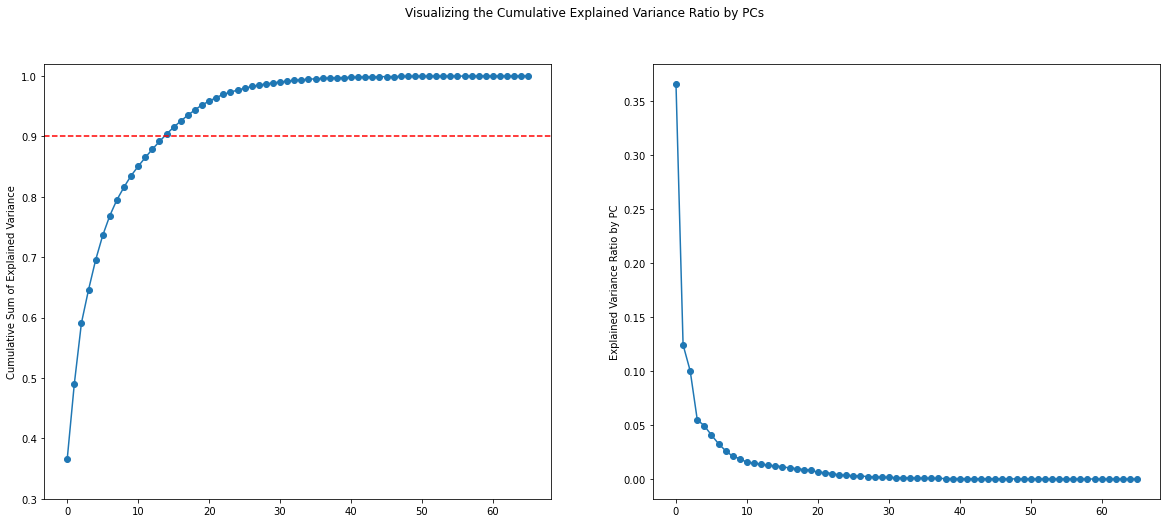

In [223]:
plt.subplots(1,2,figsize=(20,8))
plt.suptitle("Visualizing the Cumulative Explained Variance Ratio by PCs")

# scree plot - visualizing cumulative variance captured
plt.subplot(1,2,1)
plt.plot(pca_train_df.columns, ex_var_ratio.cumsum(), marker='o')
plt.axhline(0.9, color='red', linestyle='--')
plt.ylim(0.30, 1.02)
plt.ylabel('Cumulative Sum of Explained Variance')

plt.subplot(1,2,2)
plt.plot(pca_train_df.columns, ex_var_ratio, marker='o')
plt.ylabel('Explained Variance Ratio by PC')

plt.show()

Based on the cumulative sum of explained variance, it takes about 14 PC's to explain 90% of the variance in the data.

Looking for the 'elbow' for the explained variance ratio, the PC number is approximately 10 but a couple more past that, likely around 14-15, before it truly flattens out.

We will use 14 components and see how we do as we retest our Linear Regression models.

In [224]:
pca = PCA(n_components = 14)

pca.fit(X_train_ss2)

X_train_pca = pca.transform(X_train_ss2)
X_test_pca = pca.transform(X_test_ss2)

In [225]:
ex_var_ratio = pca.explained_variance_ratio_
ex_var_ratio

array([0.3664741 , 0.12438745, 0.10033972, 0.05487824, 0.04931926,
       0.0407384 , 0.03271576, 0.02619026, 0.02101614, 0.01896085,
       0.01546127, 0.0146263 , 0.01373852, 0.01278359])

In [226]:
pca.components_

array([[-1.36815954e-02, -5.70366236e-02,  1.09762631e-01,
         1.31524077e-01,  1.48345556e-01,  1.75128573e-01,
         1.70102238e-01, -2.73554972e-02,  1.52734061e-01,
         1.47690705e-01,  1.50427780e-01,  1.40281839e-01,
        -3.50503860e-02,  1.43870448e-01,  4.21406022e-03,
         1.52694516e-01,  1.03434569e-02,  1.41847564e-01,
         1.42667015e-01,  1.08049474e-01,  6.55191284e-02,
         7.65978386e-02,  1.59191380e-01,  1.59224134e-01,
         1.17502731e-01,  1.12517580e-01,  5.39567614e-02,
         8.03747518e-02,  2.35342527e-02,  1.25859952e-02,
         1.78443601e-01,  1.01719174e-01,  9.99653553e-02,
         1.61811171e-01,  1.70000200e-01,  1.67495283e-01,
        -3.98090164e-03, -1.81227258e-03,  6.55191284e-02,
         1.65498438e-01,  1.57228362e-01,  1.35572664e-01,
         2.34051222e-03,  1.45800748e-01,  6.97057982e-03,
         5.86752542e-02,  1.37627487e-01,  1.35628368e-01,
         1.42316234e-01,  1.29071463e-01,  1.68482299e-0

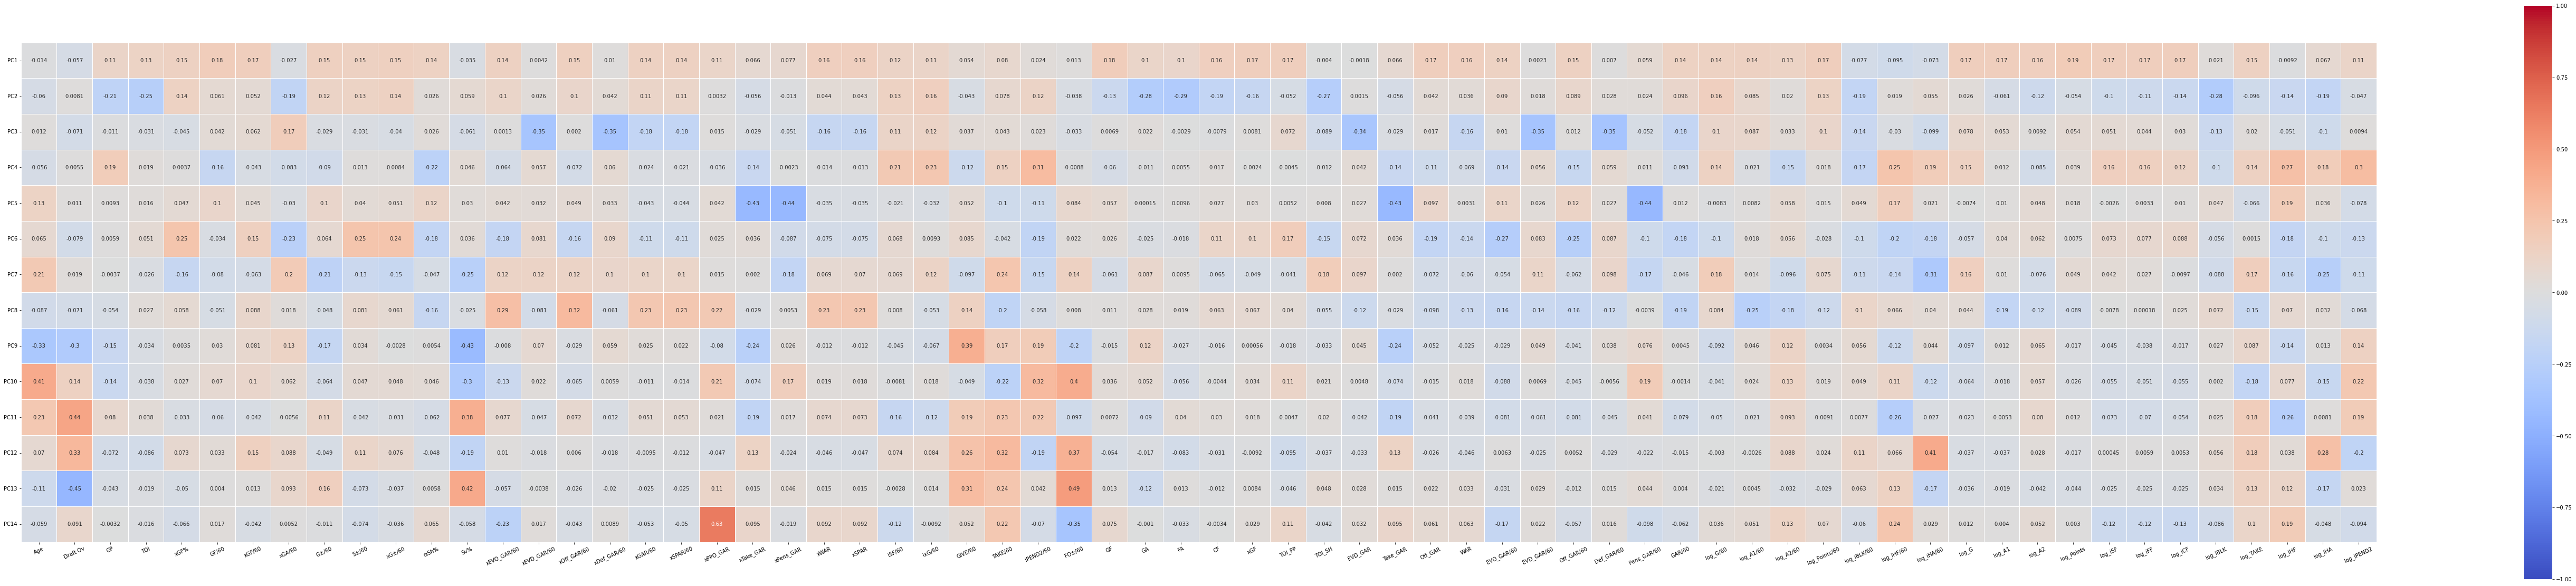

In [230]:
#Heatmap modified from PCA lecture
plt.figure(figsize=(100,20))

ax = sns.heatmap(pca.components_,
                 cmap='coolwarm',
                 yticklabels=[ "PC"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(X_train_ss2.columns),
                 linewidths = 1,
                 annot = True,
                 vmin=-1,
                 vmax=1)

plt.yticks(rotation=0)
plt.xticks(rotation=25)
ax.set_aspect("equal")

Here is a summary of the 14 Principal Components.  This could serve as some potential insight into what we may see when we Cluster the data:

PC1: Offensive Producers - Players who are above average across many offensive categories, but are the highest at producing goals and shots.  They are also the lowest group on 'physical' stats (hits and blocks).  Defensive stats are at the mean, in some cases below the mean.  

PC2: Offensive Producers, Limited Time On Ice - Rating stats are similar to PC1, but their total stats are lower (lowest on average compared to all PC's).  GP and TOI are the lowest, but more hits on average compared to PC1.  This likely accounts for good offensive players that had their time limited due to injury.

PC3: Offensive Producer, Defensive Liability - This PC shows above average offensive production, but some of the worst advanced defensive statistics.

PC4: Checkers - This PC has the highest number of Hits For and Against, while making some goal scoring contributions.

PC5: Penalty Takers - This is a pretty average group except that their overall production is reduced due to the number of penalties that they take.

PC6: Power Play Quarterback - There is a lot of contribution in the number of shots created and assists while a higher than average amount of time on the Power Play.  This group has a higher than average defensive statistics.

PC7: Penalty Kill Specialist - This PC has some of the best defensive statistics and a high amount of time on ice while shorthanded.  This PC also shows a significantly above average number of goals scored.

PC8: Advanced Statistics 'Darlings' - this PC shows players that have much better advanced statistics than actual counting stats.  Could be players that have been higher effective in limited ice-time.

PC9: Reckless Prospect - This PC has the youngest mean age, but also high giveaways rate and penalties taken.  This seems to profile young players with potential upside trying to make a roster in a checking role.

PC10: Veteran Center - This PC represents the oldest players in the data, while also having a high number of Face-offs suggesting that they are mostly centers.

PC11: Late Draft/Undrafted Prospect - This PC has the highest Draft Pick Overall, while also an increased number of giveaways, takeaways and penalties.  Similar to PC9.

PC12: Late Draft Offensive Prospect - Similar to PC 11 but with better offensive ratings and a higher number of hits.

PC13: Young Center Prospect - This PC has the lowest mean Draft Pick (meaning that they were some of the best players selected in the draft).  Many are Centers with the highest FO+/- of any group as well.

PC14: Powerplay Defencemen - This PC shows the highest contribution from the Powerplay, but the lowest number of face-offs, suggesting that this represents mostly defencemen.

With this, we can run through our Linear Regression models again with this reduced dimensionality and see if we get better accuracy than with the full dataset.

## Linear Regression With Reduced Dimensionality

<a id = 'linpca'></a>

With our reduced dimensionality, we will see if it has an effect on the accuracy of our linear models, starting with our standarad Linear Regression.

In [231]:
lin_mod_pca1 = LinearRegression()
lin_mod_pca1.fit(X_train_pca, y_train)

LinearRegression()

In [232]:
model_evaluation(lin_mod_pca1, X_train_pca, X_test_pca)

Train R^2 Score: 0.5157

Test R^2 Score: 0.5036
Test MAE: 1.2251
Test RMSE: 1.6046


In [233]:
ridge_mod_pca = Ridge()
ridge_mod_pca.fit(X_train_pca, y_train)
model_evaluation(ridge_mod_pca, X_train_pca, X_test_pca)

Train R^2 Score: 0.5157

Test R^2 Score: 0.5037
Test MAE: 1.2251
Test RMSE: 1.6046


In [234]:
lasso_mod_pca = Lasso()
lasso_mod_pca.fit(X_train_pca, y_train)
model_evaluation(lasso_mod_pca, X_train_pca, X_test_pca)

Train R^2 Score: 0.2785

Test R^2 Score: 0.2561
Test MAE: 1.5892
Test RMSE: 1.9644


Similar to our initial Linear Regression models, the normal Linear Regression and Ridge Regressions performed nearly identicially, while the 'default' Lasso regression performed significantly worse.  However, all performed lower across all metrics.

Unsurprisingly, considering we used a Standard Scaler and the initial Lasso Regression was the worst performing model initially, the scores for the Lasso Regression with reduced dimensionality decreased significantly.

Now we will run the same analysis and hyperparameter optimization for our Ridge and Lasso Regressions to optimize our Linear Regression performance.  We'll start with our Lasso Regression again.

In [235]:
for n in alpha_list:
    lasso_model = Lasso(alpha = n)
    lasso_model.fit(X_train_pca, y_train)
    scores = cross_val_score(lasso_model, X_train_pca, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1e-07: Validation R^2 Score: 0.510802

Alpha = 1e-06: Validation R^2 Score: 0.510802

Alpha = 1e-05: Validation R^2 Score: 0.510802

Alpha = 0.0001: Validation R^2 Score: 0.510806

Alpha = 0.001: Validation R^2 Score: 0.510838

Alpha = 0.01: Validation R^2 Score: 0.511009

Alpha = 0.1: Validation R^2 Score: 0.504548

Alpha = 1: Validation R^2 Score: 0.277261

Alpha = 10: Validation R^2 Score: -0.000467

Alpha = 100: Validation R^2 Score: -0.000467



The optimal alpha value of the Lasso regularization looks to be .001.  This should significant improve this Lasso regression model, but looks to still perform much lower than the Lasso Regression performed on the full dataset.

In [236]:
lasso_mod_pca2 = Lasso(alpha = 0.001)
lasso_mod_pca2.fit(X_train_pca, y_train)
model_evaluation(lasso_mod_pca2, X_train_pca, X_test_pca)

Train R^2 Score: 0.5157

Test R^2 Score: 0.5037
Test MAE: 1.225
Test RMSE: 1.6046


This score matches the Ridge Regression model with reduced dimensionality, but still far from the best performing linear regression model.  We will try optimizing the Ridge regression regularization.

In [237]:
for n in alpha_list:
    ridge_model = Ridge(alpha = n)
    ridge_model.fit(X_train_pca, y_train)
    scores = cross_val_score(ridge_model, X_train_pca, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1e-07: Validation R^2 Score: 0.510802

Alpha = 1e-06: Validation R^2 Score: 0.510802

Alpha = 1e-05: Validation R^2 Score: 0.510802

Alpha = 0.0001: Validation R^2 Score: 0.510802

Alpha = 0.001: Validation R^2 Score: 0.510802

Alpha = 0.01: Validation R^2 Score: 0.510802

Alpha = 0.1: Validation R^2 Score: 0.510802

Alpha = 1: Validation R^2 Score: 0.510803

Alpha = 10: Validation R^2 Score: 0.510811

Alpha = 100: Validation R^2 Score: 0.51084



The performance of this model actually increased slightly in the higher ranges.  I'll re-run this with higher alpha levels to see if it needs to be optimized at a much higher level.

In [238]:
higher_alpha = [1, 10, 100, 1000, 10000, 100000, 1000000]

In [239]:
for n in higher_alpha:
    ridge_model = Ridge(alpha = n)
    ridge_model.fit(X_train_pca, y_train)
    scores = cross_val_score(ridge_model, X_train_pca, y_train, cv = 5, )
    print(f'Alpha = {n}: Validation R^2 Score: {np.round(np.mean(scores), 6)}\n')

Alpha = 1: Validation R^2 Score: 0.510803

Alpha = 10: Validation R^2 Score: 0.510811

Alpha = 100: Validation R^2 Score: 0.51084

Alpha = 1000: Validation R^2 Score: 0.507476

Alpha = 10000: Validation R^2 Score: 0.438048

Alpha = 100000: Validation R^2 Score: 0.242005

Alpha = 1000000: Validation R^2 Score: 0.048391



While the improvement is marginal, it looks like 100 is the optimal value for alpha for this ridge regression.

In [240]:
ridge_mod_pca2 = Ridge(alpha = 100)
ridge_mod_pca2.fit(X_train_pca, y_train)
model_evaluation(ridge_mod_pca2, X_train_pca, X_test_pca)

Train R^2 Score: 0.5157

Test R^2 Score: 0.5037
Test MAE: 1.225
Test RMSE: 1.6045


There is little to no improvement in this compared to having the regularization at the base level of 1.

From a performance stand point, reducing the dimensionality did not improve the our linear regression.  The linear regression model using lasso regression on standard scaled data on the full dataset is still our best performing linear regression model.  We will see how the reduced dimensionality affects our XGBoost model.

### XGBoost With Reduced Dimensionality

In [241]:
xgb_pca = XGBRegressor()
xgb_pca.fit(X_train_pca, y_train)
model_evaluation(xgb_pca, X_train_pca, X_test_pca)

Train R^2 Score: 0.9404

Test R^2 Score: 0.4588
Test MAE: 1.2346
Test RMSE: 1.6755


Unfortunately, the performance of our XGBoost model is significantly lower with the reduced number of dimensions.  This model is quite overfit so we will see if we can improve the testing score through some hyperparameter optimization.

**The entirety of my Grid Searches can be found in the 'Brian Johns Appendix NB#2 Copy Grid Searches' notebook.  My final XGBoost model with PCA data is shown here, but my thought process and full code for the Grid Searches are in the Appendix**

In [260]:
xgb_pca5 = XGBRegressor(booster = 'gbtree',
                        max_depth = 3,
                        min_child_weight = 30,
                        n_estimators = 40,
                        reg_lambda = 0.1)
xgb_pca5.fit(X_train_pca, y_train)
model_evaluation(xgb_pca5, X_train_pca, X_test_pca)

Train R^2 Score: 0.6296

Test R^2 Score: 0.5091
Test MAE: 1.2003
Test RMSE: 1.5957


This our best performing performing model using our pca data with the XGBoost model.  By optimizing the hyperparameters, we improved the r-squared score by nearly 6% overall, and decreased MAE and RMSE 0.05 and 0.1 respectively.  However, the overall performance still lags behind the XGBoost and Linear Regression models that used the full dataset.

Our final step in order to maximize the performance to predict players Cap Hits is to run a Random Forest regression model in hopes of using one more tool in order to have the best predictive model for the cap hit of our NHL players.

## Random Forest Regression

<a id = 'rf'></a>

In [261]:
from sklearn.ensemble import RandomForestRegressor

As with my other models, I will start again use the full dataset and optimize the hyperparameters to establish my best model.

After that, I will go through the same process using PCA data.

In [262]:
rf_mod = RandomForestRegressor()

In [263]:
rf_mod.fit(X_train, y_train)
model_evaluation(rf_mod, X_train, X_test)

Train R^2 Score: 0.9522

Test R^2 Score: 0.6706
Test MAE: 0.936
Test RMSE: 1.3071


This starting point is very close to our best performing xgboost model, but is significantly overfit.  Hopefully we can improve the metrics of the model while lowering the training score.  Considering the amount of time it takes to fit a random forest model, and the number of hyperparameters to tune, we will begin our optimization using RandomizedSearchCV.

Using RandomizedSearch in a few interations should narrow the range of our parameters while not taking as much time as running a full GridSearch.  However, we do risk missing the appropriate hyperparameters entirely if the randomized search doesn't choose it.  By scoring our data and visualizing the performance of our hyperparameters, we should be able to identify appropriate ranges before running a full GridSearch for more specific optimization.

**The entirety of my Grid Searches can be found in the 'Brian Johns Appendix NB#2 Copy Grid Searches' notebook.  My final Random Forest model fit is shown here, but my thought process and full code for the Grid Searches (Randomized and Full) are in the Appendix**

In [264]:
from sklearn.model_selection import RandomizedSearchCV

In [439]:
rf_mod14 = RandomForestRegressor(n_estimators = 140,
                               min_samples_split = 100,
                               min_samples_leaf = 50,
                               max_features = 'auto',
                               max_depth = 30,
                               bootstrap = True)
rf_mod14.fit(X_train, y_train)
model_evaluation(rf_mod14, X_train, X_test)

Train R^2 Score: 0.682

Test R^2 Score: 0.6415
Test MAE: 0.9939
Test RMSE: 1.3637


We had started with a Random Forest model that was nearly as accurate as our XGBoost model but very overfit.  As we optimized the model, the performance of the model itself dropped although was likely more accurate considering the concurrent decrease in the training score.  Despite the lack of improvement on the overall performance of the Random Forest model, this model should be more robust than the initial RF model.

Our optimized XGBoost model is still the best performing model for this data, but I would still like to visualize the tree that was formed by the random forest model to see if some further insights can be gained from the construction of the model.

In [298]:
from sklearn import tree

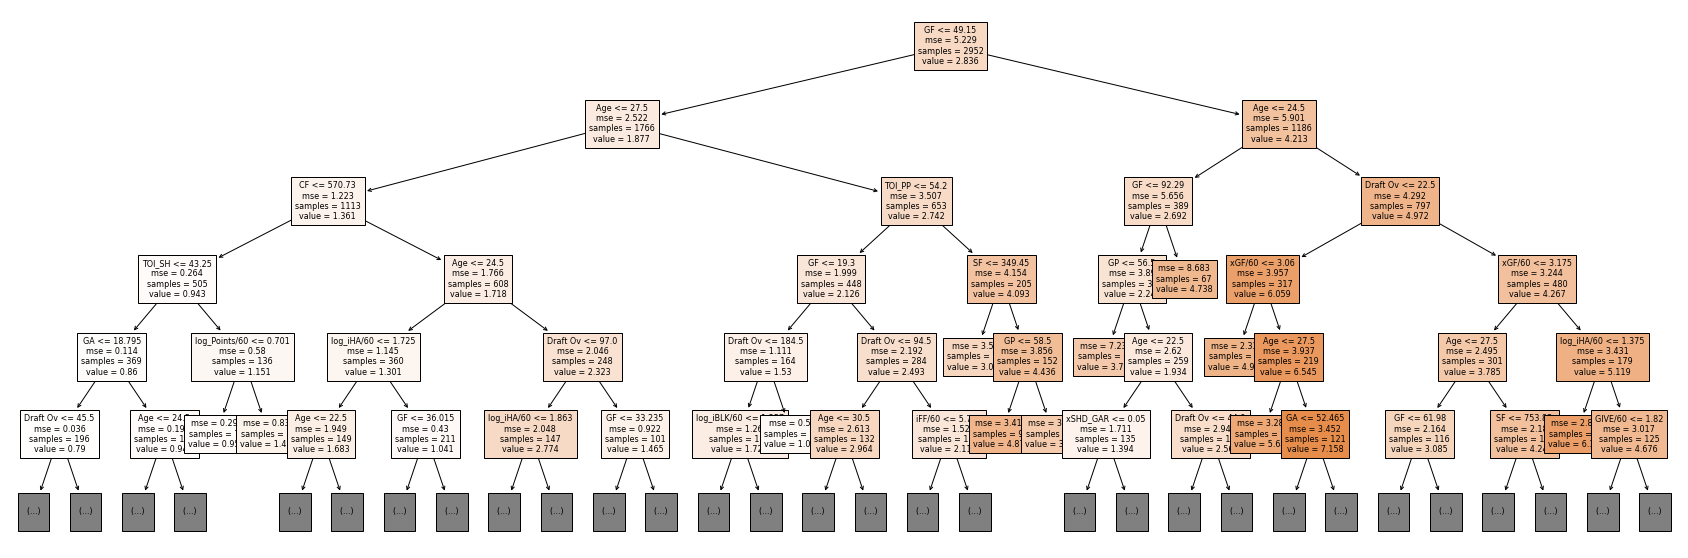

In [452]:
plt.figure(figsize=(30,10))
tree.plot_tree(rf_mod14.estimators_[0],
               feature_names=X_train.columns,
               max_depth = 5,
               filled=True,
              fontsize = 8)
plt.show()

It is interesting that the first branch is Goals For, followed by Age for the next branch.  The next level has Draft Ov, Goals For (again), Time on Ice on the Power Play and Corsi For.  Except for Corsi For, all of these factors have been common in the evaluation of all of our models.

In order to get a better understand of how this Random Forest model made it's decisions, we will make a graph to visualize the feature importance of the model and see which were the top 10 features that had the biggest impact on the model.

In [491]:
rf_importances_df = pd.DataFrame({'Feature': X_train.columns,
                                  'Importance': rf_mod14.feature_importances_})

rf_importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

rf_importances_df.head(10)

Feature  Importance
0         TOI_PP    0.421584
1            Age    0.271496
2       Draft Ov    0.100951
3             GF    0.044363
4            xGF    0.027898
5         xGF/60    0.018446
6           Year    0.011670
7  log_Points/60    0.011634
8     log_iHA/60    0.009497
9     log_Points    0.009010

In [492]:
top_importances_df = rf_importances_df.head(10)

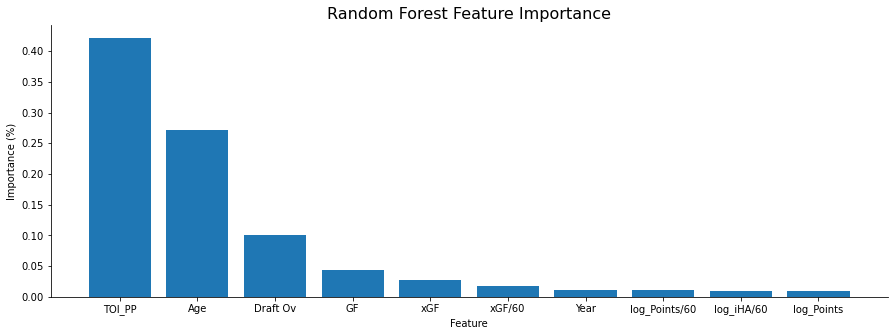

In [493]:
plt.figure(figsize=(15,5))
plt.bar(top_importances_df['Feature'], top_importances_df['Importance'])
plt.title('Random Forest Feature Importance', fontsize=16)
plt.ylabel('Importance (%)')
plt.xlabel('Feature')
sns.despine()
plt.show()

Very few features were actually important in the construction of this Random Forest model.  Time On Ice on the Power Play was the most important by far, followed by Age and Draft Pick.  A collection of stats associated with Goals For (GF, xGF and xGF/60) make the next 3 stats and are the only player performance statistics with much importance.  The remaining features after that have negligible performance relative to the first 6, but especially compared to TOI_PP, Age and Draft Ov.

As the improtance of these features are similar to those of the XGBoost model, it's worth comparing how the models predicted their values and how they may differ in their predictions.

In [453]:
#Cap Hit Predictions across the full dataset
rf_y_pred = rf_mod14.predict(X)

In [454]:
#Use to re-calculate the RMSE based off of the test set, as to not under-estimate the error on the full data
rf_y_pred_test = rf_mod14.predict(X_test)

In [455]:
#Equal to the test RMSE
rf_rmse = mean_squared_error(y_test, rf_y_pred_test, squared = False)

In [456]:
rf_rmse

1.3636734080270965

In [457]:
rf_predict_df = pd.DataFrame({'Actual Cap Hit':y,
                           'Predicted Cap Hit': rf_y_pred,
                           'Upper Limit': (rf_y_pred)+rf_rmse,
                           'Lower Limit': (rf_y_pred)-rf_rmse,
                              'Amount Missed': rf_y_pred-y})

In [458]:
rf_predict_df.head()

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  Amount Missed
0           0.925           1.571934     2.935607     0.208260       0.646934
1           0.925           1.745819     3.109492     0.382145       0.820819
2           0.925           1.498238     2.861911     0.134565       0.573238
3           7.500           2.767123     4.130797     1.403450      -4.732877
4           7.500           3.844062     5.207736     2.480389      -3.655938

Text(0, 0.5, 'Actual Cap Hit')

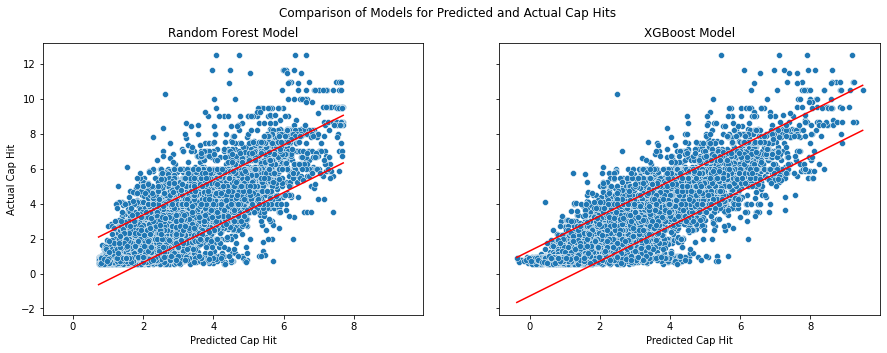

In [459]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex = True, sharey=True)
fig.suptitle('Comparison of Models for Predicted and Actual Cap Hits')

sns.scatterplot(ax=axes[0],
                x='Predicted Cap Hit',
                y='Actual Cap Hit',
                data = rf_predict_df,
                marker = 'o')

sns.lineplot(ax=axes[0],
             x = 'Predicted Cap Hit',
             y = 'Upper Limit',
             data = rf_predict_df,
             color = 'red')

sns.lineplot(ax=axes[0],
             x = 'Predicted Cap Hit',
             y = 'Lower Limit',
             data = rf_predict_df,
             color = 'red')

axes[0].set_title('Random Forest Model')

sns.scatterplot(ax=axes[1],
                x='Predicted Cap Hit',
                y='Actual Cap Hit',
                data = xgb_predict_df,
                marker = 'o')

sns.lineplot(ax=axes[1],
             x = 'Predicted Cap Hit',
             y = 'Upper Limit',
             data = xgb_predict_df,
             color = 'red')

sns.lineplot(ax=axes[1],
             x = 'Predicted Cap Hit',
             y = 'Lower Limit',
             data = xgb_predict_df,
             color = 'red')

axes[1].set_title('XGBoost Model')

plt.xlabel('Predicted Cap Hit')
plt.ylabel('Actual Cap Hit')

It's hard to believe, but these two models are on the same scale.  The Random Forest model has a much more condensed range of values for Predicted Cap Hit relative to the XGBoost model, with all predicted values falling between $1-8 million.

As suggested by the fact that the RMSE value is greater for the Random Forest model than the XGBoost model, the spread of the data for the Random Forest model is wider.  In particular, it seems the Random Forest model was less accurate at predicting higher cap values than the XGBoost model.  XGBoost seems to be closer to capturing the higher value players while having a larger error in the 'meat' of the model.

Similar to the XGBoost, we'll have a look at our most overpaid and underpaid players according to this model.

In [460]:
rf_predict_df[['Player', 'Age', 'Year']] = clean_df[['Player', 'Age', 'Year']]

First, these are the Top 10 Underpaid Players according to this model.

In [461]:
rf_predict_df.sort_values('Amount Missed', ascending = False).head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
2219            0.70           5.689314     7.052988     4.325641   
4162            1.05           5.484719     6.848392     4.121045   
4689            1.00           5.350676     6.714350     3.987003   
1691            1.00           5.288708     6.652382     3.925035   
5267            0.65           4.937699     6.301372     3.574026   
2750            2.00           6.272208     7.635881     4.908534   
2935            0.75           4.964881     6.328554     3.601207   
4709            0.70           4.902344     6.266017     3.538670   
562             1.30           5.421743     6.785417     4.058070   
3215            0.90           4.830588     6.194262     3.466915   

      Amount Missed                 Player  Age  Year  
2219       4.989314         ilya kovalchuk   36  2020  
4162       4.434719           mike ribeiro   34  2015  
4689       4.350676          patrick eaves   32  2017  
1691       4.288708        derick brassard   32  2021  
5267       4.287699             sam gagner   27  2017  
2750       4.272208           joe thornton   40  2020  
2935       4.214881  jonathan marchessault   26  2018  
4709       4.202344        patrick marleau   40  2020  
562        4.121743         benoit pouliot   26  2014  
3215       3.930588           keith yandle   35  2022

In [462]:
xgb_predict_df.sort_values('Amount Missed', ascending = False).head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
4709           0.700           5.382421     6.672915     4.091928   
631            1.000           5.643685     6.934179     4.353191   
2219           0.700           5.314263     6.604757     4.023769   
1691           1.000           5.332494     6.622988     4.042000   
2750           2.000           6.232582     7.523076     4.942088   
2872           0.925           5.076278     6.366772     3.785784   
2935           0.750           4.876474     6.166968     3.585980   
4689           1.000           5.030213     6.320707     3.739719   
510            0.925           4.787693     6.078187     3.497199   
2574           0.700           4.534217     5.824711     3.243723   

      Amount Missed                 Player  Age  Year  
4709       4.682421        patrick marleau   40  2020  
631        4.643685             brad boyes   30  2013  
2219       4.614263         ilya kovalchuk   36  2020  
1691       4.332494        derick brassard   32  2021  
2750       4.232582           joe thornton   40  2020  
2872       4.151278        johnny gaudreau   22  2016  
2935       4.126474  jonathan marchessault   26  2018  
4689       4.030213          patrick eaves   32  2017  
510        3.862693        auston matthews   19  2018  
2574       3.834217           jason spezza   37  2021

Similar to the XGBoost model, the Random Forest model predicted much higher cap hits for veteran players that massively outperformed there contracts.  In fact, these lists share 6 players in the top 10.  This lends credence to the hypothesis that it is worth investing a low level contract into a veteran that has shown a high level of previous performance. 

Now let's look at the most 'overpaid'.

In [463]:
rf_predict_df.sort_values('Amount Missed').head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
1361          12.500           4.074291     5.437964     2.710617   
1362          12.500           4.728645     6.092318     3.364971   
512           11.634           3.955927     5.319600     2.592253   
6102          10.278           2.625096     3.988769     1.261422   
513           11.640           4.476667     5.840340     3.112994   
1997          11.500           5.038647     6.402321     3.674974   
4245          10.893           4.434021     5.797694     3.070347   
1363          12.500           6.313353     7.677026     4.949680   
2270          10.000           4.015362     5.379035     2.651688   
1364          12.500           6.653493     8.017167     5.289820   

      Amount Missed            Player  Age  Year  
1361      -8.425709    connor mcdavid   21  2019  
1362      -7.771355    connor mcdavid   22  2020  
512       -7.678073   auston matthews   21  2020  
6102      -7.652904  william nylander   22  2019  
513       -7.163333   auston matthews   22  2021  
1997      -6.461353     erik karlsson   31  2022  
4245      -6.458979      mitch marner   22  2020  
1363      -6.186647    connor mcdavid   23  2021  
2270      -5.984638       jack eichel   21  2019  
1364      -5.846507    connor mcdavid   24  2022

In [464]:
xgb_predict_df.sort_values('Amount Missed').head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
6102          10.278           2.480870     3.771364     1.190376   
1361          12.500           5.465597     6.756091     4.175103   
512           11.634           6.113905     7.404399     4.823411   
1362          12.500           7.112248     8.402742     5.821754   
1997          11.500           6.580772     7.871266     5.290278   
2270          10.000           5.237596     6.528090     3.947102   
488           11.643           6.977637     8.268131     5.687143   
1363          12.500           7.907711     9.198204     6.617217   
2656           9.000           4.482428     5.772922     3.191934   
4245          10.893           6.391885     7.682379     5.101391   

      Amount Missed            Player  Age  Year  
6102      -7.797130  william nylander   22  2019  
1361      -7.034403    connor mcdavid   21  2019  
512       -5.520095   auston matthews   21  2020  
1362      -5.387752    connor mcdavid   22  2020  
1997      -4.919228     erik karlsson   31  2022  
2270      -4.762404       jack eichel   21  2019  
488       -4.665363    artemi panarin   28  2021  
1363      -4.592289    connor mcdavid   23  2021  
2656      -4.517572      jeff skinner   28  2021  
4245      -4.501115      mitch marner   22  2020

Considering that the Random Forest model had a much narrower range of predicted values, it's no surprise that all of the top 10 are players with massive contracts that would be impossible to live up to given range of values predicted.

While this is not as accurate a model as the XGBoost model, this again gives credence to the idea that no matter how much the best players produce, it would be better to spread that salary to multiple high level players and get more overall production for the team as a result.  Again, this does not take into account factors outside of on-ice performance that a player may be paid a mega-contract.

Last, I want to see the Top 10 predicted Cap Hits derived from the Random Forest Model.

In [465]:
rf_predict_df.sort_values('Predicted Cap Hit', ascending = False).head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
5514           8.500           7.700959     9.064633     6.337286   
194            9.538           7.695747     9.059420     6.332073   
5448           8.700           7.685741     9.049414     6.322068   
2028           9.500           7.674485     9.038158     6.310811   
195            9.538           7.670592     9.034266     6.306919   
5449           8.700           7.670387     9.034060     6.306714   
2030           9.500           7.669293     9.032967     6.305620   
5447           8.700           7.665177     9.028851     6.301504   
2744           7.000           7.657873     9.021547     6.294200   
2746           6.750           7.652298     9.015971     6.288624   

      Amount Missed          Player  Age  Year  
5514      -0.799041  steven stamkos   28  2019  
194       -1.842253   alex ovechkin   31  2018  
5448      -1.014259   sidney crosby   29  2017  
2028      -1.825515   evgeni malkin   31  2018  
195       -1.867408   alex ovechkin   32  2019  
5449      -1.029613   sidney crosby   30  2018  
2030      -1.830707   evgeni malkin   33  2020  
5447      -1.034823   sidney crosby   28  2016  
2744       0.657873    joe thornton   34  2014  
2746       0.902298    joe thornton   36  2016

In [466]:
xgb_predict_df.sort_values('Predicted Cap Hit', ascending = False).head(10)

Actual Cap Hit  Predicted Cap Hit  Upper Limit  Lower Limit  \
4699          10.500           9.493566    10.784060     8.203072   
5448           8.700           9.307359    10.597853     8.016865   
2857          11.000           9.237207    10.527701     7.946713   
5452           8.700           9.229172    10.519666     7.938678   
2856          11.000           9.212456    10.502950     7.921962   
1364          12.500           9.201039    10.491533     7.910545   
4700          10.500           9.141337    10.431831     7.850843   
197            9.538           9.106882    10.397376     7.816388   
2027           9.500           8.904400    10.194894     7.613906   
5450           8.700           8.898499    10.188993     7.608006   

      Amount Missed          Player  Age  Year  
4699      -1.006434    patrick kane   30  2020  
5448       0.607359   sidney crosby   29  2017  
2857      -1.762793    john tavares   30  2022  
5452       0.529172   sidney crosby   33  2021  
2856      -1.787544    john tavares   29  2021  
1364      -3.298961  connor mcdavid   24  2022  
4700      -1.358663    patrick kane   31  2021  
197       -0.431118   alex ovechkin   34  2021  
2027      -0.595600   evgeni malkin   30  2017  
5450       0.198499   sidney crosby   31  2019

As noted, the max level of Predicted Cap Hit is much lower through the Random Forest model than it is for the XGBoost model.  That being said, Sidney Crosby, Alex Ovechkin and Evgeni Malkin show up on both models, showing that their seasons were the most valuable of any throughout this dataset.  Unlike the XGBoost model, all of these predicted values were all below the player's actual Cap Hit, with the exception of Joe Thornton's seasons who had a cheaper salary than the rest.

The last model that we will try to run is a Random Forest model with the reduced data.  Considering the level of performance that our previous models using the pca data elicited, it is unlikely this will be our best performing model.  However, insights could still be gained as to the importance of some of our features in the overall evaluation of the player's cap hits.

### Random Forest Regression With Reduced Dimensionality

<a id = 'rfpca'></a>

In [312]:
rf_mod_pca = RandomForestRegressor()
rf_mod_pca.fit(X_train_pca, y_train)
model_evaluation(rf_mod_pca, X_train_pca, X_test_pca)

Train R^2 Score: 0.9298

Test R^2 Score: 0.5086
Test MAE: 1.1904
Test RMSE: 1.5966


This is inline with performance level of our other models using PCA.  We will tune the hyperparameters again to see how we can optimize our random forest model using PCA data.  While using data with reduced dimensionality, we should be able to use a larger range of variables for our hyperparameters with more computing speed.  Therefore I will use a full Grid Search from the start for this Random Forest modelling.

**The entirety of my Grid Searches can be found in the 'Brian Johns Appendix NB#2 Copy Grid Searches' notebook.  My final Random Forest model with PCA fit is shown here, but my thought process and full code for the Grid Searches are in the Appendix**

In [362]:
rf_mod_pca10 = RandomForestRegressor(n_estimators = 145,
                               min_samples_split = 100,
                               min_samples_leaf = 50,
                               max_features = 10,
                               max_depth = 9,
                               bootstrap = True)
rf_mod_pca10.fit(X_train_pca, y_train)
model_evaluation(rf_mod_pca10, X_train_pca, X_test_pca)

Train R^2 Score: 0.5309

Test R^2 Score: 0.4614
Test MAE: 1.273
Test RMSE: 1.6716


Again, it would appear that the performance will be lower than the Random Forest model from the original data.  We will run another Tree plot to see if we can get any insights from this model before coming to our final summary for our Linear Regression models.

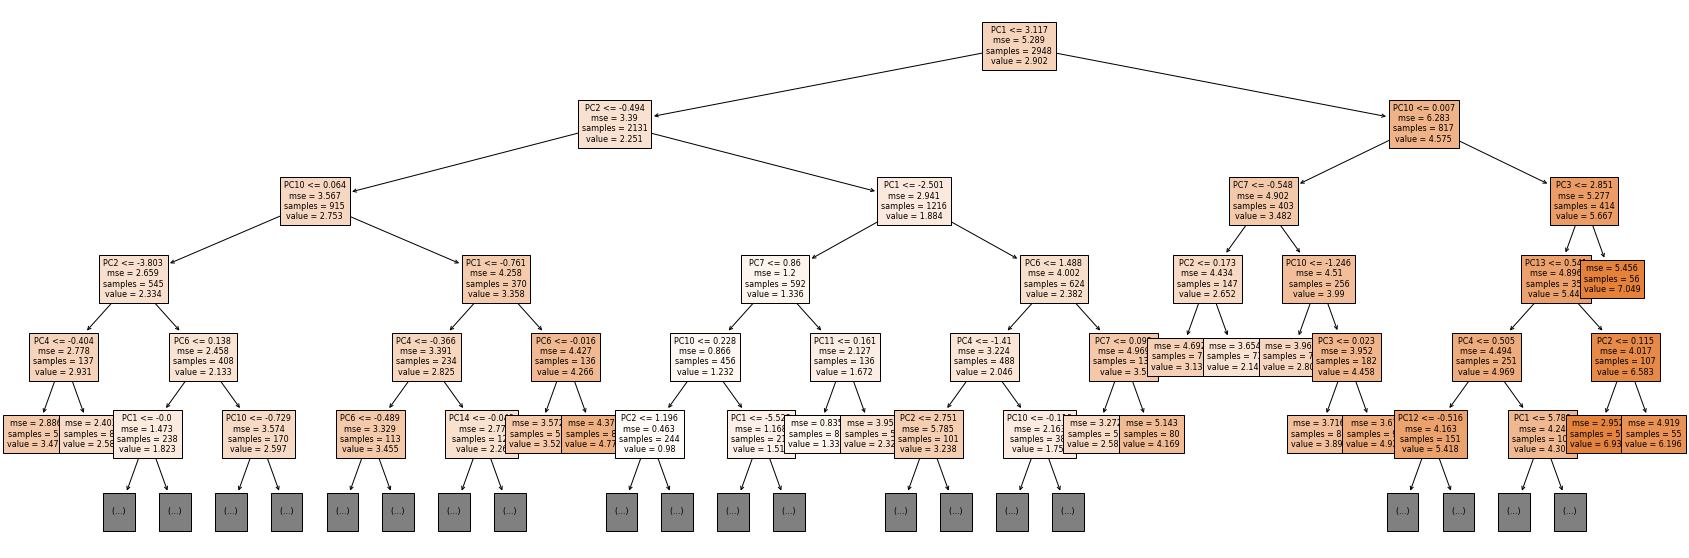

In [367]:
plt.figure(figsize=(30,10))
tree.plot_tree(rf_mod_pca10.estimators_[0],
               feature_names=["PC"+str(x) for x in range(1,pca.n_components_+1)],
               filled=True,
              fontsize = 8,
              max_depth = 5)
plt.show()

In the first levels of the tree plot, PC1 and PC10 were used several times to parse through the data before making smaller adjustments.  As indicated previously, PC1 are the overall best offensive players, while PC10 indicated more veteran players (with Age being a higher factor).  This would suggest that the offensive stats were vital for the initial split, but then Age becomes an important factor thereafter.

In [368]:
xgb_predict_df[['Predicted Cap Hit', 'Amount Missed']]

Predicted Cap Hit  Amount Missed
0              1.425904       0.500904
1              1.306689       0.381689
2              2.347113       1.422113
3              3.627931      -3.872069
4              5.064314      -2.435686
...                 ...            ...
6221           1.655417       0.505417
6222           1.742988       0.142988
6223           1.440510      -0.159490
6224           1.642289       0.042289
6225           2.077473      -0.122527

[6226 rows x 2 columns]

Prior to summarizing my data, I am going to add the extra information gained by the XGBoost model on to the Clean dataframe.  This will help further analyze the clusters and be used for future visualizations.

In [369]:
clean_df[['Predicted_Cap_Hit', 'Prediction_Difference']] = xgb_predict_df[['Predicted Cap Hit', 'Amount Missed']]

In [370]:
clean_df.head()

Player Team   Birthday  Age  Draft Ov  GP      TOI    GF%    SF%  \
0  aaron ekblad  FLA 1996-02-07   18       1.0  81  1766.62  59.96  57.82   
1  aaron ekblad  FLA 1996-02-07   19       1.0  78  1690.82  60.69  56.43   
2  aaron ekblad  FLA 1996-02-07   20       1.0  68  1459.28  46.49  55.24   
3  aaron ekblad  FLA 1996-02-07   21       1.0  82  1917.90  53.04  48.15   
4  aaron ekblad  FLA 1996-02-07   22       1.0  82  1938.82  49.07  51.97   

     FF%    CF%   xGF%  GF/60  GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  \
0  56.61  57.07  58.74   2.93   1.96  34.78  25.38  45.59  34.94  59.18   
1  55.41  55.96  57.83   3.29   2.13  31.34  24.20  42.34  34.07  54.45   
2  55.40  56.71  53.00   2.21   2.54  35.47  28.75  48.02  38.66  63.21   
3  48.85  48.87  47.70   3.60   3.19  34.88  37.56  47.86  50.11  60.62   
4  49.96  49.34  47.24   3.51   3.65  33.43  30.90  43.90  43.97  55.82   

   CA/60  xGF/60  xGA/60  G±/60  S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  \
0  44.51    2.78    1.95   0.97   9.40  10.65  14.67    0.83   8.43  92.29   
1  42.84    2.94    2.14   1.16   7.14   8.27  11.61    0.80  10.51  91.18   
2  48.24    2.81    2.49  -0.33   6.72   9.36  14.96    0.32   6.22  91.17   
3  63.41    3.26    3.57   0.41  -2.68  -2.25  -2.79   -0.31  10.33  91.51   
4  57.31    2.90    3.24  -0.13   2.53  -0.07  -1.49   -0.34  10.51  88.20   

   xEVO_GAR/60  xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  xTake_GAR/60  \
0        0.183        0.105        1.267       -0.170         0.033   
1        0.415        0.132       -0.004        0.359         0.034   
2       -0.055       -0.007        0.449        0.754        -0.003   
3        0.273       -0.197        1.128       -0.540        -0.036   
4        0.310        0.138        1.574        0.766        -0.016   

   xDraw_GAR/60  xOff_GAR/60  xDef_GAR/60  xPens_GAR/60  xGAR/60  xWAR/60  \
0         0.023        0.324        0.100         0.056    0.454    0.086   
1        -0.022        0.358        0.140         0.011    0.468    0.090   
2         0.006        0.013        0.025         0.003    0.037    0.007   
3        -0.025        0.362       -0.234        -0.061    0.049    0.010   
4         0.021        0.412        0.206         0.005    0.552    0.103   

   xSPAR/60  xEVO_GAR  xEVD_GAR  xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  \
0     0.165       4.5       2.6       4.7      -0.1        1.0        0.7   
1     0.174       9.5       3.0       0.0       0.3        0.9       -0.6   
2     0.013      -1.1      -0.1       1.4       0.7       -0.1        0.1   
3     0.018       6.8      -4.9       3.3      -1.6       -1.2       -0.8   
4     0.194       8.1       3.6       3.6       2.4       -0.5        0.7   

   xOff_GAR  xDef_GAR  xPens_GAR  xGAR  xWAR  xSPAR  iSF/60  iFF/60  iCF/60  \
0       9.2       2.5        1.6  13.4   2.5    4.9    5.77    8.08   11.92   
1       9.5       3.4        0.3  13.2   2.5    4.9    6.46    8.52   11.50   
2       0.3       0.5        0.1   0.9   0.2    0.3    9.25   12.17   16.78   
3      10.1      -6.6       -2.0   1.6   0.3    0.6    5.91    8.85   12.48   
4      11.7       6.0        0.2  17.8   3.3    6.3    5.57    7.12    9.75   

   ixG/60   Sh%  GIVE/60  TAKE/60  iPENT2/60  iPEND2/60  iPENT5/60  iPEND5/60  \
0    0.30  7.06     1.39     0.88       0.54       0.51       0.00       0.00   
1    0.36  8.24     1.45     0.85       0.67       0.28       0.04       0.04   
2    0.49  4.44     2.38     1.03       1.19       0.70       0.00       0.00   
3    0.39  8.47     3.10     1.25       0.91       0.28       0.09       0.09   
4    0.29  7.22     3.78     1.45       0.65       0.46       0.03       0.03   

   iPEN±/60  FOW/60  FOL/60  FO±/60  iPENT5  iPEND5  iPEN±  FOW  FOL  FO±  \
0     -0.03     0.0     0.0     0.0       0       0     -1    0    0    0   
1     -0.39     0.0     0.0     0.0       1       1    -11    0    0    0   
2     -0.49     0.0     0.0     0.0       0       0    -12    0    0    0   
3  

In [371]:
#This clean data will be exported to be used in a separate notebook in order to Cluster the data
clean_df.to_csv('data/CLEAN_CLUSTERING.csv',index=False)

## Regression Predictions Summary

The following is a recap of our best performing models for predicting the Cap Hit of NHL players.

In [372]:
model_evaluation(xgb6, X_train, X_test)

Train R^2 Score: 0.768

Test R^2 Score: 0.679
Test MAE: 0.9398
Test RMSE: 1.2905


In [467]:
model_evaluation(rf_mod14, X_train, X_test)

Train R^2 Score: 0.682

Test R^2 Score: 0.6415
Test MAE: 0.9939
Test RMSE: 1.3637


In the end, our best performing model for using NHL player's statistics in predicting their Salary Cap Hit was the XGBoost model after optimizing the hyperparameters.  The XGBoost model had the best r-squared score by nearly 4%, while also having the lowest MAE and RMSE by 0.06 and 0.07, respectively.

Our models using PCA did not perform nearly as well, but did provide some useful insight in parsing through the data and identifying areas that were the most significant in predicting Cap Hit.

I will revisit the SHAP summary plot for the XGBoost model and the 

In order to better understand the features that produced the results for the XGBoost model, I am going to use SHAP to further identify key findings from the model.

In [515]:
new_X = X

In [516]:
new_X.index = clean_df['Player']

In [517]:
new_X.head()

Age  Draft Ov  GP      TOI    GF%    SF%    FF%    CF%   xGF%  \
Player                                                                        
aaron ekblad   18       1.0  81  1766.62  59.96  57.82  56.61  57.07  58.74   
aaron ekblad   19       1.0  78  1690.82  60.69  56.43  55.41  55.96  57.83   
aaron ekblad   20       1.0  68  1459.28  46.49  55.24  55.40  56.71  53.00   
aaron ekblad   21       1.0  82  1917.90  53.04  48.15  48.85  48.87  47.70   
aaron ekblad   22       1.0  82  1938.82  49.07  51.97  49.96  49.34  47.24   

              GF/60  GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  CA/60  xGF/60  \
Player                                                                         
aaron ekblad   2.93   1.96  34.78  25.38  45.59  34.94  59.18  44.51    2.78   
aaron ekblad   3.29   2.13  31.34  24.20  42.34  34.07  54.45  42.84    2.94   
aaron ekblad   2.21   2.54  35.47  28.75  48.02  38.66  63.21  48.24    2.81   
aaron ekblad   3.60   3.19  34.88  37.56  47.86  50.11  60.62  63.41    3.26   
aaron ekblad   3.51   3.65  33.43  30.90  43.90  43.97  55.82  57.31    2.90   

              xGA/60  G±/60  S±/60  F±/60  C±/60  xG±/60  oiSh%    Sv%  \
Player                                                                   
aaron ekblad    1.95   0.97   9.40  10.65  14.67    0.83   8.43  92.29   
aaron ekblad    2.14   1.16   7.14   8.27  11.61    0.80  10.51  91.18   
aaron ekblad    2.49  -0.33   6.72   9.36  14.96    0.32   6.22  91.17   
aaron ekblad    3.57   0.41  -2.68  -2.25  -2.79   -0.31  10.33  91.51   
aaron ekblad    3.24  -0.13   2.53  -0.07  -1.49   -0.34  10.51  88.20   

              xEVO_GAR/60  xEVD_GAR/60  xPPO_GAR/60  xSHD_GAR/60  \
Player                                                             
aaron ekblad        0.183        0.105        1.267       -0.170   
aaron ekblad        0.415        0.132       -0.004        0.359   
aaron ekblad       -0.055       -0.007        0.449        0.754   
aaron ekblad        0.273       -0.197        1.128       -0.540   
aaron ekblad        0.310        0.138        1.574        0.766   

              xTake_GAR/60  xDraw_GAR/60  xOff_GAR/60  xDef_GAR/60  \
Player                                                               
aaron ekblad         0.033         0.023        0.324        0.100   
aaron ekblad         0.034        -0.022        0.358        0.140   
aaron ekblad        -0.003         0.006        0.013        0.025   
aaron ekblad        -0.036        -0.025        0.362       -0.234   
aaron ekblad        -0.016         0.021        0.412        0.206   

              xPens_GAR/60  xGAR/60  xWAR/60  xSPAR/60  xEVO_GAR  xEVD_GAR  \
Player                                                                       
aaron ekblad         0.056    0.454    0.086     0.165       4.5       2.6   
aaron ekblad         0.011    0.468    0.090     0.174       9.5       3.0   
aaron ekblad         0.003    0.037    0.007     0.013      -1.1      -0.1   
aaron ekblad        -0.061    0.049    0.010     0.018       6.8      -4.9   
aaron ekblad         0.005    0.552    0.103     0.194       8.1       3.6   

              xPPO_GAR  xSHD_GAR  xTake_GAR  xDraw_GAR  xOff_GAR  xDef_GAR  \
Player                                                                       
aaron ekblad       4.7      -0.1        1.0        0.7       9.2       2.5   
aaron ekblad       0.0       0.3        0.9       -0.6       9.5       3.4   
aaron ekblad       1.4       0.7       -0.1        0.1       0.3       0.5   
aaron ekblad       3.3      -1.6       -1.2       -0.8      10.1      -6.6   
aaron ekblad       3.6       2.4       -0.5        0.7      11.7       6.0   

              xPens_GAR  xGAR  xWAR  xSPAR  iSF/60  iFF/60  iCF/60  ixG/60  \
Player                                                                       
aaron ekblad        1.6  13.4   2.5    4.9    5.77    8.08   11.92    0.30   
aaron ekblad        0.3  13.2   2.5    4.9    6.46    8.52   11.50    0.36   
aaron 

In [518]:
rf_explainer = shap.Explainer(rf_mod14)
rf_shap_values = rf_explainer(new_X)

In [519]:
xgb_explainer = shap.Explainer(xgb6)
xgb_shap_values = xgb_explainer(new_X)

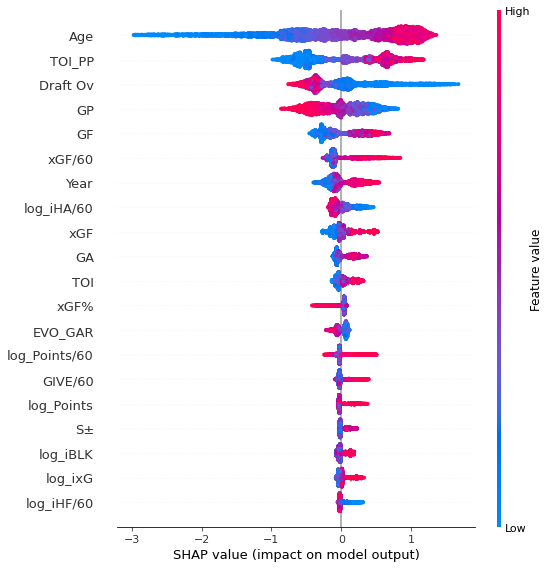

In [558]:
fig = plt.gcf()
shap.summary_plot(xgb_shap_values, new_X)
fig.savefig('xgb_features.png')

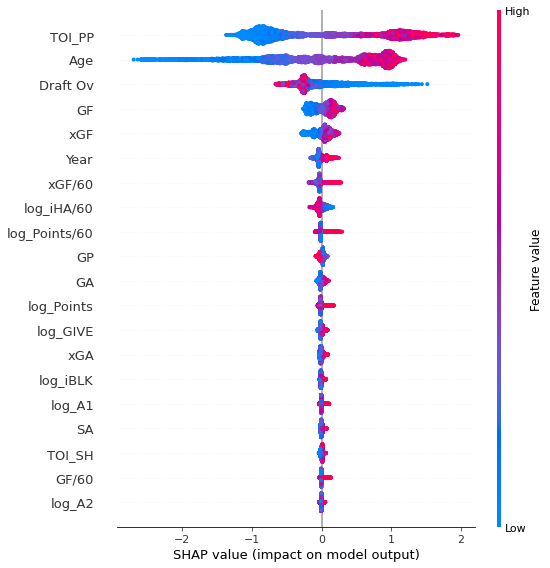

In [521]:
shap.summary_plot(rf_shap_values, new_X)

Reviewing the SHAP values for both the XGBoost model and the Random Forest model, the top 3 features that were most important in predicting Cap Hit were Age, Time On Ice for the Power Play and Overall Draft Pick.

The most important performance feature for both models was Goals For, followed by Expected Goals For and Expected Goals For per 60 Minutes.

It is easier to see how these features affect the predictions by choosing a single player.  Here we will have a closer look at a player who spans the timeline of the entire dataset: Jonathan Huberdeau.

Huberdeau is an interesting prosepct to look at as he was a young rookie in 2013 (winning rookie of the year) and has become an All-Star, although not typically in the discussion for MVP (such as Crosby, Ovechkin and McDavid might be).  Having an overview of how his Cap Hit over his career has changed will give good insight on how these features predicted his Cap Hit.

In [522]:
jh = new_X.index.str.contains('jonathan huberdeau')

In [523]:
#Here is the full overview of stats for Jonathan Huberdeau in his career.
new_X.iloc[jh]

Age  Draft Ov  GP      TOI    GF%    SF%    FF%    CF%  \
Player                                                                       
jonathan huberdeau   19       3.0  48   812.52  47.73  55.04  54.39  53.94   
jonathan huberdeau   20       3.0  69  1080.88  49.84  52.34  52.70  53.63   
jonathan huberdeau   21       3.0  79  1323.08  60.84  56.72  56.53  56.85   
jonathan huberdeau   22       3.0  76  1378.92  61.34  55.61  54.38  54.14   
jonathan huberdeau   23       3.0  31   555.50  56.34  59.31  59.95  60.69   
jonathan huberdeau   24       3.0  82  1574.92  58.13  58.40  58.65  58.70   
jonathan huberdeau   25       3.0  82  1545.98  58.32  58.62  58.21  58.43   
jonathan huberdeau   26       3.0  69  1295.22  61.78  57.62  57.99  58.99   
jonathan huberdeau   27       3.0  55  1012.57  68.15  62.40  63.18  63.08   
jonathan huberdeau   28       3.0  53  1021.88  62.73  57.69  58.88  59.86   

                     xGF%  GF/60  GA/60  SF/60  SA/60  FF/60  FA/60  CF/60  \
Player                                                                       
jonathan huberdeau  54.39   2.91   3.19  35.53  29.02  47.12  39.51  60.68   
jonathan huberdeau  53.00   2.48   2.50  31.88  29.03  43.27  38.84  58.19   
jonathan huberdeau  58.88   3.33   2.15  34.23  26.12  45.98  35.36  60.76   
jonathan huberdeau  58.99   3.91   2.46  33.63  26.84  44.52  37.34  56.11   
jonathan huberdeau  60.16   3.82   2.96  40.83  28.02  55.32  36.96  69.35   
jonathan huberdeau  59.44   3.90   2.81  40.61  28.93  55.33  39.00  72.28   
jonathan huberdeau  55.13   4.62   3.31  39.74  28.05  53.78  38.61  69.30   
jonathan huberdeau  58.00   5.09   3.15  38.84  28.57  51.96  37.64  68.41   
jonathan huberdeau  63.90   5.08   2.37  41.67  25.11  54.44  31.73  68.12   
jonathan huberdeau  60.58   5.43   3.23  40.31  29.56  52.17  36.44  68.55   

                    CA/60  xGF/60  xGA/60  G±/60  S±/60  F±/60  C±/60  xG±/60  \
Player                                                                          
jonathan huberdeau  51.81    3.16    2.65  -0.28   6.50   7.61   8.87    0.51   
jonathan huberdeau  50.32    2.70    2.39  -0.02   2.85   4.43   7.87    0.31   
jonathan huberdeau  46.11    2.99    2.08   1.19   8.11  10.62  14.65    0.90   
jonathan huberdeau  47.53    3.31    2.30   1.45   6.79   7.17   8.58    1.01   
jonathan huberdeau  44.93    4.03    2.67   0.86  12.81  18.36  24.43    1.36   
jonathan huberdeau  50.84    3.95    2.70   1.09  11.68  16.33  21.43    1.25   
jonathan huberdeau  49.31    3.73    3.03   1.32  11.69  15.17  19.99    0.69   
jonathan huberdeau  47.57    3.79    2.75   1.94  10.27  14.32  20.85    1.05   
jonathan huberdeau  39.87    4.09    2.31   2.70  16.56  22.72  28.25    1.78   
jonathan huberdeau  45.96    4.49    2.92   2.20  10.75  15.73  22.59    1.57   

                    oiSh%    Sv%  xEVO_GAR/60  xEVD_GAR/60  xPPO_GAR/60  \
Player                                                                    
jonathan huberdeau   8.19  89.02        0.263       -0.191        0.181   
jonathan huberdeau   7.79  91.39        0.154       -0.146       -0.117   
jonathan huberdeau   9.74  91.78        0.457       -0.031       -0.385   
jonathan huberdeau  11.63  90.82        0.441       -0.072        0.249   
jonathan huberdeau   9.35  89.44        0.517       -0.175        1.783   
jonathan huberdeau   9.60  90.29        0.435        0.027        0.373   
jonathan huberdeau  11.64  88.22        0.414       -0.036        1.137   
jonathan huberdeau  13.09  88.99        0.540       -0.083        0.527   
jonathan huberdeau  12.18  90.55        0.877       -0.163        0.468   
jonathan huberdeau  13.47  89.09        0.577       -0.123       -0.029   

                    xSHD_GAR/60  xTake_GAR/60  xDraw_GAR/60  xOff_GAR/60  \
Player                                                                     
jonathan huberdeau        0.128         0.043         0.079        0.251   
jonathan huberdeau        0.150         0.05

In [524]:
jh_shap_values = xgb_explainer(new_X.iloc[jh])

In [549]:
shap.plots.force(jh_shap_values[0])

Here is a look at how Huberdeau's rookie season Cap Hit was predicted.  The 'base value' represents the mean Cap Hit across the WHOLE dataset.  The blue arrows (Age, GF in this case) represent features the model used to decrease Huberdeau's predicted Cap Hit, whereas the red arrows (Draft Ov, TOI_PP, GP) show features that would increase Huberdeau's predicted Cap Hit.

Here, we can see that Huberdeau's young age was the biggest factor affecting his Cap Hit prediction, decreasing the prediction away from the mean Cap Hit.  Another way to more easily see these effects is using SHAP's waterfall plot.

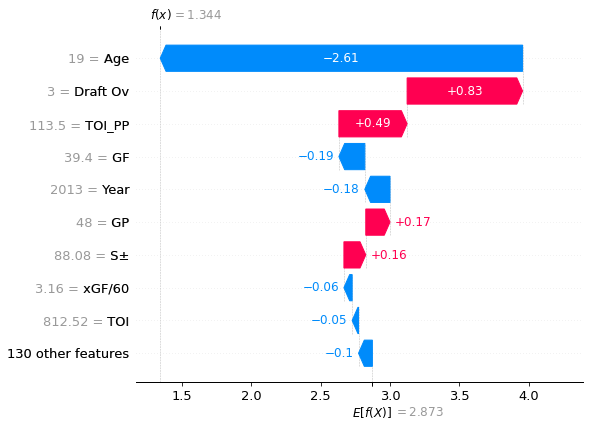

In [550]:
#Showing this graphic, and saving it as a png for future use
fig = plt.gcf()
shap.plots.waterfall(jh_shap_values[0])
fig.savefig('jh_1.png')

Here we see the magnitude of the effect of each feature on the Cap Hit prediction for Huberdeau more clearly.  Age by far has the greatest impact on his salary here.  Let's compare this to his 10th, and current, year in the NHL.

In [546]:
shap.initjs()

In [547]:
shap.plots.force(jh_shap_values[9])

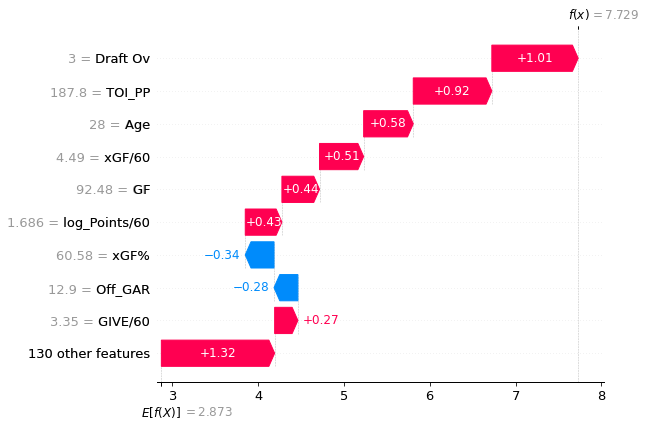

In [543]:
#Showing this graphic and saving it as a png for future use
fig = plt.gcf()
shap.plots.waterfall(jh_shap_values[9])
fig.savefig('jh_10.png')

Here we can see how much the model has adapated in order to predict Huberdeau's current season, as well as how the most important features now play an increased role.

Huberdeau's age now has a **positive** effect on his salary, moving from a rookie's entry level contract into a veteran's contract.  Interestingly, where he was drafted STILL has an impact on his prediction despite it being 11 years after he has been drafted.  Time On Ice for the Power Play, along with GF and xGF/60, now have an increased level of importance in his prediction, matching the features that are the most important in both the XGBoost model and the Random Forest model.

Last, we'll use a force plot to have an overview of Huberdeau's career to date and how the effects of different features change over time.

In [557]:
shap.plots.force(jh_shap_values)

Setting the order of the shap values by age, you can see Huberdeau's Cap Hit predictions over the course of his career in chronological order.

At the start, Age is a big negative factor in the salary which decreases over time, until he's 25 when it becomes a positive feature.

Performance statistics have a negligible effect when Huberdeau is young.  At around age 24, Goals For and Time On Ice on the Power Play become increasingly important, raising the value of Huberdeau's predicted Cap Hit.

Interestingly, the fact that he was the 3rd player overall draft has a consistent, positive influence on his Cap Hit prediction throughout the course of his career.

It should be noted that for the past 5 years (starting with his Age 24 season), Huberdeau's Cap Hit has been $5.9 million.  He has consistently outperformed the level of his actual Cap Hit by these predictions, which again supports the notion to spend less money on a 'mega' contract in order to spread it to more, high quality players.

I will summarize all of my findings in my final notebook.

### Next Steps

1. The csv output from this notebook will be placed in a data folder.  However, this is NOT the data that will be used for the next notebook.

1. Ensure that the 'CLEAN_CLUSTERING_032522.csv' that has been provided is in the same folder as the next notebook.

2. The next notebook is titled **Brian Johns Capstone #3 - Clustering Models**